In [1]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


In [2]:
temp_img = cv2.imread("data/images/M-34-51-C-d-4-1.tif") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread("data/masks/M-34-51-C-d-4-1.tif") #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [0 1 2 3 4]  and the counts are:  [23401744  1167023 14924792 40573354  2735233]


In [3]:
root_directory = 'data/'
patch_size = 128

In [5]:
img_dir=root_directory+"images/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(root_directory+"128_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)
                    #image_dataset.append(single_patch_img)

Now patchifying image: data/images//M-33-20-D-c-4-2.tif
Now patchifying image: data/images//M-33-20-D-d-3-3.tif
Now patchifying image: data/images//M-33-32-B-b-4-4.tif
Now patchifying image: data/images//M-33-48-A-c-4-4.tif
Now patchifying image: data/images//M-33-7-A-d-2-3.tif
Now patchifying image: data/images//M-33-7-A-d-3-2.tif
Now patchifying image: data/images//M-34-32-B-a-4-3.tif
Now patchifying image: data/images//M-34-32-B-b-1-3.tif
Now patchifying image: data/images//M-34-5-D-d-4-2.tif
Now patchifying image: data/images//M-34-51-C-b-2-1.tif
Now patchifying image: data/images//M-34-51-C-d-4-1.tif
Now patchifying image: data/images//M-34-55-B-b-4-1.tif
Now patchifying image: data/images//M-34-56-A-b-1-4.tif
Now patchifying image: data/images//M-34-6-A-d-2-2.tif
Now patchifying image: data/images//M-34-65-D-a-4-4.tif
Now patchifying image: data/images//M-34-65-D-c-4-2.tif
Now patchifying image: data/images//M-34-65-D-d-4-1.tif
Now patchifying image: data/images//M-34-68-B-a-1-3.

In [6]:
 #Do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dir=root_directory+"masks/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite(root_directory+"128_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask)

Now patchifying mask: data/masks//M-33-20-D-c-4-2.tif
Now patchifying mask: data/masks//M-33-20-D-d-3-3.tif
Now patchifying mask: data/masks//M-33-32-B-b-4-4.tif
Now patchifying mask: data/masks//M-33-48-A-c-4-4.tif
Now patchifying mask: data/masks//M-33-7-A-d-2-3.tif
Now patchifying mask: data/masks//M-33-7-A-d-3-2.tif
Now patchifying mask: data/masks//M-34-32-B-a-4-3.tif
Now patchifying mask: data/masks//M-34-32-B-b-1-3.tif
Now patchifying mask: data/masks//M-34-5-D-d-4-2.tif
Now patchifying mask: data/masks//M-34-51-C-b-2-1.tif
Now patchifying mask: data/masks//M-34-51-C-d-4-1.tif
Now patchifying mask: data/masks//M-34-55-B-b-4-1.tif
Now patchifying mask: data/masks//M-34-56-A-b-1-4.tif
Now patchifying mask: data/masks//M-34-6-A-d-2-2.tif
Now patchifying mask: data/masks//M-34-65-D-a-4-4.tif
Now patchifying mask: data/masks//M-34-65-D-c-4-2.tif
Now patchifying mask: data/masks//M-34-65-D-d-4-1.tif
Now patchifying mask: data/masks//M-34-68-B-a-1-3.tif
Now patchifying mask: data/masks

In [7]:
train_img_dir = "data/128_patches/images/"
train_mask_dir = "data/128_patches/masks/"

In [8]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [9]:
num_images = len(os.listdir(train_img_dir))


In [10]:
img_num = random.randint(0, num_images-1)


In [11]:
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

In [12]:
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

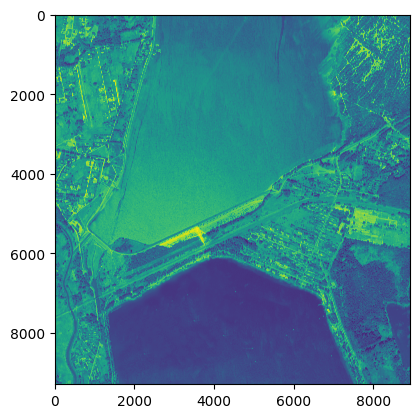

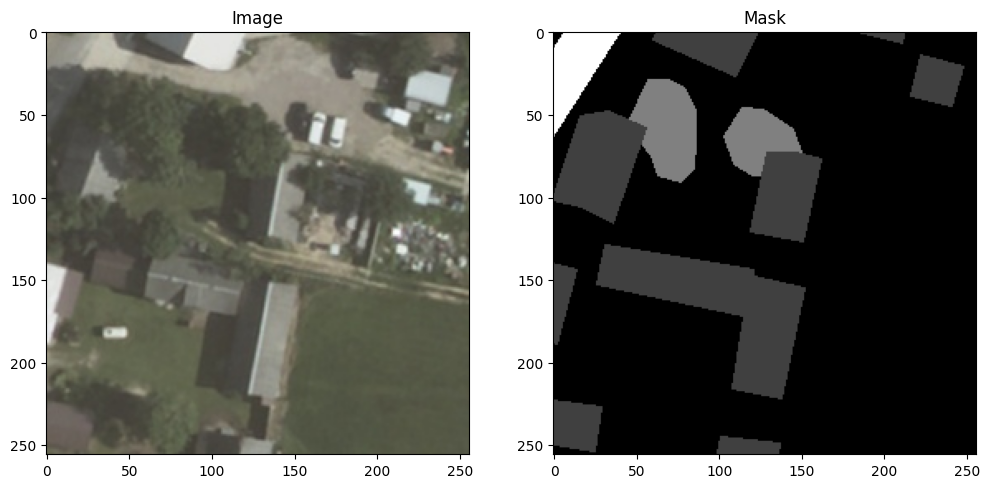

In [13]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [15]:
useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Save Me")
        cv2.imwrite('data/128_patches/useful_data/images/'+img_name, temp_image)
        cv2.imwrite('data/128_patches/useful_data/masks/'+mask_name, temp_mask)
        
    else:
        print("I am useless")   
        useless +=1

Now preparing image and masks number:  0
I am useless
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
I am useless
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
Save Me
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
I am useless
Now preparing image and masks number:  7
I am useless
Now preparing image and masks number:  8
I am useless
Now preparing image and masks number:  9
I am useless
Now preparing image and masks number:  10
I am useless
Now preparing image and masks number:  11
I am useless
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
I am useless
Now preparing image and masks number:  14
I am useless
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now prepar

Save Me
Now preparing image and masks number:  164
I am useless
Now preparing image and masks number:  165
I am useless
Now preparing image and masks number:  166
Save Me
Now preparing image and masks number:  167
I am useless
Now preparing image and masks number:  168
Save Me
Now preparing image and masks number:  169
I am useless
Now preparing image and masks number:  170
I am useless
Now preparing image and masks number:  171
I am useless
Now preparing image and masks number:  172
I am useless
Now preparing image and masks number:  173
Save Me
Now preparing image and masks number:  174
Save Me
Now preparing image and masks number:  175
I am useless
Now preparing image and masks number:  176
I am useless
Now preparing image and masks number:  177
I am useless
Now preparing image and masks number:  178
I am useless
Now preparing image and masks number:  179
Save Me
Now preparing image and masks number:  180
I am useless
Now preparing image and masks number:  181
Save Me
Now preparing 

Save Me
Now preparing image and masks number:  333
Save Me
Now preparing image and masks number:  334
I am useless
Now preparing image and masks number:  335
I am useless
Now preparing image and masks number:  336
Save Me
Now preparing image and masks number:  337
I am useless
Now preparing image and masks number:  338
Save Me
Now preparing image and masks number:  339
I am useless
Now preparing image and masks number:  340
I am useless
Now preparing image and masks number:  341
I am useless
Now preparing image and masks number:  342
I am useless
Now preparing image and masks number:  343
I am useless
Now preparing image and masks number:  344
I am useless
Now preparing image and masks number:  345
I am useless
Now preparing image and masks number:  346
I am useless
Now preparing image and masks number:  347
Save Me
Now preparing image and masks number:  348
I am useless
Now preparing image and masks number:  349
I am useless
Now preparing image and masks number:  350
Save Me
Now prepa

I am useless
Now preparing image and masks number:  492
Save Me
Now preparing image and masks number:  493
Save Me
Now preparing image and masks number:  494
Save Me
Now preparing image and masks number:  495
Save Me
Now preparing image and masks number:  496
I am useless
Now preparing image and masks number:  497
Save Me
Now preparing image and masks number:  498
Save Me
Now preparing image and masks number:  499
Save Me
Now preparing image and masks number:  500
Save Me
Now preparing image and masks number:  501
Save Me
Now preparing image and masks number:  502
Save Me
Now preparing image and masks number:  503
Save Me
Now preparing image and masks number:  504
Save Me
Now preparing image and masks number:  505
Save Me
Now preparing image and masks number:  506
I am useless
Now preparing image and masks number:  507
I am useless
Now preparing image and masks number:  508
Save Me
Now preparing image and masks number:  509
Save Me
Now preparing image and masks number:  510
Save Me
Now

Save Me
Now preparing image and masks number:  657
I am useless
Now preparing image and masks number:  658
I am useless
Now preparing image and masks number:  659
I am useless
Now preparing image and masks number:  660
Save Me
Now preparing image and masks number:  661
Save Me
Now preparing image and masks number:  662
Save Me
Now preparing image and masks number:  663
I am useless
Now preparing image and masks number:  664
I am useless
Now preparing image and masks number:  665
I am useless
Now preparing image and masks number:  666
I am useless
Now preparing image and masks number:  667
I am useless
Now preparing image and masks number:  668
I am useless
Now preparing image and masks number:  669
I am useless
Now preparing image and masks number:  670
I am useless
Now preparing image and masks number:  671
Save Me
Now preparing image and masks number:  672
I am useless
Now preparing image and masks number:  673
I am useless
Now preparing image and masks number:  674
Save Me
Now prepa

Now preparing image and masks number:  814
Save Me
Now preparing image and masks number:  815
Save Me
Now preparing image and masks number:  816
I am useless
Now preparing image and masks number:  817
I am useless
Now preparing image and masks number:  818
I am useless
Now preparing image and masks number:  819
Save Me
Now preparing image and masks number:  820
Save Me
Now preparing image and masks number:  821
Save Me
Now preparing image and masks number:  822
Save Me
Now preparing image and masks number:  823
I am useless
Now preparing image and masks number:  824
Save Me
Now preparing image and masks number:  825
Save Me
Now preparing image and masks number:  826
I am useless
Now preparing image and masks number:  827
I am useless
Now preparing image and masks number:  828
I am useless
Now preparing image and masks number:  829
I am useless
Now preparing image and masks number:  830
I am useless
Now preparing image and masks number:  831
I am useless
Now preparing image and masks nu

I am useless
Now preparing image and masks number:  989
I am useless
Now preparing image and masks number:  990
Save Me
Now preparing image and masks number:  991
Save Me
Now preparing image and masks number:  992
Save Me
Now preparing image and masks number:  993
Save Me
Now preparing image and masks number:  994
Save Me
Now preparing image and masks number:  995
Save Me
Now preparing image and masks number:  996
I am useless
Now preparing image and masks number:  997
Save Me
Now preparing image and masks number:  998
Save Me
Now preparing image and masks number:  999
Save Me
Now preparing image and masks number:  1000
Save Me
Now preparing image and masks number:  1001
Save Me
Now preparing image and masks number:  1002
I am useless
Now preparing image and masks number:  1003
I am useless
Now preparing image and masks number:  1004
Save Me
Now preparing image and masks number:  1005
I am useless
Now preparing image and masks number:  1006
Save Me
Now preparing image and masks number:

I am useless
Now preparing image and masks number:  1151
I am useless
Now preparing image and masks number:  1152
Save Me
Now preparing image and masks number:  1153
I am useless
Now preparing image and masks number:  1154
I am useless
Now preparing image and masks number:  1155
Save Me
Now preparing image and masks number:  1156
Save Me
Now preparing image and masks number:  1157
I am useless
Now preparing image and masks number:  1158
I am useless
Now preparing image and masks number:  1159
I am useless
Now preparing image and masks number:  1160
I am useless
Now preparing image and masks number:  1161
Save Me
Now preparing image and masks number:  1162
I am useless
Now preparing image and masks number:  1163
Save Me
Now preparing image and masks number:  1164
Save Me
Now preparing image and masks number:  1165
I am useless
Now preparing image and masks number:  1166
I am useless
Now preparing image and masks number:  1167
Save Me
Now preparing image and masks number:  1168
Save Me
N

Save Me
Now preparing image and masks number:  1305
Save Me
Now preparing image and masks number:  1306
Save Me
Now preparing image and masks number:  1307
Save Me
Now preparing image and masks number:  1308
Save Me
Now preparing image and masks number:  1309
Save Me
Now preparing image and masks number:  1310
Save Me
Now preparing image and masks number:  1311
Save Me
Now preparing image and masks number:  1312
I am useless
Now preparing image and masks number:  1313
I am useless
Now preparing image and masks number:  1314
I am useless
Now preparing image and masks number:  1315
I am useless
Now preparing image and masks number:  1316
I am useless
Now preparing image and masks number:  1317
Save Me
Now preparing image and masks number:  1318
Save Me
Now preparing image and masks number:  1319
Save Me
Now preparing image and masks number:  1320
Save Me
Now preparing image and masks number:  1321
Save Me
Now preparing image and masks number:  1322
Save Me
Now preparing image and masks n

I am useless
Now preparing image and masks number:  1475
I am useless
Now preparing image and masks number:  1476
I am useless
Now preparing image and masks number:  1477
Save Me
Now preparing image and masks number:  1478
Save Me
Now preparing image and masks number:  1479
Save Me
Now preparing image and masks number:  1480
Save Me
Now preparing image and masks number:  1481
Save Me
Now preparing image and masks number:  1482
Save Me
Now preparing image and masks number:  1483
Save Me
Now preparing image and masks number:  1484
Save Me
Now preparing image and masks number:  1485
Save Me
Now preparing image and masks number:  1486
Save Me
Now preparing image and masks number:  1487
Save Me
Now preparing image and masks number:  1488
Save Me
Now preparing image and masks number:  1489
Save Me
Now preparing image and masks number:  1490
Save Me
Now preparing image and masks number:  1491
Save Me
Now preparing image and masks number:  1492
Save Me
Now preparing image and masks number:  14

Now preparing image and masks number:  1640
I am useless
Now preparing image and masks number:  1641
I am useless
Now preparing image and masks number:  1642
I am useless
Now preparing image and masks number:  1643
I am useless
Now preparing image and masks number:  1644
I am useless
Now preparing image and masks number:  1645
Save Me
Now preparing image and masks number:  1646
Save Me
Now preparing image and masks number:  1647
I am useless
Now preparing image and masks number:  1648
I am useless
Now preparing image and masks number:  1649
I am useless
Now preparing image and masks number:  1650
I am useless
Now preparing image and masks number:  1651
Save Me
Now preparing image and masks number:  1652
Save Me
Now preparing image and masks number:  1653
I am useless
Now preparing image and masks number:  1654
I am useless
Now preparing image and masks number:  1655
I am useless
Now preparing image and masks number:  1656
Save Me
Now preparing image and masks number:  1657
Save Me
Now 

Save Me
Now preparing image and masks number:  1794
Save Me
Now preparing image and masks number:  1795
I am useless
Now preparing image and masks number:  1796
Save Me
Now preparing image and masks number:  1797
Save Me
Now preparing image and masks number:  1798
Save Me
Now preparing image and masks number:  1799
Save Me
Now preparing image and masks number:  1800
Save Me
Now preparing image and masks number:  1801
Save Me
Now preparing image and masks number:  1802
Save Me
Now preparing image and masks number:  1803
I am useless
Now preparing image and masks number:  1804
I am useless
Now preparing image and masks number:  1805
Save Me
Now preparing image and masks number:  1806
Save Me
Now preparing image and masks number:  1807
Save Me
Now preparing image and masks number:  1808
I am useless
Now preparing image and masks number:  1809
Save Me
Now preparing image and masks number:  1810
Save Me
Now preparing image and masks number:  1811
Save Me
Now preparing image and masks number

Save Me
Now preparing image and masks number:  1955
Save Me
Now preparing image and masks number:  1956
Save Me
Now preparing image and masks number:  1957
Save Me
Now preparing image and masks number:  1958
Save Me
Now preparing image and masks number:  1959
Save Me
Now preparing image and masks number:  1960
Save Me
Now preparing image and masks number:  1961
I am useless
Now preparing image and masks number:  1962
I am useless
Now preparing image and masks number:  1963
Save Me
Now preparing image and masks number:  1964
I am useless
Now preparing image and masks number:  1965
I am useless
Now preparing image and masks number:  1966
I am useless
Now preparing image and masks number:  1967
Save Me
Now preparing image and masks number:  1968
Save Me
Now preparing image and masks number:  1969
I am useless
Now preparing image and masks number:  1970
I am useless
Now preparing image and masks number:  1971
I am useless
Now preparing image and masks number:  1972
I am useless
Now prepari

Now preparing image and masks number:  2114
Save Me
Now preparing image and masks number:  2115
Save Me
Now preparing image and masks number:  2116
Save Me
Now preparing image and masks number:  2117
Save Me
Now preparing image and masks number:  2118
Save Me
Now preparing image and masks number:  2119
Save Me
Now preparing image and masks number:  2120
Save Me
Now preparing image and masks number:  2121
Save Me
Now preparing image and masks number:  2122
I am useless
Now preparing image and masks number:  2123
Save Me
Now preparing image and masks number:  2124
Save Me
Now preparing image and masks number:  2125
Save Me
Now preparing image and masks number:  2126
Save Me
Now preparing image and masks number:  2127
I am useless
Now preparing image and masks number:  2128
I am useless
Now preparing image and masks number:  2129
I am useless
Now preparing image and masks number:  2130
Save Me
Now preparing image and masks number:  2131
I am useless
Now preparing image and masks number:  

I am useless
Now preparing image and masks number:  2281
Save Me
Now preparing image and masks number:  2282
Save Me
Now preparing image and masks number:  2283
Save Me
Now preparing image and masks number:  2284
Save Me
Now preparing image and masks number:  2285
I am useless
Now preparing image and masks number:  2286
I am useless
Now preparing image and masks number:  2287
I am useless
Now preparing image and masks number:  2288
Save Me
Now preparing image and masks number:  2289
Save Me
Now preparing image and masks number:  2290
Save Me
Now preparing image and masks number:  2291
Save Me
Now preparing image and masks number:  2292
Save Me
Now preparing image and masks number:  2293
Save Me
Now preparing image and masks number:  2294
I am useless
Now preparing image and masks number:  2295
I am useless
Now preparing image and masks number:  2296
Save Me
Now preparing image and masks number:  2297
Save Me
Now preparing image and masks number:  2298
Save Me
Now preparing image and ma

Save Me
Now preparing image and masks number:  2452
I am useless
Now preparing image and masks number:  2453
Save Me
Now preparing image and masks number:  2454
Save Me
Now preparing image and masks number:  2455
Save Me
Now preparing image and masks number:  2456
Save Me
Now preparing image and masks number:  2457
Save Me
Now preparing image and masks number:  2458
I am useless
Now preparing image and masks number:  2459
I am useless
Now preparing image and masks number:  2460
I am useless
Now preparing image and masks number:  2461
I am useless
Now preparing image and masks number:  2462
I am useless
Now preparing image and masks number:  2463
I am useless
Now preparing image and masks number:  2464
I am useless
Now preparing image and masks number:  2465
I am useless
Now preparing image and masks number:  2466
I am useless
Now preparing image and masks number:  2467
Save Me
Now preparing image and masks number:  2468
Save Me
Now preparing image and masks number:  2469
I am useless
N

I am useless
Now preparing image and masks number:  2630
Save Me
Now preparing image and masks number:  2631
I am useless
Now preparing image and masks number:  2632
Save Me
Now preparing image and masks number:  2633
I am useless
Now preparing image and masks number:  2634
Save Me
Now preparing image and masks number:  2635
Save Me
Now preparing image and masks number:  2636
Save Me
Now preparing image and masks number:  2637
Save Me
Now preparing image and masks number:  2638
I am useless
Now preparing image and masks number:  2639
Save Me
Now preparing image and masks number:  2640
Save Me
Now preparing image and masks number:  2641
I am useless
Now preparing image and masks number:  2642
Save Me
Now preparing image and masks number:  2643
I am useless
Now preparing image and masks number:  2644
Save Me
Now preparing image and masks number:  2645
Save Me
Now preparing image and masks number:  2646
Save Me
Now preparing image and masks number:  2647
I am useless
Now preparing image a

I am useless
Now preparing image and masks number:  2781
Save Me
Now preparing image and masks number:  2782
I am useless
Now preparing image and masks number:  2783
I am useless
Now preparing image and masks number:  2784
I am useless
Now preparing image and masks number:  2785
I am useless
Now preparing image and masks number:  2786
I am useless
Now preparing image and masks number:  2787
I am useless
Now preparing image and masks number:  2788
I am useless
Now preparing image and masks number:  2789
I am useless
Now preparing image and masks number:  2790
I am useless
Now preparing image and masks number:  2791
I am useless
Now preparing image and masks number:  2792
I am useless
Now preparing image and masks number:  2793
I am useless
Now preparing image and masks number:  2794
I am useless
Now preparing image and masks number:  2795
I am useless
Now preparing image and masks number:  2796
I am useless
Now preparing image and masks number:  2797
Save Me
Now preparing image and mask

Now preparing image and masks number:  2929
I am useless
Now preparing image and masks number:  2930
I am useless
Now preparing image and masks number:  2931
I am useless
Now preparing image and masks number:  2932
I am useless
Now preparing image and masks number:  2933
I am useless
Now preparing image and masks number:  2934
I am useless
Now preparing image and masks number:  2935
I am useless
Now preparing image and masks number:  2936
Save Me
Now preparing image and masks number:  2937
I am useless
Now preparing image and masks number:  2938
I am useless
Now preparing image and masks number:  2939
I am useless
Now preparing image and masks number:  2940
I am useless
Now preparing image and masks number:  2941
I am useless
Now preparing image and masks number:  2942
I am useless
Now preparing image and masks number:  2943
I am useless
Now preparing image and masks number:  2944
I am useless
Now preparing image and masks number:  2945
I am useless
Now preparing image and masks number

Now preparing image and masks number:  3097
I am useless
Now preparing image and masks number:  3098
I am useless
Now preparing image and masks number:  3099
I am useless
Now preparing image and masks number:  3100
Save Me
Now preparing image and masks number:  3101
I am useless
Now preparing image and masks number:  3102
I am useless
Now preparing image and masks number:  3103
I am useless
Now preparing image and masks number:  3104
I am useless
Now preparing image and masks number:  3105
I am useless
Now preparing image and masks number:  3106
Save Me
Now preparing image and masks number:  3107
Save Me
Now preparing image and masks number:  3108
I am useless
Now preparing image and masks number:  3109
I am useless
Now preparing image and masks number:  3110
I am useless
Now preparing image and masks number:  3111
Save Me
Now preparing image and masks number:  3112
I am useless
Now preparing image and masks number:  3113
I am useless
Now preparing image and masks number:  3114
I am us

I am useless
Now preparing image and masks number:  3270
Save Me
Now preparing image and masks number:  3271
Save Me
Now preparing image and masks number:  3272
I am useless
Now preparing image and masks number:  3273
I am useless
Now preparing image and masks number:  3274
I am useless
Now preparing image and masks number:  3275
I am useless
Now preparing image and masks number:  3276
Save Me
Now preparing image and masks number:  3277
Save Me
Now preparing image and masks number:  3278
Save Me
Now preparing image and masks number:  3279
Save Me
Now preparing image and masks number:  3280
I am useless
Now preparing image and masks number:  3281
Save Me
Now preparing image and masks number:  3282
Save Me
Now preparing image and masks number:  3283
Save Me
Now preparing image and masks number:  3284
I am useless
Now preparing image and masks number:  3285
I am useless
Now preparing image and masks number:  3286
Save Me
Now preparing image and masks number:  3287
I am useless
Now prepari

Save Me
Now preparing image and masks number:  3438
I am useless
Now preparing image and masks number:  3439
I am useless
Now preparing image and masks number:  3440
I am useless
Now preparing image and masks number:  3441
I am useless
Now preparing image and masks number:  3442
Save Me
Now preparing image and masks number:  3443
Save Me
Now preparing image and masks number:  3444
Save Me
Now preparing image and masks number:  3445
I am useless
Now preparing image and masks number:  3446
I am useless
Now preparing image and masks number:  3447
I am useless
Now preparing image and masks number:  3448
I am useless
Now preparing image and masks number:  3449
I am useless
Now preparing image and masks number:  3450
Save Me
Now preparing image and masks number:  3451
Save Me
Now preparing image and masks number:  3452
I am useless
Now preparing image and masks number:  3453
I am useless
Now preparing image and masks number:  3454
I am useless
Now preparing image and masks number:  3455
I am

Now preparing image and masks number:  3598
Save Me
Now preparing image and masks number:  3599
Save Me
Now preparing image and masks number:  3600
I am useless
Now preparing image and masks number:  3601
Save Me
Now preparing image and masks number:  3602
I am useless
Now preparing image and masks number:  3603
I am useless
Now preparing image and masks number:  3604
Save Me
Now preparing image and masks number:  3605
Save Me
Now preparing image and masks number:  3606
Save Me
Now preparing image and masks number:  3607
Save Me
Now preparing image and masks number:  3608
I am useless
Now preparing image and masks number:  3609
I am useless
Now preparing image and masks number:  3610
I am useless
Now preparing image and masks number:  3611
I am useless
Now preparing image and masks number:  3612
I am useless
Now preparing image and masks number:  3613
I am useless
Now preparing image and masks number:  3614
I am useless
Now preparing image and masks number:  3615
Save Me
Now preparing 

I am useless
Now preparing image and masks number:  3767
Save Me
Now preparing image and masks number:  3768
I am useless
Now preparing image and masks number:  3769
Save Me
Now preparing image and masks number:  3770
Save Me
Now preparing image and masks number:  3771
I am useless
Now preparing image and masks number:  3772
Save Me
Now preparing image and masks number:  3773
Save Me
Now preparing image and masks number:  3774
Save Me
Now preparing image and masks number:  3775
Save Me
Now preparing image and masks number:  3776
I am useless
Now preparing image and masks number:  3777
I am useless
Now preparing image and masks number:  3778
I am useless
Now preparing image and masks number:  3779
Save Me
Now preparing image and masks number:  3780
I am useless
Now preparing image and masks number:  3781
Save Me
Now preparing image and masks number:  3782
Save Me
Now preparing image and masks number:  3783
Save Me
Now preparing image and masks number:  3784
Save Me
Now preparing image a

Now preparing image and masks number:  3925
I am useless
Now preparing image and masks number:  3926
I am useless
Now preparing image and masks number:  3927
I am useless
Now preparing image and masks number:  3928
Save Me
Now preparing image and masks number:  3929
Save Me
Now preparing image and masks number:  3930
Save Me
Now preparing image and masks number:  3931
I am useless
Now preparing image and masks number:  3932
I am useless
Now preparing image and masks number:  3933
I am useless
Now preparing image and masks number:  3934
I am useless
Now preparing image and masks number:  3935
Save Me
Now preparing image and masks number:  3936
Save Me
Now preparing image and masks number:  3937
Save Me
Now preparing image and masks number:  3938
I am useless
Now preparing image and masks number:  3939
Save Me
Now preparing image and masks number:  3940
I am useless
Now preparing image and masks number:  3941
Save Me
Now preparing image and masks number:  3942
Save Me
Now preparing image

Now preparing image and masks number:  4093
I am useless
Now preparing image and masks number:  4094
Save Me
Now preparing image and masks number:  4095
Save Me
Now preparing image and masks number:  4096
Save Me
Now preparing image and masks number:  4097
Save Me
Now preparing image and masks number:  4098
Save Me
Now preparing image and masks number:  4099
Save Me
Now preparing image and masks number:  4100
I am useless
Now preparing image and masks number:  4101
I am useless
Now preparing image and masks number:  4102
I am useless
Now preparing image and masks number:  4103
Save Me
Now preparing image and masks number:  4104
I am useless
Now preparing image and masks number:  4105
Save Me
Now preparing image and masks number:  4106
I am useless
Now preparing image and masks number:  4107
I am useless
Now preparing image and masks number:  4108
I am useless
Now preparing image and masks number:  4109
I am useless
Now preparing image and masks number:  4110
I am useless
Now preparing 

Save Me
Now preparing image and masks number:  4245
I am useless
Now preparing image and masks number:  4246
Save Me
Now preparing image and masks number:  4247
I am useless
Now preparing image and masks number:  4248
Save Me
Now preparing image and masks number:  4249
I am useless
Now preparing image and masks number:  4250
I am useless
Now preparing image and masks number:  4251
I am useless
Now preparing image and masks number:  4252
Save Me
Now preparing image and masks number:  4253
Save Me
Now preparing image and masks number:  4254
I am useless
Now preparing image and masks number:  4255
I am useless
Now preparing image and masks number:  4256
Save Me
Now preparing image and masks number:  4257
Save Me
Now preparing image and masks number:  4258
I am useless
Now preparing image and masks number:  4259
I am useless
Now preparing image and masks number:  4260
I am useless
Now preparing image and masks number:  4261
I am useless
Now preparing image and masks number:  4262
Save Me
N

Save Me
Now preparing image and masks number:  4410
Save Me
Now preparing image and masks number:  4411
Save Me
Now preparing image and masks number:  4412
Save Me
Now preparing image and masks number:  4413
Save Me
Now preparing image and masks number:  4414
Save Me
Now preparing image and masks number:  4415
I am useless
Now preparing image and masks number:  4416
Save Me
Now preparing image and masks number:  4417
Save Me
Now preparing image and masks number:  4418
Save Me
Now preparing image and masks number:  4419
I am useless
Now preparing image and masks number:  4420
I am useless
Now preparing image and masks number:  4421
I am useless
Now preparing image and masks number:  4422
I am useless
Now preparing image and masks number:  4423
Save Me
Now preparing image and masks number:  4424
Save Me
Now preparing image and masks number:  4425
Save Me
Now preparing image and masks number:  4426
Save Me
Now preparing image and masks number:  4427
Save Me
Now preparing image and masks n

Save Me
Now preparing image and masks number:  4595
Save Me
Now preparing image and masks number:  4596
Save Me
Now preparing image and masks number:  4597
I am useless
Now preparing image and masks number:  4598
I am useless
Now preparing image and masks number:  4599
I am useless
Now preparing image and masks number:  4600
I am useless
Now preparing image and masks number:  4601
I am useless
Now preparing image and masks number:  4602
I am useless
Now preparing image and masks number:  4603
I am useless
Now preparing image and masks number:  4604
I am useless
Now preparing image and masks number:  4605
I am useless
Now preparing image and masks number:  4606
I am useless
Now preparing image and masks number:  4607
I am useless
Now preparing image and masks number:  4608
I am useless
Now preparing image and masks number:  4609
I am useless
Now preparing image and masks number:  4610
I am useless
Now preparing image and masks number:  4611
I am useless
Now preparing image and masks num

I am useless
Now preparing image and masks number:  4761
I am useless
Now preparing image and masks number:  4762
I am useless
Now preparing image and masks number:  4763
Save Me
Now preparing image and masks number:  4764
I am useless
Now preparing image and masks number:  4765
I am useless
Now preparing image and masks number:  4766
I am useless
Now preparing image and masks number:  4767
I am useless
Now preparing image and masks number:  4768
I am useless
Now preparing image and masks number:  4769
Save Me
Now preparing image and masks number:  4770
I am useless
Now preparing image and masks number:  4771
Save Me
Now preparing image and masks number:  4772
Save Me
Now preparing image and masks number:  4773
Save Me
Now preparing image and masks number:  4774
Save Me
Now preparing image and masks number:  4775
I am useless
Now preparing image and masks number:  4776
I am useless
Now preparing image and masks number:  4777
Save Me
Now preparing image and masks number:  4778
Save Me
N

Save Me
Now preparing image and masks number:  4920
I am useless
Now preparing image and masks number:  4921
I am useless
Now preparing image and masks number:  4922
I am useless
Now preparing image and masks number:  4923
I am useless
Now preparing image and masks number:  4924
I am useless
Now preparing image and masks number:  4925
I am useless
Now preparing image and masks number:  4926
Save Me
Now preparing image and masks number:  4927
I am useless
Now preparing image and masks number:  4928
Save Me
Now preparing image and masks number:  4929
Save Me
Now preparing image and masks number:  4930
Save Me
Now preparing image and masks number:  4931
Save Me
Now preparing image and masks number:  4932
Save Me
Now preparing image and masks number:  4933
Save Me
Now preparing image and masks number:  4934
Save Me
Now preparing image and masks number:  4935
Save Me
Now preparing image and masks number:  4936
Save Me
Now preparing image and masks number:  4937
Save Me
Now preparing image a

I am useless
Now preparing image and masks number:  5089
I am useless
Now preparing image and masks number:  5090
Save Me
Now preparing image and masks number:  5091
I am useless
Now preparing image and masks number:  5092
Save Me
Now preparing image and masks number:  5093
Save Me
Now preparing image and masks number:  5094
Save Me
Now preparing image and masks number:  5095
I am useless
Now preparing image and masks number:  5096
Save Me
Now preparing image and masks number:  5097
I am useless
Now preparing image and masks number:  5098
I am useless
Now preparing image and masks number:  5099
I am useless
Now preparing image and masks number:  5100
Save Me
Now preparing image and masks number:  5101
Save Me
Now preparing image and masks number:  5102
I am useless
Now preparing image and masks number:  5103
I am useless
Now preparing image and masks number:  5104
I am useless
Now preparing image and masks number:  5105
I am useless
Now preparing image and masks number:  5106
I am usel

Now preparing image and masks number:  5236
I am useless
Now preparing image and masks number:  5237
Save Me
Now preparing image and masks number:  5238
I am useless
Now preparing image and masks number:  5239
Save Me
Now preparing image and masks number:  5240
I am useless
Now preparing image and masks number:  5241
Save Me
Now preparing image and masks number:  5242
Save Me
Now preparing image and masks number:  5243
Save Me
Now preparing image and masks number:  5244
I am useless
Now preparing image and masks number:  5245
Save Me
Now preparing image and masks number:  5246
I am useless
Now preparing image and masks number:  5247
I am useless
Now preparing image and masks number:  5248
I am useless
Now preparing image and masks number:  5249
I am useless
Now preparing image and masks number:  5250
I am useless
Now preparing image and masks number:  5251
I am useless
Now preparing image and masks number:  5252
Save Me
Now preparing image and masks number:  5253
I am useless
Now prepa

I am useless
Now preparing image and masks number:  5405
I am useless
Now preparing image and masks number:  5406
I am useless
Now preparing image and masks number:  5407
I am useless
Now preparing image and masks number:  5408
I am useless
Now preparing image and masks number:  5409
Save Me
Now preparing image and masks number:  5410
Save Me
Now preparing image and masks number:  5411
I am useless
Now preparing image and masks number:  5412
I am useless
Now preparing image and masks number:  5413
I am useless
Now preparing image and masks number:  5414
I am useless
Now preparing image and masks number:  5415
I am useless
Now preparing image and masks number:  5416
I am useless
Now preparing image and masks number:  5417
I am useless
Now preparing image and masks number:  5418
Save Me
Now preparing image and masks number:  5419
I am useless
Now preparing image and masks number:  5420
Save Me
Now preparing image and masks number:  5421
Save Me
Now preparing image and masks number:  5422

I am useless
Now preparing image and masks number:  5558
I am useless
Now preparing image and masks number:  5559
I am useless
Now preparing image and masks number:  5560
I am useless
Now preparing image and masks number:  5561
I am useless
Now preparing image and masks number:  5562
I am useless
Now preparing image and masks number:  5563
Save Me
Now preparing image and masks number:  5564
I am useless
Now preparing image and masks number:  5565
I am useless
Now preparing image and masks number:  5566
I am useless
Now preparing image and masks number:  5567
I am useless
Now preparing image and masks number:  5568
Save Me
Now preparing image and masks number:  5569
I am useless
Now preparing image and masks number:  5570
Save Me
Now preparing image and masks number:  5571
Save Me
Now preparing image and masks number:  5572
I am useless
Now preparing image and masks number:  5573
I am useless
Now preparing image and masks number:  5574
I am useless
Now preparing image and masks number: 

I am useless
Now preparing image and masks number:  5726
I am useless
Now preparing image and masks number:  5727
I am useless
Now preparing image and masks number:  5728
I am useless
Now preparing image and masks number:  5729
Save Me
Now preparing image and masks number:  5730
I am useless
Now preparing image and masks number:  5731
Save Me
Now preparing image and masks number:  5732
I am useless
Now preparing image and masks number:  5733
Save Me
Now preparing image and masks number:  5734
I am useless
Now preparing image and masks number:  5735
I am useless
Now preparing image and masks number:  5736
I am useless
Now preparing image and masks number:  5737
I am useless
Now preparing image and masks number:  5738
Save Me
Now preparing image and masks number:  5739
Save Me
Now preparing image and masks number:  5740
I am useless
Now preparing image and masks number:  5741
I am useless
Now preparing image and masks number:  5742
I am useless
Now preparing image and masks number:  5743

I am useless
Now preparing image and masks number:  5894
I am useless
Now preparing image and masks number:  5895
I am useless
Now preparing image and masks number:  5896
Save Me
Now preparing image and masks number:  5897
Save Me
Now preparing image and masks number:  5898
Save Me
Now preparing image and masks number:  5899
I am useless
Now preparing image and masks number:  5900
Save Me
Now preparing image and masks number:  5901
Save Me
Now preparing image and masks number:  5902
I am useless
Now preparing image and masks number:  5903
I am useless
Now preparing image and masks number:  5904
Save Me
Now preparing image and masks number:  5905
Save Me
Now preparing image and masks number:  5906
I am useless
Now preparing image and masks number:  5907
Save Me
Now preparing image and masks number:  5908
Save Me
Now preparing image and masks number:  5909
I am useless
Now preparing image and masks number:  5910
Save Me
Now preparing image and masks number:  5911
Save Me
Now preparing im

I am useless
Now preparing image and masks number:  6055
I am useless
Now preparing image and masks number:  6056
Save Me
Now preparing image and masks number:  6057
Save Me
Now preparing image and masks number:  6058
Save Me
Now preparing image and masks number:  6059
Save Me
Now preparing image and masks number:  6060
I am useless
Now preparing image and masks number:  6061
I am useless
Now preparing image and masks number:  6062
I am useless
Now preparing image and masks number:  6063
I am useless
Now preparing image and masks number:  6064
Save Me
Now preparing image and masks number:  6065
Save Me
Now preparing image and masks number:  6066
Save Me
Now preparing image and masks number:  6067
Save Me
Now preparing image and masks number:  6068
Save Me
Now preparing image and masks number:  6069
Save Me
Now preparing image and masks number:  6070
Save Me
Now preparing image and masks number:  6071
Save Me
Now preparing image and masks number:  6072
I am useless
Now preparing image a

Save Me
Now preparing image and masks number:  6220
Save Me
Now preparing image and masks number:  6221
I am useless
Now preparing image and masks number:  6222
Save Me
Now preparing image and masks number:  6223
Save Me
Now preparing image and masks number:  6224
Save Me
Now preparing image and masks number:  6225
Save Me
Now preparing image and masks number:  6226
Save Me
Now preparing image and masks number:  6227
Save Me
Now preparing image and masks number:  6228
Save Me
Now preparing image and masks number:  6229
Save Me
Now preparing image and masks number:  6230
I am useless
Now preparing image and masks number:  6231
I am useless
Now preparing image and masks number:  6232
Save Me
Now preparing image and masks number:  6233
Save Me
Now preparing image and masks number:  6234
Save Me
Now preparing image and masks number:  6235
Save Me
Now preparing image and masks number:  6236
Save Me
Now preparing image and masks number:  6237
Save Me
Now preparing image and masks number:  62

Save Me
Now preparing image and masks number:  6382
Save Me
Now preparing image and masks number:  6383
Save Me
Now preparing image and masks number:  6384
I am useless
Now preparing image and masks number:  6385
I am useless
Now preparing image and masks number:  6386
Save Me
Now preparing image and masks number:  6387
Save Me
Now preparing image and masks number:  6388
I am useless
Now preparing image and masks number:  6389
Save Me
Now preparing image and masks number:  6390
Save Me
Now preparing image and masks number:  6391
Save Me
Now preparing image and masks number:  6392
Save Me
Now preparing image and masks number:  6393
Save Me
Now preparing image and masks number:  6394
Save Me
Now preparing image and masks number:  6395
Save Me
Now preparing image and masks number:  6396
Save Me
Now preparing image and masks number:  6397
Save Me
Now preparing image and masks number:  6398
Save Me
Now preparing image and masks number:  6399
Save Me
Now preparing image and masks number:  64

I am useless
Now preparing image and masks number:  6543
I am useless
Now preparing image and masks number:  6544
Save Me
Now preparing image and masks number:  6545
Save Me
Now preparing image and masks number:  6546
Save Me
Now preparing image and masks number:  6547
Save Me
Now preparing image and masks number:  6548
I am useless
Now preparing image and masks number:  6549
Save Me
Now preparing image and masks number:  6550
Save Me
Now preparing image and masks number:  6551
Save Me
Now preparing image and masks number:  6552
Save Me
Now preparing image and masks number:  6553
Save Me
Now preparing image and masks number:  6554
Save Me
Now preparing image and masks number:  6555
Save Me
Now preparing image and masks number:  6556
I am useless
Now preparing image and masks number:  6557
I am useless
Now preparing image and masks number:  6558
Save Me
Now preparing image and masks number:  6559
Save Me
Now preparing image and masks number:  6560
Save Me
Now preparing image and masks n

Save Me
Now preparing image and masks number:  6705
Save Me
Now preparing image and masks number:  6706
Save Me
Now preparing image and masks number:  6707
Save Me
Now preparing image and masks number:  6708
I am useless
Now preparing image and masks number:  6709
I am useless
Now preparing image and masks number:  6710
I am useless
Now preparing image and masks number:  6711
Save Me
Now preparing image and masks number:  6712
I am useless
Now preparing image and masks number:  6713
Save Me
Now preparing image and masks number:  6714
Save Me
Now preparing image and masks number:  6715
I am useless
Now preparing image and masks number:  6716
Save Me
Now preparing image and masks number:  6717
Save Me
Now preparing image and masks number:  6718
Save Me
Now preparing image and masks number:  6719
I am useless
Now preparing image and masks number:  6720
I am useless
Now preparing image and masks number:  6721
I am useless
Now preparing image and masks number:  6722
Save Me
Now preparing im

Save Me
Now preparing image and masks number:  6859
Save Me
Now preparing image and masks number:  6860
I am useless
Now preparing image and masks number:  6861
Save Me
Now preparing image and masks number:  6862
Save Me
Now preparing image and masks number:  6863
Save Me
Now preparing image and masks number:  6864
Save Me
Now preparing image and masks number:  6865
Save Me
Now preparing image and masks number:  6866
I am useless
Now preparing image and masks number:  6867
Save Me
Now preparing image and masks number:  6868
Save Me
Now preparing image and masks number:  6869
Save Me
Now preparing image and masks number:  6870
I am useless
Now preparing image and masks number:  6871
Save Me
Now preparing image and masks number:  6872
Save Me
Now preparing image and masks number:  6873
I am useless
Now preparing image and masks number:  6874
I am useless
Now preparing image and masks number:  6875
I am useless
Now preparing image and masks number:  6876
I am useless
Now preparing image a

Save Me
Now preparing image and masks number:  7020
Save Me
Now preparing image and masks number:  7021
Save Me
Now preparing image and masks number:  7022
Save Me
Now preparing image and masks number:  7023
Save Me
Now preparing image and masks number:  7024
I am useless
Now preparing image and masks number:  7025
Save Me
Now preparing image and masks number:  7026
Save Me
Now preparing image and masks number:  7027
Save Me
Now preparing image and masks number:  7028
Save Me
Now preparing image and masks number:  7029
Save Me
Now preparing image and masks number:  7030
I am useless
Now preparing image and masks number:  7031
I am useless
Now preparing image and masks number:  7032
I am useless
Now preparing image and masks number:  7033
I am useless
Now preparing image and masks number:  7034
I am useless
Now preparing image and masks number:  7035
I am useless
Now preparing image and masks number:  7036
I am useless
Now preparing image and masks number:  7037
Save Me
Now preparing im

Save Me
Now preparing image and masks number:  7182
Save Me
Now preparing image and masks number:  7183
Save Me
Now preparing image and masks number:  7184
Save Me
Now preparing image and masks number:  7185
Save Me
Now preparing image and masks number:  7186
Save Me
Now preparing image and masks number:  7187
I am useless
Now preparing image and masks number:  7188
I am useless
Now preparing image and masks number:  7189
Save Me
Now preparing image and masks number:  7190
Save Me
Now preparing image and masks number:  7191
Save Me
Now preparing image and masks number:  7192
Save Me
Now preparing image and masks number:  7193
Save Me
Now preparing image and masks number:  7194
Save Me
Now preparing image and masks number:  7195
Save Me
Now preparing image and masks number:  7196
I am useless
Now preparing image and masks number:  7197
I am useless
Now preparing image and masks number:  7198
I am useless
Now preparing image and masks number:  7199
Save Me
Now preparing image and masks n

I am useless
Now preparing image and masks number:  7341
I am useless
Now preparing image and masks number:  7342
I am useless
Now preparing image and masks number:  7343
Save Me
Now preparing image and masks number:  7344
Save Me
Now preparing image and masks number:  7345
Save Me
Now preparing image and masks number:  7346
Save Me
Now preparing image and masks number:  7347
I am useless
Now preparing image and masks number:  7348
Save Me
Now preparing image and masks number:  7349
Save Me
Now preparing image and masks number:  7350
Save Me
Now preparing image and masks number:  7351
I am useless
Now preparing image and masks number:  7352
I am useless
Now preparing image and masks number:  7353
Save Me
Now preparing image and masks number:  7354
Save Me
Now preparing image and masks number:  7355
Save Me
Now preparing image and masks number:  7356
I am useless
Now preparing image and masks number:  7357
Save Me
Now preparing image and masks number:  7358
Save Me
Now preparing image a

Now preparing image and masks number:  7509
I am useless
Now preparing image and masks number:  7510
I am useless
Now preparing image and masks number:  7511
Save Me
Now preparing image and masks number:  7512
Save Me
Now preparing image and masks number:  7513
Save Me
Now preparing image and masks number:  7514
Save Me
Now preparing image and masks number:  7515
Save Me
Now preparing image and masks number:  7516
Save Me
Now preparing image and masks number:  7517
Save Me
Now preparing image and masks number:  7518
Save Me
Now preparing image and masks number:  7519
Save Me
Now preparing image and masks number:  7520
I am useless
Now preparing image and masks number:  7521
I am useless
Now preparing image and masks number:  7522
I am useless
Now preparing image and masks number:  7523
I am useless
Now preparing image and masks number:  7524
I am useless
Now preparing image and masks number:  7525
I am useless
Now preparing image and masks number:  7526
I am useless
Now preparing image

Now preparing image and masks number:  7678
Save Me
Now preparing image and masks number:  7679
Save Me
Now preparing image and masks number:  7680
I am useless
Now preparing image and masks number:  7681
I am useless
Now preparing image and masks number:  7682
I am useless
Now preparing image and masks number:  7683
Save Me
Now preparing image and masks number:  7684
Save Me
Now preparing image and masks number:  7685
Save Me
Now preparing image and masks number:  7686
Save Me
Now preparing image and masks number:  7687
I am useless
Now preparing image and masks number:  7688
I am useless
Now preparing image and masks number:  7689
Save Me
Now preparing image and masks number:  7690
Save Me
Now preparing image and masks number:  7691
Save Me
Now preparing image and masks number:  7692
Save Me
Now preparing image and masks number:  7693
Save Me
Now preparing image and masks number:  7694
Save Me
Now preparing image and masks number:  7695
I am useless
Now preparing image and masks numb

Now preparing image and masks number:  7832
Save Me
Now preparing image and masks number:  7833
I am useless
Now preparing image and masks number:  7834
I am useless
Now preparing image and masks number:  7835
I am useless
Now preparing image and masks number:  7836
I am useless
Now preparing image and masks number:  7837
Save Me
Now preparing image and masks number:  7838
I am useless
Now preparing image and masks number:  7839
I am useless
Now preparing image and masks number:  7840
Save Me
Now preparing image and masks number:  7841
I am useless
Now preparing image and masks number:  7842
I am useless
Now preparing image and masks number:  7843
I am useless
Now preparing image and masks number:  7844
Save Me
Now preparing image and masks number:  7845
Save Me
Now preparing image and masks number:  7846
Save Me
Now preparing image and masks number:  7847
Save Me
Now preparing image and masks number:  7848
Save Me
Now preparing image and masks number:  7849
Save Me
Now preparing image

Save Me
Now preparing image and masks number:  8003
Save Me
Now preparing image and masks number:  8004
I am useless
Now preparing image and masks number:  8005
Save Me
Now preparing image and masks number:  8006
Save Me
Now preparing image and masks number:  8007
Save Me
Now preparing image and masks number:  8008
Save Me
Now preparing image and masks number:  8009
Save Me
Now preparing image and masks number:  8010
Save Me
Now preparing image and masks number:  8011
Save Me
Now preparing image and masks number:  8012
Save Me
Now preparing image and masks number:  8013
Save Me
Now preparing image and masks number:  8014
Save Me
Now preparing image and masks number:  8015
I am useless
Now preparing image and masks number:  8016
I am useless
Now preparing image and masks number:  8017
Save Me
Now preparing image and masks number:  8018
I am useless
Now preparing image and masks number:  8019
Save Me
Now preparing image and masks number:  8020
I am useless
Now preparing image and masks n

Now preparing image and masks number:  8155
I am useless
Now preparing image and masks number:  8156
I am useless
Now preparing image and masks number:  8157
I am useless
Now preparing image and masks number:  8158
I am useless
Now preparing image and masks number:  8159
I am useless
Now preparing image and masks number:  8160
I am useless
Now preparing image and masks number:  8161
Save Me
Now preparing image and masks number:  8162
I am useless
Now preparing image and masks number:  8163
I am useless
Now preparing image and masks number:  8164
I am useless
Now preparing image and masks number:  8165
I am useless
Now preparing image and masks number:  8166
I am useless
Now preparing image and masks number:  8167
I am useless
Now preparing image and masks number:  8168
I am useless
Now preparing image and masks number:  8169
I am useless
Now preparing image and masks number:  8170
I am useless
Now preparing image and masks number:  8171
Save Me
Now preparing image and masks number:  81

Save Me
Now preparing image and masks number:  8311
Save Me
Now preparing image and masks number:  8312
I am useless
Now preparing image and masks number:  8313
I am useless
Now preparing image and masks number:  8314
I am useless
Now preparing image and masks number:  8315
Save Me
Now preparing image and masks number:  8316
Save Me
Now preparing image and masks number:  8317
Save Me
Now preparing image and masks number:  8318
I am useless
Now preparing image and masks number:  8319
I am useless
Now preparing image and masks number:  8320
Save Me
Now preparing image and masks number:  8321
Save Me
Now preparing image and masks number:  8322
Save Me
Now preparing image and masks number:  8323
Save Me
Now preparing image and masks number:  8324
Save Me
Now preparing image and masks number:  8325
I am useless
Now preparing image and masks number:  8326
Save Me
Now preparing image and masks number:  8327
Save Me
Now preparing image and masks number:  8328
Save Me
Now preparing image and ma

Now preparing image and masks number:  8475
Save Me
Now preparing image and masks number:  8476
Save Me
Now preparing image and masks number:  8477
Save Me
Now preparing image and masks number:  8478
Save Me
Now preparing image and masks number:  8479
Save Me
Now preparing image and masks number:  8480
Save Me
Now preparing image and masks number:  8481
I am useless
Now preparing image and masks number:  8482
Save Me
Now preparing image and masks number:  8483
Save Me
Now preparing image and masks number:  8484
Save Me
Now preparing image and masks number:  8485
I am useless
Now preparing image and masks number:  8486
I am useless
Now preparing image and masks number:  8487
I am useless
Now preparing image and masks number:  8488
I am useless
Now preparing image and masks number:  8489
Save Me
Now preparing image and masks number:  8490
I am useless
Now preparing image and masks number:  8491
I am useless
Now preparing image and masks number:  8492
I am useless
Now preparing image and 

Now preparing image and masks number:  8636
I am useless
Now preparing image and masks number:  8637
Save Me
Now preparing image and masks number:  8638
Save Me
Now preparing image and masks number:  8639
I am useless
Now preparing image and masks number:  8640
I am useless
Now preparing image and masks number:  8641
I am useless
Now preparing image and masks number:  8642
I am useless
Now preparing image and masks number:  8643
I am useless
Now preparing image and masks number:  8644
I am useless
Now preparing image and masks number:  8645
Save Me
Now preparing image and masks number:  8646
Save Me
Now preparing image and masks number:  8647
I am useless
Now preparing image and masks number:  8648
I am useless
Now preparing image and masks number:  8649
Save Me
Now preparing image and masks number:  8650
I am useless
Now preparing image and masks number:  8651
I am useless
Now preparing image and masks number:  8652
I am useless
Now preparing image and masks number:  8653
Save Me
Now 

Now preparing image and masks number:  8810
Save Me
Now preparing image and masks number:  8811
Save Me
Now preparing image and masks number:  8812
Save Me
Now preparing image and masks number:  8813
Save Me
Now preparing image and masks number:  8814
I am useless
Now preparing image and masks number:  8815
I am useless
Now preparing image and masks number:  8816
Save Me
Now preparing image and masks number:  8817
I am useless
Now preparing image and masks number:  8818
I am useless
Now preparing image and masks number:  8819
I am useless
Now preparing image and masks number:  8820
I am useless
Now preparing image and masks number:  8821
I am useless
Now preparing image and masks number:  8822
Save Me
Now preparing image and masks number:  8823
I am useless
Now preparing image and masks number:  8824
I am useless
Now preparing image and masks number:  8825
Save Me
Now preparing image and masks number:  8826
Save Me
Now preparing image and masks number:  8827
Save Me
Now preparing image

Now preparing image and masks number:  8968
Save Me
Now preparing image and masks number:  8969
I am useless
Now preparing image and masks number:  8970
I am useless
Now preparing image and masks number:  8971
I am useless
Now preparing image and masks number:  8972
I am useless
Now preparing image and masks number:  8973
Save Me
Now preparing image and masks number:  8974
Save Me
Now preparing image and masks number:  8975
Save Me
Now preparing image and masks number:  8976
I am useless
Now preparing image and masks number:  8977
I am useless
Now preparing image and masks number:  8978
Save Me
Now preparing image and masks number:  8979
Save Me
Now preparing image and masks number:  8980
Save Me
Now preparing image and masks number:  8981
Save Me
Now preparing image and masks number:  8982
Save Me
Now preparing image and masks number:  8983
I am useless
Now preparing image and masks number:  8984
I am useless
Now preparing image and masks number:  8985
Save Me
Now preparing image and 

Now preparing image and masks number:  9126
I am useless
Now preparing image and masks number:  9127
I am useless
Now preparing image and masks number:  9128
I am useless
Now preparing image and masks number:  9129
Save Me
Now preparing image and masks number:  9130
I am useless
Now preparing image and masks number:  9131
I am useless
Now preparing image and masks number:  9132
I am useless
Now preparing image and masks number:  9133
I am useless
Now preparing image and masks number:  9134
I am useless
Now preparing image and masks number:  9135
I am useless
Now preparing image and masks number:  9136
I am useless
Now preparing image and masks number:  9137
I am useless
Now preparing image and masks number:  9138
I am useless
Now preparing image and masks number:  9139
I am useless
Now preparing image and masks number:  9140
Save Me
Now preparing image and masks number:  9141
I am useless
Now preparing image and masks number:  9142
I am useless
Now preparing image and masks number:  91

Now preparing image and masks number:  9294
Save Me
Now preparing image and masks number:  9295
I am useless
Now preparing image and masks number:  9296
I am useless
Now preparing image and masks number:  9297
I am useless
Now preparing image and masks number:  9298
Save Me
Now preparing image and masks number:  9299
Save Me
Now preparing image and masks number:  9300
Save Me
Now preparing image and masks number:  9301
Save Me
Now preparing image and masks number:  9302
Save Me
Now preparing image and masks number:  9303
Save Me
Now preparing image and masks number:  9304
Save Me
Now preparing image and masks number:  9305
Save Me
Now preparing image and masks number:  9306
I am useless
Now preparing image and masks number:  9307
I am useless
Now preparing image and masks number:  9308
I am useless
Now preparing image and masks number:  9309
Save Me
Now preparing image and masks number:  9310
I am useless
Now preparing image and masks number:  9311
I am useless
Now preparing image and 

I am useless
Now preparing image and masks number:  9462
I am useless
Now preparing image and masks number:  9463
Save Me
Now preparing image and masks number:  9464
I am useless
Now preparing image and masks number:  9465
I am useless
Now preparing image and masks number:  9466
I am useless
Now preparing image and masks number:  9467
I am useless
Now preparing image and masks number:  9468
Save Me
Now preparing image and masks number:  9469
I am useless
Now preparing image and masks number:  9470
Save Me
Now preparing image and masks number:  9471
Save Me
Now preparing image and masks number:  9472
Save Me
Now preparing image and masks number:  9473
Save Me
Now preparing image and masks number:  9474
I am useless
Now preparing image and masks number:  9475
Save Me
Now preparing image and masks number:  9476
I am useless
Now preparing image and masks number:  9477
Save Me
Now preparing image and masks number:  9478
Save Me
Now preparing image and masks number:  9479
Save Me
Now prepari

Save Me
Now preparing image and masks number:  9620
I am useless
Now preparing image and masks number:  9621
I am useless
Now preparing image and masks number:  9622
Save Me
Now preparing image and masks number:  9623
Save Me
Now preparing image and masks number:  9624
Save Me
Now preparing image and masks number:  9625
Save Me
Now preparing image and masks number:  9626
Save Me
Now preparing image and masks number:  9627
I am useless
Now preparing image and masks number:  9628
I am useless
Now preparing image and masks number:  9629
I am useless
Now preparing image and masks number:  9630
I am useless
Now preparing image and masks number:  9631
I am useless
Now preparing image and masks number:  9632
I am useless
Now preparing image and masks number:  9633
Save Me
Now preparing image and masks number:  9634
I am useless
Now preparing image and masks number:  9635
Save Me
Now preparing image and masks number:  9636
Save Me
Now preparing image and masks number:  9637
Save Me
Now prepari

I am useless
Now preparing image and masks number:  9783
I am useless
Now preparing image and masks number:  9784
I am useless
Now preparing image and masks number:  9785
I am useless
Now preparing image and masks number:  9786
I am useless
Now preparing image and masks number:  9787
Save Me
Now preparing image and masks number:  9788
I am useless
Now preparing image and masks number:  9789
I am useless
Now preparing image and masks number:  9790
I am useless
Now preparing image and masks number:  9791
I am useless
Now preparing image and masks number:  9792
I am useless
Now preparing image and masks number:  9793
Save Me
Now preparing image and masks number:  9794
I am useless
Now preparing image and masks number:  9795
Save Me
Now preparing image and masks number:  9796
I am useless
Now preparing image and masks number:  9797
I am useless
Now preparing image and masks number:  9798
I am useless
Now preparing image and masks number:  9799
Save Me
Now preparing image and masks number: 

I am useless
Now preparing image and masks number:  9961
Save Me
Now preparing image and masks number:  9962
Save Me
Now preparing image and masks number:  9963
I am useless
Now preparing image and masks number:  9964
I am useless
Now preparing image and masks number:  9965
I am useless
Now preparing image and masks number:  9966
I am useless
Now preparing image and masks number:  9967
I am useless
Now preparing image and masks number:  9968
I am useless
Now preparing image and masks number:  9969
I am useless
Now preparing image and masks number:  9970
I am useless
Now preparing image and masks number:  9971
I am useless
Now preparing image and masks number:  9972
I am useless
Now preparing image and masks number:  9973
I am useless
Now preparing image and masks number:  9974
Save Me
Now preparing image and masks number:  9975
Save Me
Now preparing image and masks number:  9976
I am useless
Now preparing image and masks number:  9977
I am useless
Now preparing image and masks number: 

Save Me
Now preparing image and masks number:  10107
I am useless
Now preparing image and masks number:  10108
I am useless
Now preparing image and masks number:  10109
I am useless
Now preparing image and masks number:  10110
I am useless
Now preparing image and masks number:  10111
Save Me
Now preparing image and masks number:  10112
I am useless
Now preparing image and masks number:  10113
I am useless
Now preparing image and masks number:  10114
Save Me
Now preparing image and masks number:  10115
Save Me
Now preparing image and masks number:  10116
I am useless
Now preparing image and masks number:  10117
I am useless
Now preparing image and masks number:  10118
I am useless
Now preparing image and masks number:  10119
Save Me
Now preparing image and masks number:  10120
I am useless
Now preparing image and masks number:  10121
I am useless
Now preparing image and masks number:  10122
Save Me
Now preparing image and masks number:  10123
I am useless
Now preparing image and masks n

Save Me
Now preparing image and masks number:  10268
I am useless
Now preparing image and masks number:  10269
I am useless
Now preparing image and masks number:  10270
I am useless
Now preparing image and masks number:  10271
I am useless
Now preparing image and masks number:  10272
I am useless
Now preparing image and masks number:  10273
I am useless
Now preparing image and masks number:  10274
I am useless
Now preparing image and masks number:  10275
I am useless
Now preparing image and masks number:  10276
I am useless
Now preparing image and masks number:  10277
I am useless
Now preparing image and masks number:  10278
Save Me
Now preparing image and masks number:  10279
Save Me
Now preparing image and masks number:  10280
I am useless
Now preparing image and masks number:  10281
I am useless
Now preparing image and masks number:  10282
Save Me
Now preparing image and masks number:  10283
Save Me
Now preparing image and masks number:  10284
I am useless
Now preparing image and ma

I am useless
Now preparing image and masks number:  10437
Save Me
Now preparing image and masks number:  10438
I am useless
Now preparing image and masks number:  10439
I am useless
Now preparing image and masks number:  10440
I am useless
Now preparing image and masks number:  10441
I am useless
Now preparing image and masks number:  10442
I am useless
Now preparing image and masks number:  10443
Save Me
Now preparing image and masks number:  10444
Save Me
Now preparing image and masks number:  10445
I am useless
Now preparing image and masks number:  10446
I am useless
Now preparing image and masks number:  10447
I am useless
Now preparing image and masks number:  10448
Save Me
Now preparing image and masks number:  10449
I am useless
Now preparing image and masks number:  10450
I am useless
Now preparing image and masks number:  10451
I am useless
Now preparing image and masks number:  10452
Save Me
Now preparing image and masks number:  10453
I am useless
Now preparing image and ma

I am useless
Now preparing image and masks number:  10590
I am useless
Now preparing image and masks number:  10591
I am useless
Now preparing image and masks number:  10592
I am useless
Now preparing image and masks number:  10593
I am useless
Now preparing image and masks number:  10594
I am useless
Now preparing image and masks number:  10595
I am useless
Now preparing image and masks number:  10596
Save Me
Now preparing image and masks number:  10597
I am useless
Now preparing image and masks number:  10598
Save Me
Now preparing image and masks number:  10599
I am useless
Now preparing image and masks number:  10600
Save Me
Now preparing image and masks number:  10601
I am useless
Now preparing image and masks number:  10602
Save Me
Now preparing image and masks number:  10603
Save Me
Now preparing image and masks number:  10604
I am useless
Now preparing image and masks number:  10605
I am useless
Now preparing image and masks number:  10606
I am useless
Now preparing image and ma

I am useless
Now preparing image and masks number:  10739
I am useless
Now preparing image and masks number:  10740
I am useless
Now preparing image and masks number:  10741
I am useless
Now preparing image and masks number:  10742
I am useless
Now preparing image and masks number:  10743
Save Me
Now preparing image and masks number:  10744
I am useless
Now preparing image and masks number:  10745
I am useless
Now preparing image and masks number:  10746
I am useless
Now preparing image and masks number:  10747
I am useless
Now preparing image and masks number:  10748
I am useless
Now preparing image and masks number:  10749
I am useless
Now preparing image and masks number:  10750
I am useless
Now preparing image and masks number:  10751
I am useless
Now preparing image and masks number:  10752
I am useless
Now preparing image and masks number:  10753
Save Me
Now preparing image and masks number:  10754
Save Me
Now preparing image and masks number:  10755
I am useless
Now preparing im

Now preparing image and masks number:  10884
Save Me
Now preparing image and masks number:  10885
I am useless
Now preparing image and masks number:  10886
I am useless
Now preparing image and masks number:  10887
I am useless
Now preparing image and masks number:  10888
I am useless
Now preparing image and masks number:  10889
I am useless
Now preparing image and masks number:  10890
I am useless
Now preparing image and masks number:  10891
Save Me
Now preparing image and masks number:  10892
I am useless
Now preparing image and masks number:  10893
Save Me
Now preparing image and masks number:  10894
Save Me
Now preparing image and masks number:  10895
Save Me
Now preparing image and masks number:  10896
I am useless
Now preparing image and masks number:  10897
I am useless
Now preparing image and masks number:  10898
I am useless
Now preparing image and masks number:  10899
I am useless
Now preparing image and masks number:  10900
I am useless
Now preparing image and masks number:  

Save Me
Now preparing image and masks number:  11033
I am useless
Now preparing image and masks number:  11034
I am useless
Now preparing image and masks number:  11035
I am useless
Now preparing image and masks number:  11036
I am useless
Now preparing image and masks number:  11037
I am useless
Now preparing image and masks number:  11038
I am useless
Now preparing image and masks number:  11039
Save Me
Now preparing image and masks number:  11040
I am useless
Now preparing image and masks number:  11041
Save Me
Now preparing image and masks number:  11042
Save Me
Now preparing image and masks number:  11043
Save Me
Now preparing image and masks number:  11044
Save Me
Now preparing image and masks number:  11045
Save Me
Now preparing image and masks number:  11046
Save Me
Now preparing image and masks number:  11047
Save Me
Now preparing image and masks number:  11048
I am useless
Now preparing image and masks number:  11049
I am useless
Now preparing image and masks number:  11050
I

Now preparing image and masks number:  11195
I am useless
Now preparing image and masks number:  11196
I am useless
Now preparing image and masks number:  11197
I am useless
Now preparing image and masks number:  11198
I am useless
Now preparing image and masks number:  11199
I am useless
Now preparing image and masks number:  11200
I am useless
Now preparing image and masks number:  11201
I am useless
Now preparing image and masks number:  11202
I am useless
Now preparing image and masks number:  11203
I am useless
Now preparing image and masks number:  11204
I am useless
Now preparing image and masks number:  11205
I am useless
Now preparing image and masks number:  11206
I am useless
Now preparing image and masks number:  11207
I am useless
Now preparing image and masks number:  11208
I am useless
Now preparing image and masks number:  11209
I am useless
Now preparing image and masks number:  11210
Save Me
Now preparing image and masks number:  11211
I am useless
Now preparing image

Now preparing image and masks number:  11359
I am useless
Now preparing image and masks number:  11360
Save Me
Now preparing image and masks number:  11361
Save Me
Now preparing image and masks number:  11362
I am useless
Now preparing image and masks number:  11363
I am useless
Now preparing image and masks number:  11364
I am useless
Now preparing image and masks number:  11365
I am useless
Now preparing image and masks number:  11366
Save Me
Now preparing image and masks number:  11367
I am useless
Now preparing image and masks number:  11368
Save Me
Now preparing image and masks number:  11369
Save Me
Now preparing image and masks number:  11370
Save Me
Now preparing image and masks number:  11371
Save Me
Now preparing image and masks number:  11372
Save Me
Now preparing image and masks number:  11373
Save Me
Now preparing image and masks number:  11374
Save Me
Now preparing image and masks number:  11375
Save Me
Now preparing image and masks number:  11376
I am useless
Now prepari

Save Me
Now preparing image and masks number:  11511
Save Me
Now preparing image and masks number:  11512
Save Me
Now preparing image and masks number:  11513
I am useless
Now preparing image and masks number:  11514
I am useless
Now preparing image and masks number:  11515
I am useless
Now preparing image and masks number:  11516
I am useless
Now preparing image and masks number:  11517
I am useless
Now preparing image and masks number:  11518
I am useless
Now preparing image and masks number:  11519
Save Me
Now preparing image and masks number:  11520
I am useless
Now preparing image and masks number:  11521
I am useless
Now preparing image and masks number:  11522
Save Me
Now preparing image and masks number:  11523
Save Me
Now preparing image and masks number:  11524
Save Me
Now preparing image and masks number:  11525
Save Me
Now preparing image and masks number:  11526
Save Me
Now preparing image and masks number:  11527
Save Me
Now preparing image and masks number:  11528
Save M

Now preparing image and masks number:  11665
Save Me
Now preparing image and masks number:  11666
Save Me
Now preparing image and masks number:  11667
Save Me
Now preparing image and masks number:  11668
Save Me
Now preparing image and masks number:  11669
I am useless
Now preparing image and masks number:  11670
I am useless
Now preparing image and masks number:  11671
I am useless
Now preparing image and masks number:  11672
Save Me
Now preparing image and masks number:  11673
I am useless
Now preparing image and masks number:  11674
Save Me
Now preparing image and masks number:  11675
I am useless
Now preparing image and masks number:  11676
I am useless
Now preparing image and masks number:  11677
I am useless
Now preparing image and masks number:  11678
I am useless
Now preparing image and masks number:  11679
I am useless
Now preparing image and masks number:  11680
I am useless
Now preparing image and masks number:  11681
I am useless
Now preparing image and masks number:  11682

Now preparing image and masks number:  11824
Save Me
Now preparing image and masks number:  11825
I am useless
Now preparing image and masks number:  11826
I am useless
Now preparing image and masks number:  11827
Save Me
Now preparing image and masks number:  11828
Save Me
Now preparing image and masks number:  11829
Save Me
Now preparing image and masks number:  11830
Save Me
Now preparing image and masks number:  11831
Save Me
Now preparing image and masks number:  11832
I am useless
Now preparing image and masks number:  11833
Save Me
Now preparing image and masks number:  11834
Save Me
Now preparing image and masks number:  11835
I am useless
Now preparing image and masks number:  11836
I am useless
Now preparing image and masks number:  11837
I am useless
Now preparing image and masks number:  11838
I am useless
Now preparing image and masks number:  11839
I am useless
Now preparing image and masks number:  11840
Save Me
Now preparing image and masks number:  11841
Save Me
Now pr

Save Me
Now preparing image and masks number:  12002
I am useless
Now preparing image and masks number:  12003
I am useless
Now preparing image and masks number:  12004
I am useless
Now preparing image and masks number:  12005
Save Me
Now preparing image and masks number:  12006
Save Me
Now preparing image and masks number:  12007
I am useless
Now preparing image and masks number:  12008
I am useless
Now preparing image and masks number:  12009
I am useless
Now preparing image and masks number:  12010
I am useless
Now preparing image and masks number:  12011
I am useless
Now preparing image and masks number:  12012
I am useless
Now preparing image and masks number:  12013
I am useless
Now preparing image and masks number:  12014
I am useless
Now preparing image and masks number:  12015
I am useless
Now preparing image and masks number:  12016
I am useless
Now preparing image and masks number:  12017
I am useless
Now preparing image and masks number:  12018
I am useless
Now preparing im

Save Me
Now preparing image and masks number:  12159
Save Me
Now preparing image and masks number:  12160
Save Me
Now preparing image and masks number:  12161
Save Me
Now preparing image and masks number:  12162
Save Me
Now preparing image and masks number:  12163
Save Me
Now preparing image and masks number:  12164
Save Me
Now preparing image and masks number:  12165
Save Me
Now preparing image and masks number:  12166
I am useless
Now preparing image and masks number:  12167
I am useless
Now preparing image and masks number:  12168
Save Me
Now preparing image and masks number:  12169
Save Me
Now preparing image and masks number:  12170
Save Me
Now preparing image and masks number:  12171
I am useless
Now preparing image and masks number:  12172
I am useless
Now preparing image and masks number:  12173
I am useless
Now preparing image and masks number:  12174
I am useless
Now preparing image and masks number:  12175
I am useless
Now preparing image and masks number:  12176
I am useles

Save Me
Now preparing image and masks number:  12329
Save Me
Now preparing image and masks number:  12330
Save Me
Now preparing image and masks number:  12331
Save Me
Now preparing image and masks number:  12332
Save Me
Now preparing image and masks number:  12333
Save Me
Now preparing image and masks number:  12334
Save Me
Now preparing image and masks number:  12335
I am useless
Now preparing image and masks number:  12336
I am useless
Now preparing image and masks number:  12337
Save Me
Now preparing image and masks number:  12338
Save Me
Now preparing image and masks number:  12339
Save Me
Now preparing image and masks number:  12340
I am useless
Now preparing image and masks number:  12341
I am useless
Now preparing image and masks number:  12342
I am useless
Now preparing image and masks number:  12343
Save Me
Now preparing image and masks number:  12344
Save Me
Now preparing image and masks number:  12345
Save Me
Now preparing image and masks number:  12346
I am useless
Now prep

Now preparing image and masks number:  12480
I am useless
Now preparing image and masks number:  12481
I am useless
Now preparing image and masks number:  12482
I am useless
Now preparing image and masks number:  12483
Save Me
Now preparing image and masks number:  12484
I am useless
Now preparing image and masks number:  12485
Save Me
Now preparing image and masks number:  12486
Save Me
Now preparing image and masks number:  12487
Save Me
Now preparing image and masks number:  12488
Save Me
Now preparing image and masks number:  12489
Save Me
Now preparing image and masks number:  12490
Save Me
Now preparing image and masks number:  12491
Save Me
Now preparing image and masks number:  12492
Save Me
Now preparing image and masks number:  12493
Save Me
Now preparing image and masks number:  12494
Save Me
Now preparing image and masks number:  12495
Save Me
Now preparing image and masks number:  12496
Save Me
Now preparing image and masks number:  12497
Save Me
Now preparing image and ma

Save Me
Now preparing image and masks number:  12652
Save Me
Now preparing image and masks number:  12653
Save Me
Now preparing image and masks number:  12654
Save Me
Now preparing image and masks number:  12655
Save Me
Now preparing image and masks number:  12656
Save Me
Now preparing image and masks number:  12657
Save Me
Now preparing image and masks number:  12658
Save Me
Now preparing image and masks number:  12659
Save Me
Now preparing image and masks number:  12660
Save Me
Now preparing image and masks number:  12661
I am useless
Now preparing image and masks number:  12662
I am useless
Now preparing image and masks number:  12663
I am useless
Now preparing image and masks number:  12664
I am useless
Now preparing image and masks number:  12665
I am useless
Now preparing image and masks number:  12666
I am useless
Now preparing image and masks number:  12667
I am useless
Now preparing image and masks number:  12668
I am useless
Now preparing image and masks number:  12669
I am u

I am useless
Now preparing image and masks number:  12803
I am useless
Now preparing image and masks number:  12804
I am useless
Now preparing image and masks number:  12805
I am useless
Now preparing image and masks number:  12806
I am useless
Now preparing image and masks number:  12807
I am useless
Now preparing image and masks number:  12808
I am useless
Now preparing image and masks number:  12809
I am useless
Now preparing image and masks number:  12810
I am useless
Now preparing image and masks number:  12811
Save Me
Now preparing image and masks number:  12812
I am useless
Now preparing image and masks number:  12813
I am useless
Now preparing image and masks number:  12814
I am useless
Now preparing image and masks number:  12815
I am useless
Now preparing image and masks number:  12816
I am useless
Now preparing image and masks number:  12817
I am useless
Now preparing image and masks number:  12818
I am useless
Now preparing image and masks number:  12819
Save Me
Now prepari

Save Me
Now preparing image and masks number:  12967
Save Me
Now preparing image and masks number:  12968
Save Me
Now preparing image and masks number:  12969
Save Me
Now preparing image and masks number:  12970
I am useless
Now preparing image and masks number:  12971
I am useless
Now preparing image and masks number:  12972
I am useless
Now preparing image and masks number:  12973
Save Me
Now preparing image and masks number:  12974
I am useless
Now preparing image and masks number:  12975
Save Me
Now preparing image and masks number:  12976
Save Me
Now preparing image and masks number:  12977
Save Me
Now preparing image and masks number:  12978
Save Me
Now preparing image and masks number:  12979
I am useless
Now preparing image and masks number:  12980
I am useless
Now preparing image and masks number:  12981
I am useless
Now preparing image and masks number:  12982
I am useless
Now preparing image and masks number:  12983
I am useless
Now preparing image and masks number:  12984
I

I am useless
Now preparing image and masks number:  13120
I am useless
Now preparing image and masks number:  13121
I am useless
Now preparing image and masks number:  13122
I am useless
Now preparing image and masks number:  13123
I am useless
Now preparing image and masks number:  13124
I am useless
Now preparing image and masks number:  13125
Save Me
Now preparing image and masks number:  13126
I am useless
Now preparing image and masks number:  13127
I am useless
Now preparing image and masks number:  13128
I am useless
Now preparing image and masks number:  13129
I am useless
Now preparing image and masks number:  13130
I am useless
Now preparing image and masks number:  13131
I am useless
Now preparing image and masks number:  13132
I am useless
Now preparing image and masks number:  13133
Save Me
Now preparing image and masks number:  13134
Save Me
Now preparing image and masks number:  13135
Save Me
Now preparing image and masks number:  13136
Save Me
Now preparing image and ma

Now preparing image and masks number:  13284
I am useless
Now preparing image and masks number:  13285
Save Me
Now preparing image and masks number:  13286
Save Me
Now preparing image and masks number:  13287
Save Me
Now preparing image and masks number:  13288
Save Me
Now preparing image and masks number:  13289
Save Me
Now preparing image and masks number:  13290
Save Me
Now preparing image and masks number:  13291
I am useless
Now preparing image and masks number:  13292
Save Me
Now preparing image and masks number:  13293
Save Me
Now preparing image and masks number:  13294
Save Me
Now preparing image and masks number:  13295
Save Me
Now preparing image and masks number:  13296
Save Me
Now preparing image and masks number:  13297
Save Me
Now preparing image and masks number:  13298
Save Me
Now preparing image and masks number:  13299
Save Me
Now preparing image and masks number:  13300
I am useless
Now preparing image and masks number:  13301
Save Me
Now preparing image and masks n

I am useless
Now preparing image and masks number:  13448
I am useless
Now preparing image and masks number:  13449
Save Me
Now preparing image and masks number:  13450
Save Me
Now preparing image and masks number:  13451
I am useless
Now preparing image and masks number:  13452
Save Me
Now preparing image and masks number:  13453
I am useless
Now preparing image and masks number:  13454
I am useless
Now preparing image and masks number:  13455
I am useless
Now preparing image and masks number:  13456
Save Me
Now preparing image and masks number:  13457
I am useless
Now preparing image and masks number:  13458
I am useless
Now preparing image and masks number:  13459
I am useless
Now preparing image and masks number:  13460
I am useless
Now preparing image and masks number:  13461
I am useless
Now preparing image and masks number:  13462
Save Me
Now preparing image and masks number:  13463
Save Me
Now preparing image and masks number:  13464
I am useless
Now preparing image and masks n

Save Me
Now preparing image and masks number:  13609
Save Me
Now preparing image and masks number:  13610
I am useless
Now preparing image and masks number:  13611
I am useless
Now preparing image and masks number:  13612
I am useless
Now preparing image and masks number:  13613
Save Me
Now preparing image and masks number:  13614
Save Me
Now preparing image and masks number:  13615
Save Me
Now preparing image and masks number:  13616
I am useless
Now preparing image and masks number:  13617
Save Me
Now preparing image and masks number:  13618
Save Me
Now preparing image and masks number:  13619
Save Me
Now preparing image and masks number:  13620
Save Me
Now preparing image and masks number:  13621
Save Me
Now preparing image and masks number:  13622
Save Me
Now preparing image and masks number:  13623
Save Me
Now preparing image and masks number:  13624
Save Me
Now preparing image and masks number:  13625
Save Me
Now preparing image and masks number:  13626
Save Me
Now preparing imag

I am useless
Now preparing image and masks number:  13761
I am useless
Now preparing image and masks number:  13762
I am useless
Now preparing image and masks number:  13763
I am useless
Now preparing image and masks number:  13764
Save Me
Now preparing image and masks number:  13765
Save Me
Now preparing image and masks number:  13766
I am useless
Now preparing image and masks number:  13767
Save Me
Now preparing image and masks number:  13768
Save Me
Now preparing image and masks number:  13769
Save Me
Now preparing image and masks number:  13770
Save Me
Now preparing image and masks number:  13771
Save Me
Now preparing image and masks number:  13772
Save Me
Now preparing image and masks number:  13773
Save Me
Now preparing image and masks number:  13774
I am useless
Now preparing image and masks number:  13775
I am useless
Now preparing image and masks number:  13776
I am useless
Now preparing image and masks number:  13777
I am useless
Now preparing image and masks number:  13778
S

Save Me
Now preparing image and masks number:  13912
Save Me
Now preparing image and masks number:  13913
I am useless
Now preparing image and masks number:  13914
Save Me
Now preparing image and masks number:  13915
Save Me
Now preparing image and masks number:  13916
Save Me
Now preparing image and masks number:  13917
I am useless
Now preparing image and masks number:  13918
I am useless
Now preparing image and masks number:  13919
I am useless
Now preparing image and masks number:  13920
I am useless
Now preparing image and masks number:  13921
Save Me
Now preparing image and masks number:  13922
Save Me
Now preparing image and masks number:  13923
Save Me
Now preparing image and masks number:  13924
I am useless
Now preparing image and masks number:  13925
Save Me
Now preparing image and masks number:  13926
Save Me
Now preparing image and masks number:  13927
Save Me
Now preparing image and masks number:  13928
Save Me
Now preparing image and masks number:  13929
Save Me
Now prep

Now preparing image and masks number:  14068
I am useless
Now preparing image and masks number:  14069
Save Me
Now preparing image and masks number:  14070
Save Me
Now preparing image and masks number:  14071
I am useless
Now preparing image and masks number:  14072
I am useless
Now preparing image and masks number:  14073
I am useless
Now preparing image and masks number:  14074
I am useless
Now preparing image and masks number:  14075
Save Me
Now preparing image and masks number:  14076
Save Me
Now preparing image and masks number:  14077
I am useless
Now preparing image and masks number:  14078
Save Me
Now preparing image and masks number:  14079
Save Me
Now preparing image and masks number:  14080
I am useless
Now preparing image and masks number:  14081
I am useless
Now preparing image and masks number:  14082
Save Me
Now preparing image and masks number:  14083
I am useless
Now preparing image and masks number:  14084
Save Me
Now preparing image and masks number:  14085
I am usel

Save Me
Now preparing image and masks number:  14225
I am useless
Now preparing image and masks number:  14226
I am useless
Now preparing image and masks number:  14227
Save Me
Now preparing image and masks number:  14228
I am useless
Now preparing image and masks number:  14229
I am useless
Now preparing image and masks number:  14230
I am useless
Now preparing image and masks number:  14231
Save Me
Now preparing image and masks number:  14232
Save Me
Now preparing image and masks number:  14233
Save Me
Now preparing image and masks number:  14234
I am useless
Now preparing image and masks number:  14235
Save Me
Now preparing image and masks number:  14236
Save Me
Now preparing image and masks number:  14237
I am useless
Now preparing image and masks number:  14238
I am useless
Now preparing image and masks number:  14239
I am useless
Now preparing image and masks number:  14240
Save Me
Now preparing image and masks number:  14241
Save Me
Now preparing image and masks number:  14242
S

Save Me
Now preparing image and masks number:  14378
I am useless
Now preparing image and masks number:  14379
I am useless
Now preparing image and masks number:  14380
I am useless
Now preparing image and masks number:  14381
I am useless
Now preparing image and masks number:  14382
I am useless
Now preparing image and masks number:  14383
I am useless
Now preparing image and masks number:  14384
Save Me
Now preparing image and masks number:  14385
I am useless
Now preparing image and masks number:  14386
I am useless
Now preparing image and masks number:  14387
I am useless
Now preparing image and masks number:  14388
I am useless
Now preparing image and masks number:  14389
Save Me
Now preparing image and masks number:  14390
I am useless
Now preparing image and masks number:  14391
I am useless
Now preparing image and masks number:  14392
I am useless
Now preparing image and masks number:  14393
Save Me
Now preparing image and masks number:  14394
I am useless
Now preparing image a

Save Me
Now preparing image and masks number:  14535
Save Me
Now preparing image and masks number:  14536
I am useless
Now preparing image and masks number:  14537
I am useless
Now preparing image and masks number:  14538
I am useless
Now preparing image and masks number:  14539
I am useless
Now preparing image and masks number:  14540
I am useless
Now preparing image and masks number:  14541
Save Me
Now preparing image and masks number:  14542
Save Me
Now preparing image and masks number:  14543
I am useless
Now preparing image and masks number:  14544
I am useless
Now preparing image and masks number:  14545
I am useless
Now preparing image and masks number:  14546
I am useless
Now preparing image and masks number:  14547
Save Me
Now preparing image and masks number:  14548
Save Me
Now preparing image and masks number:  14549
I am useless
Now preparing image and masks number:  14550
I am useless
Now preparing image and masks number:  14551
Save Me
Now preparing image and masks number

Save Me
Now preparing image and masks number:  14686
I am useless
Now preparing image and masks number:  14687
I am useless
Now preparing image and masks number:  14688
Save Me
Now preparing image and masks number:  14689
I am useless
Now preparing image and masks number:  14690
I am useless
Now preparing image and masks number:  14691
Save Me
Now preparing image and masks number:  14692
Save Me
Now preparing image and masks number:  14693
Save Me
Now preparing image and masks number:  14694
Save Me
Now preparing image and masks number:  14695
Save Me
Now preparing image and masks number:  14696
Save Me
Now preparing image and masks number:  14697
Save Me
Now preparing image and masks number:  14698
Save Me
Now preparing image and masks number:  14699
Save Me
Now preparing image and masks number:  14700
Save Me
Now preparing image and masks number:  14701
I am useless
Now preparing image and masks number:  14702
Save Me
Now preparing image and masks number:  14703
Save Me
Now preparing

Now preparing image and masks number:  14837
Save Me
Now preparing image and masks number:  14838
Save Me
Now preparing image and masks number:  14839
Save Me
Now preparing image and masks number:  14840
Save Me
Now preparing image and masks number:  14841
Save Me
Now preparing image and masks number:  14842
Save Me
Now preparing image and masks number:  14843
I am useless
Now preparing image and masks number:  14844
I am useless
Now preparing image and masks number:  14845
I am useless
Now preparing image and masks number:  14846
I am useless
Now preparing image and masks number:  14847
I am useless
Now preparing image and masks number:  14848
Save Me
Now preparing image and masks number:  14849
I am useless
Now preparing image and masks number:  14850
I am useless
Now preparing image and masks number:  14851
Save Me
Now preparing image and masks number:  14852
I am useless
Now preparing image and masks number:  14853
I am useless
Now preparing image and masks number:  14854
I am usel

Save Me
Now preparing image and masks number:  14987
I am useless
Now preparing image and masks number:  14988
Save Me
Now preparing image and masks number:  14989
I am useless
Now preparing image and masks number:  14990
I am useless
Now preparing image and masks number:  14991
I am useless
Now preparing image and masks number:  14992
Save Me
Now preparing image and masks number:  14993
Save Me
Now preparing image and masks number:  14994
Save Me
Now preparing image and masks number:  14995
Save Me
Now preparing image and masks number:  14996
Save Me
Now preparing image and masks number:  14997
Save Me
Now preparing image and masks number:  14998
Save Me
Now preparing image and masks number:  14999
I am useless
Now preparing image and masks number:  15000
I am useless
Now preparing image and masks number:  15001
Save Me
Now preparing image and masks number:  15002
Save Me
Now preparing image and masks number:  15003
I am useless
Now preparing image and masks number:  15004
I am useles

I am useless
Now preparing image and masks number:  15137
I am useless
Now preparing image and masks number:  15138
I am useless
Now preparing image and masks number:  15139
Save Me
Now preparing image and masks number:  15140
I am useless
Now preparing image and masks number:  15141
I am useless
Now preparing image and masks number:  15142
I am useless
Now preparing image and masks number:  15143
I am useless
Now preparing image and masks number:  15144
I am useless
Now preparing image and masks number:  15145
I am useless
Now preparing image and masks number:  15146
I am useless
Now preparing image and masks number:  15147
I am useless
Now preparing image and masks number:  15148
Save Me
Now preparing image and masks number:  15149
Save Me
Now preparing image and masks number:  15150
I am useless
Now preparing image and masks number:  15151
I am useless
Now preparing image and masks number:  15152
I am useless
Now preparing image and masks number:  15153
I am useless
Now preparing im

I am useless
Now preparing image and masks number:  15285
I am useless
Now preparing image and masks number:  15286
I am useless
Now preparing image and masks number:  15287
I am useless
Now preparing image and masks number:  15288
I am useless
Now preparing image and masks number:  15289
Save Me
Now preparing image and masks number:  15290
I am useless
Now preparing image and masks number:  15291
I am useless
Now preparing image and masks number:  15292
Save Me
Now preparing image and masks number:  15293
I am useless
Now preparing image and masks number:  15294
I am useless
Now preparing image and masks number:  15295
I am useless
Now preparing image and masks number:  15296
I am useless
Now preparing image and masks number:  15297
Save Me
Now preparing image and masks number:  15298
I am useless
Now preparing image and masks number:  15299
I am useless
Now preparing image and masks number:  15300
I am useless
Now preparing image and masks number:  15301
Save Me
Now preparing image a

Now preparing image and masks number:  15439
I am useless
Now preparing image and masks number:  15440
I am useless
Now preparing image and masks number:  15441
I am useless
Now preparing image and masks number:  15442
I am useless
Now preparing image and masks number:  15443
I am useless
Now preparing image and masks number:  15444
I am useless
Now preparing image and masks number:  15445
I am useless
Now preparing image and masks number:  15446
I am useless
Now preparing image and masks number:  15447
I am useless
Now preparing image and masks number:  15448
I am useless
Now preparing image and masks number:  15449
I am useless
Now preparing image and masks number:  15450
I am useless
Now preparing image and masks number:  15451
Save Me
Now preparing image and masks number:  15452
Save Me
Now preparing image and masks number:  15453
I am useless
Now preparing image and masks number:  15454
I am useless
Now preparing image and masks number:  15455
Save Me
Now preparing image and masks

I am useless
Now preparing image and masks number:  15589
I am useless
Now preparing image and masks number:  15590
I am useless
Now preparing image and masks number:  15591
I am useless
Now preparing image and masks number:  15592
Save Me
Now preparing image and masks number:  15593
Save Me
Now preparing image and masks number:  15594
Save Me
Now preparing image and masks number:  15595
Save Me
Now preparing image and masks number:  15596
Save Me
Now preparing image and masks number:  15597
Save Me
Now preparing image and masks number:  15598
Save Me
Now preparing image and masks number:  15599
I am useless
Now preparing image and masks number:  15600
I am useless
Now preparing image and masks number:  15601
I am useless
Now preparing image and masks number:  15602
I am useless
Now preparing image and masks number:  15603
I am useless
Now preparing image and masks number:  15604
Save Me
Now preparing image and masks number:  15605
Save Me
Now preparing image and masks number:  15606
I

Now preparing image and masks number:  15738
I am useless
Now preparing image and masks number:  15739
Save Me
Now preparing image and masks number:  15740
Save Me
Now preparing image and masks number:  15741
Save Me
Now preparing image and masks number:  15742
Save Me
Now preparing image and masks number:  15743
Save Me
Now preparing image and masks number:  15744
Save Me
Now preparing image and masks number:  15745
Save Me
Now preparing image and masks number:  15746
Save Me
Now preparing image and masks number:  15747
Save Me
Now preparing image and masks number:  15748
Save Me
Now preparing image and masks number:  15749
I am useless
Now preparing image and masks number:  15750
I am useless
Now preparing image and masks number:  15751
I am useless
Now preparing image and masks number:  15752
I am useless
Now preparing image and masks number:  15753
I am useless
Now preparing image and masks number:  15754
I am useless
Now preparing image and masks number:  15755
I am useless
Now pr

Now preparing image and masks number:  15891
Save Me
Now preparing image and masks number:  15892
I am useless
Now preparing image and masks number:  15893
Save Me
Now preparing image and masks number:  15894
I am useless
Now preparing image and masks number:  15895
I am useless
Now preparing image and masks number:  15896
Save Me
Now preparing image and masks number:  15897
Save Me
Now preparing image and masks number:  15898
Save Me
Now preparing image and masks number:  15899
Save Me
Now preparing image and masks number:  15900
I am useless
Now preparing image and masks number:  15901
I am useless
Now preparing image and masks number:  15902
I am useless
Now preparing image and masks number:  15903
Save Me
Now preparing image and masks number:  15904
I am useless
Now preparing image and masks number:  15905
I am useless
Now preparing image and masks number:  15906
Save Me
Now preparing image and masks number:  15907
Save Me
Now preparing image and masks number:  15908
Save Me
Now pr

I am useless
Now preparing image and masks number:  16044
I am useless
Now preparing image and masks number:  16045
I am useless
Now preparing image and masks number:  16046
Save Me
Now preparing image and masks number:  16047
I am useless
Now preparing image and masks number:  16048
Save Me
Now preparing image and masks number:  16049
Save Me
Now preparing image and masks number:  16050
I am useless
Now preparing image and masks number:  16051
I am useless
Now preparing image and masks number:  16052
I am useless
Now preparing image and masks number:  16053
Save Me
Now preparing image and masks number:  16054
I am useless
Now preparing image and masks number:  16055
Save Me
Now preparing image and masks number:  16056
I am useless
Now preparing image and masks number:  16057
Save Me
Now preparing image and masks number:  16058
I am useless
Now preparing image and masks number:  16059
I am useless
Now preparing image and masks number:  16060
Save Me
Now preparing image and masks number

I am useless
Now preparing image and masks number:  16195
Save Me
Now preparing image and masks number:  16196
Save Me
Now preparing image and masks number:  16197
I am useless
Now preparing image and masks number:  16198
I am useless
Now preparing image and masks number:  16199
I am useless
Now preparing image and masks number:  16200
I am useless
Now preparing image and masks number:  16201
I am useless
Now preparing image and masks number:  16202
I am useless
Now preparing image and masks number:  16203
I am useless
Now preparing image and masks number:  16204
I am useless
Now preparing image and masks number:  16205
Save Me
Now preparing image and masks number:  16206
Save Me
Now preparing image and masks number:  16207
Save Me
Now preparing image and masks number:  16208
Save Me
Now preparing image and masks number:  16209
I am useless
Now preparing image and masks number:  16210
I am useless
Now preparing image and masks number:  16211
I am useless
Now preparing image and masks n

Save Me
Now preparing image and masks number:  16349
Save Me
Now preparing image and masks number:  16350
Save Me
Now preparing image and masks number:  16351
Save Me
Now preparing image and masks number:  16352
Save Me
Now preparing image and masks number:  16353
I am useless
Now preparing image and masks number:  16354
Save Me
Now preparing image and masks number:  16355
I am useless
Now preparing image and masks number:  16356
I am useless
Now preparing image and masks number:  16357
I am useless
Now preparing image and masks number:  16358
Save Me
Now preparing image and masks number:  16359
I am useless
Now preparing image and masks number:  16360
I am useless
Now preparing image and masks number:  16361
Save Me
Now preparing image and masks number:  16362
Save Me
Now preparing image and masks number:  16363
I am useless
Now preparing image and masks number:  16364
I am useless
Now preparing image and masks number:  16365
Save Me
Now preparing image and masks number:  16366
Save M

Now preparing image and masks number:  16506
I am useless
Now preparing image and masks number:  16507
I am useless
Now preparing image and masks number:  16508
I am useless
Now preparing image and masks number:  16509
Save Me
Now preparing image and masks number:  16510
Save Me
Now preparing image and masks number:  16511
I am useless
Now preparing image and masks number:  16512
Save Me
Now preparing image and masks number:  16513
Save Me
Now preparing image and masks number:  16514
Save Me
Now preparing image and masks number:  16515
Save Me
Now preparing image and masks number:  16516
Save Me
Now preparing image and masks number:  16517
Save Me
Now preparing image and masks number:  16518
Save Me
Now preparing image and masks number:  16519
I am useless
Now preparing image and masks number:  16520
I am useless
Now preparing image and masks number:  16521
I am useless
Now preparing image and masks number:  16522
I am useless
Now preparing image and masks number:  16523
I am useless
N

Now preparing image and masks number:  16657
Save Me
Now preparing image and masks number:  16658
Save Me
Now preparing image and masks number:  16659
I am useless
Now preparing image and masks number:  16660
Save Me
Now preparing image and masks number:  16661
I am useless
Now preparing image and masks number:  16662
I am useless
Now preparing image and masks number:  16663
I am useless
Now preparing image and masks number:  16664
Save Me
Now preparing image and masks number:  16665
Save Me
Now preparing image and masks number:  16666
Save Me
Now preparing image and masks number:  16667
I am useless
Now preparing image and masks number:  16668
I am useless
Now preparing image and masks number:  16669
Save Me
Now preparing image and masks number:  16670
Save Me
Now preparing image and masks number:  16671
I am useless
Now preparing image and masks number:  16672
I am useless
Now preparing image and masks number:  16673
Save Me
Now preparing image and masks number:  16674
Save Me
Now pr

Now preparing image and masks number:  16810
I am useless
Now preparing image and masks number:  16811
Save Me
Now preparing image and masks number:  16812
Save Me
Now preparing image and masks number:  16813
I am useless
Now preparing image and masks number:  16814
I am useless
Now preparing image and masks number:  16815
I am useless
Now preparing image and masks number:  16816
I am useless
Now preparing image and masks number:  16817
I am useless
Now preparing image and masks number:  16818
I am useless
Now preparing image and masks number:  16819
I am useless
Now preparing image and masks number:  16820
I am useless
Now preparing image and masks number:  16821
I am useless
Now preparing image and masks number:  16822
I am useless
Now preparing image and masks number:  16823
I am useless
Now preparing image and masks number:  16824
I am useless
Now preparing image and masks number:  16825
I am useless
Now preparing image and masks number:  16826
I am useless
Now preparing image and 

Now preparing image and masks number:  16964
Save Me
Now preparing image and masks number:  16965
I am useless
Now preparing image and masks number:  16966
I am useless
Now preparing image and masks number:  16967
I am useless
Now preparing image and masks number:  16968
I am useless
Now preparing image and masks number:  16969
I am useless
Now preparing image and masks number:  16970
I am useless
Now preparing image and masks number:  16971
I am useless
Now preparing image and masks number:  16972
I am useless
Now preparing image and masks number:  16973
Save Me
Now preparing image and masks number:  16974
Save Me
Now preparing image and masks number:  16975
Save Me
Now preparing image and masks number:  16976
Save Me
Now preparing image and masks number:  16977
I am useless
Now preparing image and masks number:  16978
I am useless
Now preparing image and masks number:  16979
Save Me
Now preparing image and masks number:  16980
Save Me
Now preparing image and masks number:  16981
Save

Now preparing image and masks number:  17118
I am useless
Now preparing image and masks number:  17119
Save Me
Now preparing image and masks number:  17120
I am useless
Now preparing image and masks number:  17121
I am useless
Now preparing image and masks number:  17122
I am useless
Now preparing image and masks number:  17123
I am useless
Now preparing image and masks number:  17124
Save Me
Now preparing image and masks number:  17125
Save Me
Now preparing image and masks number:  17126
Save Me
Now preparing image and masks number:  17127
I am useless
Now preparing image and masks number:  17128
Save Me
Now preparing image and masks number:  17129
Save Me
Now preparing image and masks number:  17130
Save Me
Now preparing image and masks number:  17131
I am useless
Now preparing image and masks number:  17132
I am useless
Now preparing image and masks number:  17133
Save Me
Now preparing image and masks number:  17134
I am useless
Now preparing image and masks number:  17135
I am usel

Now preparing image and masks number:  17276
Save Me
Now preparing image and masks number:  17277
I am useless
Now preparing image and masks number:  17278
I am useless
Now preparing image and masks number:  17279
Save Me
Now preparing image and masks number:  17280
I am useless
Now preparing image and masks number:  17281
I am useless
Now preparing image and masks number:  17282
I am useless
Now preparing image and masks number:  17283
I am useless
Now preparing image and masks number:  17284
I am useless
Now preparing image and masks number:  17285
I am useless
Now preparing image and masks number:  17286
I am useless
Now preparing image and masks number:  17287
Save Me
Now preparing image and masks number:  17288
Save Me
Now preparing image and masks number:  17289
I am useless
Now preparing image and masks number:  17290
Save Me
Now preparing image and masks number:  17291
Save Me
Now preparing image and masks number:  17292
Save Me
Now preparing image and masks number:  17293
I am

Now preparing image and masks number:  17421
I am useless
Now preparing image and masks number:  17422
I am useless
Now preparing image and masks number:  17423
Save Me
Now preparing image and masks number:  17424
Save Me
Now preparing image and masks number:  17425
I am useless
Now preparing image and masks number:  17426
Save Me
Now preparing image and masks number:  17427
Save Me
Now preparing image and masks number:  17428
Save Me
Now preparing image and masks number:  17429
I am useless
Now preparing image and masks number:  17430
I am useless
Now preparing image and masks number:  17431
Save Me
Now preparing image and masks number:  17432
Save Me
Now preparing image and masks number:  17433
I am useless
Now preparing image and masks number:  17434
Save Me
Now preparing image and masks number:  17435
I am useless
Now preparing image and masks number:  17436
I am useless
Now preparing image and masks number:  17437
I am useless
Now preparing image and masks number:  17438
I am usel

Save Me
Now preparing image and masks number:  17574
Save Me
Now preparing image and masks number:  17575
I am useless
Now preparing image and masks number:  17576
I am useless
Now preparing image and masks number:  17577
Save Me
Now preparing image and masks number:  17578
I am useless
Now preparing image and masks number:  17579
I am useless
Now preparing image and masks number:  17580
I am useless
Now preparing image and masks number:  17581
I am useless
Now preparing image and masks number:  17582
I am useless
Now preparing image and masks number:  17583
I am useless
Now preparing image and masks number:  17584
I am useless
Now preparing image and masks number:  17585
I am useless
Now preparing image and masks number:  17586
I am useless
Now preparing image and masks number:  17587
I am useless
Now preparing image and masks number:  17588
I am useless
Now preparing image and masks number:  17589
I am useless
Now preparing image and masks number:  17590
I am useless
Now preparing im

I am useless
Now preparing image and masks number:  17722
Save Me
Now preparing image and masks number:  17723
Save Me
Now preparing image and masks number:  17724
Save Me
Now preparing image and masks number:  17725
Save Me
Now preparing image and masks number:  17726
Save Me
Now preparing image and masks number:  17727
I am useless
Now preparing image and masks number:  17728
I am useless
Now preparing image and masks number:  17729
I am useless
Now preparing image and masks number:  17730
I am useless
Now preparing image and masks number:  17731
I am useless
Now preparing image and masks number:  17732
I am useless
Now preparing image and masks number:  17733
I am useless
Now preparing image and masks number:  17734
I am useless
Now preparing image and masks number:  17735
I am useless
Now preparing image and masks number:  17736
I am useless
Now preparing image and masks number:  17737
I am useless
Now preparing image and masks number:  17738
I am useless
Now preparing image and ma

I am useless
Now preparing image and masks number:  17868
I am useless
Now preparing image and masks number:  17869
I am useless
Now preparing image and masks number:  17870
I am useless
Now preparing image and masks number:  17871
I am useless
Now preparing image and masks number:  17872
I am useless
Now preparing image and masks number:  17873
I am useless
Now preparing image and masks number:  17874
I am useless
Now preparing image and masks number:  17875
I am useless
Now preparing image and masks number:  17876
I am useless
Now preparing image and masks number:  17877
I am useless
Now preparing image and masks number:  17878
Save Me
Now preparing image and masks number:  17879
Save Me
Now preparing image and masks number:  17880
I am useless
Now preparing image and masks number:  17881
I am useless
Now preparing image and masks number:  17882
Save Me
Now preparing image and masks number:  17883
Save Me
Now preparing image and masks number:  17884
I am useless
Now preparing image a

I am useless
Now preparing image and masks number:  18018
Save Me
Now preparing image and masks number:  18019
Save Me
Now preparing image and masks number:  18020
Save Me
Now preparing image and masks number:  18021
Save Me
Now preparing image and masks number:  18022
Save Me
Now preparing image and masks number:  18023
I am useless
Now preparing image and masks number:  18024
I am useless
Now preparing image and masks number:  18025
I am useless
Now preparing image and masks number:  18026
I am useless
Now preparing image and masks number:  18027
I am useless
Now preparing image and masks number:  18028
I am useless
Now preparing image and masks number:  18029
Save Me
Now preparing image and masks number:  18030
I am useless
Now preparing image and masks number:  18031
I am useless
Now preparing image and masks number:  18032
I am useless
Now preparing image and masks number:  18033
Save Me
Now preparing image and masks number:  18034
Save Me
Now preparing image and masks number:  18

Save Me
Now preparing image and masks number:  18170
Save Me
Now preparing image and masks number:  18171
I am useless
Now preparing image and masks number:  18172
I am useless
Now preparing image and masks number:  18173
Save Me
Now preparing image and masks number:  18174
I am useless
Now preparing image and masks number:  18175
I am useless
Now preparing image and masks number:  18176
Save Me
Now preparing image and masks number:  18177
I am useless
Now preparing image and masks number:  18178
I am useless
Now preparing image and masks number:  18179
I am useless
Now preparing image and masks number:  18180
Save Me
Now preparing image and masks number:  18181
Save Me
Now preparing image and masks number:  18182
I am useless
Now preparing image and masks number:  18183
I am useless
Now preparing image and masks number:  18184
Save Me
Now preparing image and masks number:  18185
I am useless
Now preparing image and masks number:  18186
I am useless
Now preparing image and masks number

I am useless
Now preparing image and masks number:  18322
I am useless
Now preparing image and masks number:  18323
Save Me
Now preparing image and masks number:  18324
Save Me
Now preparing image and masks number:  18325
I am useless
Now preparing image and masks number:  18326
Save Me
Now preparing image and masks number:  18327
Save Me
Now preparing image and masks number:  18328
I am useless
Now preparing image and masks number:  18329
I am useless
Now preparing image and masks number:  18330
Save Me
Now preparing image and masks number:  18331
Save Me
Now preparing image and masks number:  18332
Save Me
Now preparing image and masks number:  18333
Save Me
Now preparing image and masks number:  18334
Save Me
Now preparing image and masks number:  18335
Save Me
Now preparing image and masks number:  18336
Save Me
Now preparing image and masks number:  18337
Save Me
Now preparing image and masks number:  18338
Save Me
Now preparing image and masks number:  18339
I am useless
Now prep

Save Me
Now preparing image and masks number:  18477
Save Me
Now preparing image and masks number:  18478
Save Me
Now preparing image and masks number:  18479
Save Me
Now preparing image and masks number:  18480
Save Me
Now preparing image and masks number:  18481
Save Me
Now preparing image and masks number:  18482
Save Me
Now preparing image and masks number:  18483
Save Me
Now preparing image and masks number:  18484
Save Me
Now preparing image and masks number:  18485
I am useless
Now preparing image and masks number:  18486
I am useless
Now preparing image and masks number:  18487
I am useless
Now preparing image and masks number:  18488
I am useless
Now preparing image and masks number:  18489
Save Me
Now preparing image and masks number:  18490
Save Me
Now preparing image and masks number:  18491
I am useless
Now preparing image and masks number:  18492
I am useless
Now preparing image and masks number:  18493
I am useless
Now preparing image and masks number:  18494
I am useles

I am useless
Now preparing image and masks number:  18631
I am useless
Now preparing image and masks number:  18632
Save Me
Now preparing image and masks number:  18633
Save Me
Now preparing image and masks number:  18634
Save Me
Now preparing image and masks number:  18635
Save Me
Now preparing image and masks number:  18636
Save Me
Now preparing image and masks number:  18637
Save Me
Now preparing image and masks number:  18638
I am useless
Now preparing image and masks number:  18639
I am useless
Now preparing image and masks number:  18640
I am useless
Now preparing image and masks number:  18641
I am useless
Now preparing image and masks number:  18642
I am useless
Now preparing image and masks number:  18643
I am useless
Now preparing image and masks number:  18644
Save Me
Now preparing image and masks number:  18645
Save Me
Now preparing image and masks number:  18646
Save Me
Now preparing image and masks number:  18647
Save Me
Now preparing image and masks number:  18648
Save M

Now preparing image and masks number:  18782
I am useless
Now preparing image and masks number:  18783
I am useless
Now preparing image and masks number:  18784
I am useless
Now preparing image and masks number:  18785
I am useless
Now preparing image and masks number:  18786
I am useless
Now preparing image and masks number:  18787
I am useless
Now preparing image and masks number:  18788
I am useless
Now preparing image and masks number:  18789
I am useless
Now preparing image and masks number:  18790
I am useless
Now preparing image and masks number:  18791
Save Me
Now preparing image and masks number:  18792
Save Me
Now preparing image and masks number:  18793
Save Me
Now preparing image and masks number:  18794
Save Me
Now preparing image and masks number:  18795
Save Me
Now preparing image and masks number:  18796
Save Me
Now preparing image and masks number:  18797
I am useless
Now preparing image and masks number:  18798
I am useless
Now preparing image and masks number:  18799

I am useless
Now preparing image and masks number:  18935
I am useless
Now preparing image and masks number:  18936
Save Me
Now preparing image and masks number:  18937
Save Me
Now preparing image and masks number:  18938
Save Me
Now preparing image and masks number:  18939
I am useless
Now preparing image and masks number:  18940
I am useless
Now preparing image and masks number:  18941
I am useless
Now preparing image and masks number:  18942
I am useless
Now preparing image and masks number:  18943
I am useless
Now preparing image and masks number:  18944
I am useless
Now preparing image and masks number:  18945
I am useless
Now preparing image and masks number:  18946
I am useless
Now preparing image and masks number:  18947
Save Me
Now preparing image and masks number:  18948
Save Me
Now preparing image and masks number:  18949
Save Me
Now preparing image and masks number:  18950
Save Me
Now preparing image and masks number:  18951
Save Me
Now preparing image and masks number:  18

I am useless
Now preparing image and masks number:  19086
I am useless
Now preparing image and masks number:  19087
Save Me
Now preparing image and masks number:  19088
Save Me
Now preparing image and masks number:  19089
Save Me
Now preparing image and masks number:  19090
Save Me
Now preparing image and masks number:  19091
Save Me
Now preparing image and masks number:  19092
I am useless
Now preparing image and masks number:  19093
I am useless
Now preparing image and masks number:  19094
Save Me
Now preparing image and masks number:  19095
Save Me
Now preparing image and masks number:  19096
I am useless
Now preparing image and masks number:  19097
Save Me
Now preparing image and masks number:  19098
I am useless
Now preparing image and masks number:  19099
I am useless
Now preparing image and masks number:  19100
I am useless
Now preparing image and masks number:  19101
Save Me
Now preparing image and masks number:  19102
I am useless
Now preparing image and masks number:  19103
I

Now preparing image and masks number:  19236
Save Me
Now preparing image and masks number:  19237
Save Me
Now preparing image and masks number:  19238
I am useless
Now preparing image and masks number:  19239
I am useless
Now preparing image and masks number:  19240
I am useless
Now preparing image and masks number:  19241
I am useless
Now preparing image and masks number:  19242
I am useless
Now preparing image and masks number:  19243
Save Me
Now preparing image and masks number:  19244
Save Me
Now preparing image and masks number:  19245
Save Me
Now preparing image and masks number:  19246
I am useless
Now preparing image and masks number:  19247
I am useless
Now preparing image and masks number:  19248
I am useless
Now preparing image and masks number:  19249
I am useless
Now preparing image and masks number:  19250
Save Me
Now preparing image and masks number:  19251
I am useless
Now preparing image and masks number:  19252
Save Me
Now preparing image and masks number:  19253
I am

Save Me
Now preparing image and masks number:  19385
I am useless
Now preparing image and masks number:  19386
I am useless
Now preparing image and masks number:  19387
I am useless
Now preparing image and masks number:  19388
Save Me
Now preparing image and masks number:  19389
Save Me
Now preparing image and masks number:  19390
Save Me
Now preparing image and masks number:  19391
Save Me
Now preparing image and masks number:  19392
Save Me
Now preparing image and masks number:  19393
I am useless
Now preparing image and masks number:  19394
Save Me
Now preparing image and masks number:  19395
Save Me
Now preparing image and masks number:  19396
Save Me
Now preparing image and masks number:  19397
I am useless
Now preparing image and masks number:  19398
Save Me
Now preparing image and masks number:  19399
I am useless
Now preparing image and masks number:  19400
I am useless
Now preparing image and masks number:  19401
Save Me
Now preparing image and masks number:  19402
Save Me
Now

Now preparing image and masks number:  19534
Save Me
Now preparing image and masks number:  19535
Save Me
Now preparing image and masks number:  19536
Save Me
Now preparing image and masks number:  19537
Save Me
Now preparing image and masks number:  19538
Save Me
Now preparing image and masks number:  19539
Save Me
Now preparing image and masks number:  19540
Save Me
Now preparing image and masks number:  19541
Save Me
Now preparing image and masks number:  19542
Save Me
Now preparing image and masks number:  19543
I am useless
Now preparing image and masks number:  19544
I am useless
Now preparing image and masks number:  19545
I am useless
Now preparing image and masks number:  19546
Save Me
Now preparing image and masks number:  19547
Save Me
Now preparing image and masks number:  19548
I am useless
Now preparing image and masks number:  19549
I am useless
Now preparing image and masks number:  19550
I am useless
Now preparing image and masks number:  19551
Save Me
Now preparing im

Now preparing image and masks number:  19685
I am useless
Now preparing image and masks number:  19686
Save Me
Now preparing image and masks number:  19687
I am useless
Now preparing image and masks number:  19688
I am useless
Now preparing image and masks number:  19689
I am useless
Now preparing image and masks number:  19690
Save Me
Now preparing image and masks number:  19691
Save Me
Now preparing image and masks number:  19692
Save Me
Now preparing image and masks number:  19693
Save Me
Now preparing image and masks number:  19694
Save Me
Now preparing image and masks number:  19695
Save Me
Now preparing image and masks number:  19696
I am useless
Now preparing image and masks number:  19697
I am useless
Now preparing image and masks number:  19698
I am useless
Now preparing image and masks number:  19699
I am useless
Now preparing image and masks number:  19700
I am useless
Now preparing image and masks number:  19701
I am useless
Now preparing image and masks number:  19702
I am

Save Me
Now preparing image and masks number:  19841
Save Me
Now preparing image and masks number:  19842
Save Me
Now preparing image and masks number:  19843
Save Me
Now preparing image and masks number:  19844
Save Me
Now preparing image and masks number:  19845
Save Me
Now preparing image and masks number:  19846
Save Me
Now preparing image and masks number:  19847
Save Me
Now preparing image and masks number:  19848
Save Me
Now preparing image and masks number:  19849
Save Me
Now preparing image and masks number:  19850
Save Me
Now preparing image and masks number:  19851
Save Me
Now preparing image and masks number:  19852
Save Me
Now preparing image and masks number:  19853
Save Me
Now preparing image and masks number:  19854
Save Me
Now preparing image and masks number:  19855
Save Me
Now preparing image and masks number:  19856
Save Me
Now preparing image and masks number:  19857
I am useless
Now preparing image and masks number:  19858
I am useless
Now preparing image and mask

Now preparing image and masks number:  19991
Save Me
Now preparing image and masks number:  19992
I am useless
Now preparing image and masks number:  19993
I am useless
Now preparing image and masks number:  19994
Save Me
Now preparing image and masks number:  19995
I am useless
Now preparing image and masks number:  19996
I am useless
Now preparing image and masks number:  19997
I am useless
Now preparing image and masks number:  19998
I am useless
Now preparing image and masks number:  19999
I am useless
Now preparing image and masks number:  20000
Save Me
Now preparing image and masks number:  20001
Save Me
Now preparing image and masks number:  20002
Save Me
Now preparing image and masks number:  20003
I am useless
Now preparing image and masks number:  20004
I am useless
Now preparing image and masks number:  20005
I am useless
Now preparing image and masks number:  20006
Save Me
Now preparing image and masks number:  20007
Save Me
Now preparing image and masks number:  20008
Save

Save Me
Now preparing image and masks number:  20148
Save Me
Now preparing image and masks number:  20149
Save Me
Now preparing image and masks number:  20150
Save Me
Now preparing image and masks number:  20151
Save Me
Now preparing image and masks number:  20152
Save Me
Now preparing image and masks number:  20153
Save Me
Now preparing image and masks number:  20154
Save Me
Now preparing image and masks number:  20155
Save Me
Now preparing image and masks number:  20156
Save Me
Now preparing image and masks number:  20157
I am useless
Now preparing image and masks number:  20158
I am useless
Now preparing image and masks number:  20159
I am useless
Now preparing image and masks number:  20160
Save Me
Now preparing image and masks number:  20161
Save Me
Now preparing image and masks number:  20162
I am useless
Now preparing image and masks number:  20163
I am useless
Now preparing image and masks number:  20164
I am useless
Now preparing image and masks number:  20165
Save Me
Now prep

Now preparing image and masks number:  20301
Save Me
Now preparing image and masks number:  20302
Save Me
Now preparing image and masks number:  20303
Save Me
Now preparing image and masks number:  20304
Save Me
Now preparing image and masks number:  20305
Save Me
Now preparing image and masks number:  20306
I am useless
Now preparing image and masks number:  20307
I am useless
Now preparing image and masks number:  20308
I am useless
Now preparing image and masks number:  20309
I am useless
Now preparing image and masks number:  20310
I am useless
Now preparing image and masks number:  20311
I am useless
Now preparing image and masks number:  20312
I am useless
Now preparing image and masks number:  20313
I am useless
Now preparing image and masks number:  20314
I am useless
Now preparing image and masks number:  20315
Save Me
Now preparing image and masks number:  20316
Save Me
Now preparing image and masks number:  20317
I am useless
Now preparing image and masks number:  20318
I am

Now preparing image and masks number:  20452
Save Me
Now preparing image and masks number:  20453
I am useless
Now preparing image and masks number:  20454
Save Me
Now preparing image and masks number:  20455
Save Me
Now preparing image and masks number:  20456
Save Me
Now preparing image and masks number:  20457
I am useless
Now preparing image and masks number:  20458
I am useless
Now preparing image and masks number:  20459
Save Me
Now preparing image and masks number:  20460
Save Me
Now preparing image and masks number:  20461
Save Me
Now preparing image and masks number:  20462
Save Me
Now preparing image and masks number:  20463
Save Me
Now preparing image and masks number:  20464
Save Me
Now preparing image and masks number:  20465
Save Me
Now preparing image and masks number:  20466
Save Me
Now preparing image and masks number:  20467
Save Me
Now preparing image and masks number:  20468
Save Me
Now preparing image and masks number:  20469
Save Me
Now preparing image and masks n

Save Me
Now preparing image and masks number:  20608
Save Me
Now preparing image and masks number:  20609
Save Me
Now preparing image and masks number:  20610
Save Me
Now preparing image and masks number:  20611
Save Me
Now preparing image and masks number:  20612
Save Me
Now preparing image and masks number:  20613
Save Me
Now preparing image and masks number:  20614
Save Me
Now preparing image and masks number:  20615
Save Me
Now preparing image and masks number:  20616
Save Me
Now preparing image and masks number:  20617
I am useless
Now preparing image and masks number:  20618
I am useless
Now preparing image and masks number:  20619
I am useless
Now preparing image and masks number:  20620
I am useless
Now preparing image and masks number:  20621
I am useless
Now preparing image and masks number:  20622
I am useless
Now preparing image and masks number:  20623
Save Me
Now preparing image and masks number:  20624
Save Me
Now preparing image and masks number:  20625
I am useless
Now

Now preparing image and masks number:  20760
Save Me
Now preparing image and masks number:  20761
Save Me
Now preparing image and masks number:  20762
Save Me
Now preparing image and masks number:  20763
Save Me
Now preparing image and masks number:  20764
Save Me
Now preparing image and masks number:  20765
Save Me
Now preparing image and masks number:  20766
Save Me
Now preparing image and masks number:  20767
I am useless
Now preparing image and masks number:  20768
I am useless
Now preparing image and masks number:  20769
Save Me
Now preparing image and masks number:  20770
I am useless
Now preparing image and masks number:  20771
Save Me
Now preparing image and masks number:  20772
Save Me
Now preparing image and masks number:  20773
Save Me
Now preparing image and masks number:  20774
I am useless
Now preparing image and masks number:  20775
I am useless
Now preparing image and masks number:  20776
Save Me
Now preparing image and masks number:  20777
I am useless
Now preparing im

I am useless
Now preparing image and masks number:  20919
Save Me
Now preparing image and masks number:  20920
I am useless
Now preparing image and masks number:  20921
I am useless
Now preparing image and masks number:  20922
I am useless
Now preparing image and masks number:  20923
Save Me
Now preparing image and masks number:  20924
Save Me
Now preparing image and masks number:  20925
Save Me
Now preparing image and masks number:  20926
Save Me
Now preparing image and masks number:  20927
Save Me
Now preparing image and masks number:  20928
Save Me
Now preparing image and masks number:  20929
Save Me
Now preparing image and masks number:  20930
Save Me
Now preparing image and masks number:  20931
Save Me
Now preparing image and masks number:  20932
Save Me
Now preparing image and masks number:  20933
Save Me
Now preparing image and masks number:  20934
Save Me
Now preparing image and masks number:  20935
Save Me
Now preparing image and masks number:  20936
Save Me
Now preparing imag

Save Me
Now preparing image and masks number:  21073
Save Me
Now preparing image and masks number:  21074
Save Me
Now preparing image and masks number:  21075
I am useless
Now preparing image and masks number:  21076
Save Me
Now preparing image and masks number:  21077
Save Me
Now preparing image and masks number:  21078
Save Me
Now preparing image and masks number:  21079
Save Me
Now preparing image and masks number:  21080
I am useless
Now preparing image and masks number:  21081
Save Me
Now preparing image and masks number:  21082
Save Me
Now preparing image and masks number:  21083
Save Me
Now preparing image and masks number:  21084
Save Me
Now preparing image and masks number:  21085
I am useless
Now preparing image and masks number:  21086
I am useless
Now preparing image and masks number:  21087
I am useless
Now preparing image and masks number:  21088
I am useless
Now preparing image and masks number:  21089
I am useless
Now preparing image and masks number:  21090
Save Me
Now

Now preparing image and masks number:  21226
Save Me
Now preparing image and masks number:  21227
Save Me
Now preparing image and masks number:  21228
Save Me
Now preparing image and masks number:  21229
Save Me
Now preparing image and masks number:  21230
Save Me
Now preparing image and masks number:  21231
Save Me
Now preparing image and masks number:  21232
I am useless
Now preparing image and masks number:  21233
Save Me
Now preparing image and masks number:  21234
Save Me
Now preparing image and masks number:  21235
I am useless
Now preparing image and masks number:  21236
I am useless
Now preparing image and masks number:  21237
I am useless
Now preparing image and masks number:  21238
Save Me
Now preparing image and masks number:  21239
Save Me
Now preparing image and masks number:  21240
Save Me
Now preparing image and masks number:  21241
I am useless
Now preparing image and masks number:  21242
Save Me
Now preparing image and masks number:  21243
I am useless
Now preparing im

Now preparing image and masks number:  21382
Save Me
Now preparing image and masks number:  21383
Save Me
Now preparing image and masks number:  21384
Save Me
Now preparing image and masks number:  21385
Save Me
Now preparing image and masks number:  21386
Save Me
Now preparing image and masks number:  21387
Save Me
Now preparing image and masks number:  21388
Save Me
Now preparing image and masks number:  21389
I am useless
Now preparing image and masks number:  21390
Save Me
Now preparing image and masks number:  21391
Save Me
Now preparing image and masks number:  21392
Save Me
Now preparing image and masks number:  21393
Save Me
Now preparing image and masks number:  21394
Save Me
Now preparing image and masks number:  21395
Save Me
Now preparing image and masks number:  21396
I am useless
Now preparing image and masks number:  21397
Save Me
Now preparing image and masks number:  21398
Save Me
Now preparing image and masks number:  21399
Save Me
Now preparing image and masks number

Now preparing image and masks number:  21535
Save Me
Now preparing image and masks number:  21536
Save Me
Now preparing image and masks number:  21537
Save Me
Now preparing image and masks number:  21538
Save Me
Now preparing image and masks number:  21539
Save Me
Now preparing image and masks number:  21540
Save Me
Now preparing image and masks number:  21541
Save Me
Now preparing image and masks number:  21542
Save Me
Now preparing image and masks number:  21543
Save Me
Now preparing image and masks number:  21544
Save Me
Now preparing image and masks number:  21545
I am useless
Now preparing image and masks number:  21546
I am useless
Now preparing image and masks number:  21547
I am useless
Now preparing image and masks number:  21548
Save Me
Now preparing image and masks number:  21549
Save Me
Now preparing image and masks number:  21550
Save Me
Now preparing image and masks number:  21551
Save Me
Now preparing image and masks number:  21552
I am useless
Now preparing image and ma

Now preparing image and masks number:  21685
Save Me
Now preparing image and masks number:  21686
I am useless
Now preparing image and masks number:  21687
I am useless
Now preparing image and masks number:  21688
I am useless
Now preparing image and masks number:  21689
Save Me
Now preparing image and masks number:  21690
Save Me
Now preparing image and masks number:  21691
Save Me
Now preparing image and masks number:  21692
Save Me
Now preparing image and masks number:  21693
Save Me
Now preparing image and masks number:  21694
Save Me
Now preparing image and masks number:  21695
Save Me
Now preparing image and masks number:  21696
Save Me
Now preparing image and masks number:  21697
Save Me
Now preparing image and masks number:  21698
Save Me
Now preparing image and masks number:  21699
Save Me
Now preparing image and masks number:  21700
Save Me
Now preparing image and masks number:  21701
Save Me
Now preparing image and masks number:  21702
Save Me
Now preparing image and masks n

Now preparing image and masks number:  21845
I am useless
Now preparing image and masks number:  21846
Save Me
Now preparing image and masks number:  21847
Save Me
Now preparing image and masks number:  21848
Save Me
Now preparing image and masks number:  21849
Save Me
Now preparing image and masks number:  21850
Save Me
Now preparing image and masks number:  21851
I am useless
Now preparing image and masks number:  21852
Save Me
Now preparing image and masks number:  21853
Save Me
Now preparing image and masks number:  21854
Save Me
Now preparing image and masks number:  21855
I am useless
Now preparing image and masks number:  21856
I am useless
Now preparing image and masks number:  21857
Save Me
Now preparing image and masks number:  21858
Save Me
Now preparing image and masks number:  21859
Save Me
Now preparing image and masks number:  21860
Save Me
Now preparing image and masks number:  21861
Save Me
Now preparing image and masks number:  21862
Save Me
Now preparing image and ma

Now preparing image and masks number:  21996
I am useless
Now preparing image and masks number:  21997
I am useless
Now preparing image and masks number:  21998
Save Me
Now preparing image and masks number:  21999
I am useless
Now preparing image and masks number:  22000
I am useless
Now preparing image and masks number:  22001
Save Me
Now preparing image and masks number:  22002
I am useless
Now preparing image and masks number:  22003
I am useless
Now preparing image and masks number:  22004
I am useless
Now preparing image and masks number:  22005
I am useless
Now preparing image and masks number:  22006
I am useless
Now preparing image and masks number:  22007
I am useless
Now preparing image and masks number:  22008
I am useless
Now preparing image and masks number:  22009
Save Me
Now preparing image and masks number:  22010
Save Me
Now preparing image and masks number:  22011
I am useless
Now preparing image and masks number:  22012
Save Me
Now preparing image and masks number:  

Now preparing image and masks number:  22143
I am useless
Now preparing image and masks number:  22144
I am useless
Now preparing image and masks number:  22145
Save Me
Now preparing image and masks number:  22146
I am useless
Now preparing image and masks number:  22147
I am useless
Now preparing image and masks number:  22148
I am useless
Now preparing image and masks number:  22149
I am useless
Now preparing image and masks number:  22150
I am useless
Now preparing image and masks number:  22151
Save Me
Now preparing image and masks number:  22152
Save Me
Now preparing image and masks number:  22153
Save Me
Now preparing image and masks number:  22154
Save Me
Now preparing image and masks number:  22155
Save Me
Now preparing image and masks number:  22156
I am useless
Now preparing image and masks number:  22157
I am useless
Now preparing image and masks number:  22158
Save Me
Now preparing image and masks number:  22159
Save Me
Now preparing image and masks number:  22160
Save Me
N

I am useless
Now preparing image and masks number:  22294
I am useless
Now preparing image and masks number:  22295
Save Me
Now preparing image and masks number:  22296
I am useless
Now preparing image and masks number:  22297
Save Me
Now preparing image and masks number:  22298
Save Me
Now preparing image and masks number:  22299
Save Me
Now preparing image and masks number:  22300
Save Me
Now preparing image and masks number:  22301
I am useless
Now preparing image and masks number:  22302
I am useless
Now preparing image and masks number:  22303
Save Me
Now preparing image and masks number:  22304
Save Me
Now preparing image and masks number:  22305
I am useless
Now preparing image and masks number:  22306
Save Me
Now preparing image and masks number:  22307
Save Me
Now preparing image and masks number:  22308
Save Me
Now preparing image and masks number:  22309
I am useless
Now preparing image and masks number:  22310
Save Me
Now preparing image and masks number:  22311
Save Me
Now

I am useless
Now preparing image and masks number:  22441
Save Me
Now preparing image and masks number:  22442
I am useless
Now preparing image and masks number:  22443
I am useless
Now preparing image and masks number:  22444
Save Me
Now preparing image and masks number:  22445
I am useless
Now preparing image and masks number:  22446
Save Me
Now preparing image and masks number:  22447
I am useless
Now preparing image and masks number:  22448
Save Me
Now preparing image and masks number:  22449
I am useless
Now preparing image and masks number:  22450
I am useless
Now preparing image and masks number:  22451
Save Me
Now preparing image and masks number:  22452
Save Me
Now preparing image and masks number:  22453
Save Me
Now preparing image and masks number:  22454
Save Me
Now preparing image and masks number:  22455
I am useless
Now preparing image and masks number:  22456
I am useless
Now preparing image and masks number:  22457
I am useless
Now preparing image and masks number:  22

Now preparing image and masks number:  22590
Save Me
Now preparing image and masks number:  22591
Save Me
Now preparing image and masks number:  22592
Save Me
Now preparing image and masks number:  22593
Save Me
Now preparing image and masks number:  22594
Save Me
Now preparing image and masks number:  22595
Save Me
Now preparing image and masks number:  22596
Save Me
Now preparing image and masks number:  22597
Save Me
Now preparing image and masks number:  22598
Save Me
Now preparing image and masks number:  22599
Save Me
Now preparing image and masks number:  22600
Save Me
Now preparing image and masks number:  22601
Save Me
Now preparing image and masks number:  22602
Save Me
Now preparing image and masks number:  22603
Save Me
Now preparing image and masks number:  22604
Save Me
Now preparing image and masks number:  22605
I am useless
Now preparing image and masks number:  22606
I am useless
Now preparing image and masks number:  22607
I am useless
Now preparing image and masks n

I am useless
Now preparing image and masks number:  22749
Save Me
Now preparing image and masks number:  22750
Save Me
Now preparing image and masks number:  22751
Save Me
Now preparing image and masks number:  22752
Save Me
Now preparing image and masks number:  22753
Save Me
Now preparing image and masks number:  22754
Save Me
Now preparing image and masks number:  22755
Save Me
Now preparing image and masks number:  22756
Save Me
Now preparing image and masks number:  22757
Save Me
Now preparing image and masks number:  22758
Save Me
Now preparing image and masks number:  22759
I am useless
Now preparing image and masks number:  22760
I am useless
Now preparing image and masks number:  22761
Save Me
Now preparing image and masks number:  22762
Save Me
Now preparing image and masks number:  22763
Save Me
Now preparing image and masks number:  22764
I am useless
Now preparing image and masks number:  22765
I am useless
Now preparing image and masks number:  22766
I am useless
Now prep

Now preparing image and masks number:  22901
Save Me
Now preparing image and masks number:  22902
Save Me
Now preparing image and masks number:  22903
Save Me
Now preparing image and masks number:  22904
Save Me
Now preparing image and masks number:  22905
Save Me
Now preparing image and masks number:  22906
Save Me
Now preparing image and masks number:  22907
Save Me
Now preparing image and masks number:  22908
Save Me
Now preparing image and masks number:  22909
Save Me
Now preparing image and masks number:  22910
Save Me
Now preparing image and masks number:  22911
Save Me
Now preparing image and masks number:  22912
Save Me
Now preparing image and masks number:  22913
Save Me
Now preparing image and masks number:  22914
Save Me
Now preparing image and masks number:  22915
I am useless
Now preparing image and masks number:  22916
Save Me
Now preparing image and masks number:  22917
Save Me
Now preparing image and masks number:  22918
Save Me
Now preparing image and masks number:  22

Save Me
Now preparing image and masks number:  23058
Save Me
Now preparing image and masks number:  23059
Save Me
Now preparing image and masks number:  23060
Save Me
Now preparing image and masks number:  23061
Save Me
Now preparing image and masks number:  23062
Save Me
Now preparing image and masks number:  23063
Save Me
Now preparing image and masks number:  23064
Save Me
Now preparing image and masks number:  23065
I am useless
Now preparing image and masks number:  23066
I am useless
Now preparing image and masks number:  23067
Save Me
Now preparing image and masks number:  23068
Save Me
Now preparing image and masks number:  23069
Save Me
Now preparing image and masks number:  23070
Save Me
Now preparing image and masks number:  23071
Save Me
Now preparing image and masks number:  23072
Save Me
Now preparing image and masks number:  23073
Save Me
Now preparing image and masks number:  23074
Save Me
Now preparing image and masks number:  23075
Save Me
Now preparing image and mask

Now preparing image and masks number:  23216
Save Me
Now preparing image and masks number:  23217
Save Me
Now preparing image and masks number:  23218
Save Me
Now preparing image and masks number:  23219
Save Me
Now preparing image and masks number:  23220
Save Me
Now preparing image and masks number:  23221
Save Me
Now preparing image and masks number:  23222
Save Me
Now preparing image and masks number:  23223
Save Me
Now preparing image and masks number:  23224
I am useless
Now preparing image and masks number:  23225
I am useless
Now preparing image and masks number:  23226
Save Me
Now preparing image and masks number:  23227
Save Me
Now preparing image and masks number:  23228
Save Me
Now preparing image and masks number:  23229
Save Me
Now preparing image and masks number:  23230
Save Me
Now preparing image and masks number:  23231
I am useless
Now preparing image and masks number:  23232
Save Me
Now preparing image and masks number:  23233
Save Me
Now preparing image and masks n

Now preparing image and masks number:  23369
Save Me
Now preparing image and masks number:  23370
I am useless
Now preparing image and masks number:  23371
I am useless
Now preparing image and masks number:  23372
Save Me
Now preparing image and masks number:  23373
Save Me
Now preparing image and masks number:  23374
Save Me
Now preparing image and masks number:  23375
Save Me
Now preparing image and masks number:  23376
Save Me
Now preparing image and masks number:  23377
Save Me
Now preparing image and masks number:  23378
Save Me
Now preparing image and masks number:  23379
Save Me
Now preparing image and masks number:  23380
Save Me
Now preparing image and masks number:  23381
Save Me
Now preparing image and masks number:  23382
Save Me
Now preparing image and masks number:  23383
I am useless
Now preparing image and masks number:  23384
Save Me
Now preparing image and masks number:  23385
Save Me
Now preparing image and masks number:  23386
Save Me
Now preparing image and masks n

Save Me
Now preparing image and masks number:  23528
I am useless
Now preparing image and masks number:  23529
I am useless
Now preparing image and masks number:  23530
I am useless
Now preparing image and masks number:  23531
I am useless
Now preparing image and masks number:  23532
Save Me
Now preparing image and masks number:  23533
Save Me
Now preparing image and masks number:  23534
Save Me
Now preparing image and masks number:  23535
I am useless
Now preparing image and masks number:  23536
I am useless
Now preparing image and masks number:  23537
Save Me
Now preparing image and masks number:  23538
Save Me
Now preparing image and masks number:  23539
Save Me
Now preparing image and masks number:  23540
Save Me
Now preparing image and masks number:  23541
Save Me
Now preparing image and masks number:  23542
Save Me
Now preparing image and masks number:  23543
Save Me
Now preparing image and masks number:  23544
Save Me
Now preparing image and masks number:  23545
Save Me
Now prep

Save Me
Now preparing image and masks number:  23682
Save Me
Now preparing image and masks number:  23683
Save Me
Now preparing image and masks number:  23684
Save Me
Now preparing image and masks number:  23685
Save Me
Now preparing image and masks number:  23686
I am useless
Now preparing image and masks number:  23687
Save Me
Now preparing image and masks number:  23688
I am useless
Now preparing image and masks number:  23689
I am useless
Now preparing image and masks number:  23690
I am useless
Now preparing image and masks number:  23691
I am useless
Now preparing image and masks number:  23692
I am useless
Now preparing image and masks number:  23693
Save Me
Now preparing image and masks number:  23694
Save Me
Now preparing image and masks number:  23695
Save Me
Now preparing image and masks number:  23696
I am useless
Now preparing image and masks number:  23697
I am useless
Now preparing image and masks number:  23698
I am useless
Now preparing image and masks number:  23699
I

Now preparing image and masks number:  23834
Save Me
Now preparing image and masks number:  23835
I am useless
Now preparing image and masks number:  23836
Save Me
Now preparing image and masks number:  23837
Save Me
Now preparing image and masks number:  23838
I am useless
Now preparing image and masks number:  23839
I am useless
Now preparing image and masks number:  23840
Save Me
Now preparing image and masks number:  23841
I am useless
Now preparing image and masks number:  23842
I am useless
Now preparing image and masks number:  23843
I am useless
Now preparing image and masks number:  23844
I am useless
Now preparing image and masks number:  23845
I am useless
Now preparing image and masks number:  23846
I am useless
Now preparing image and masks number:  23847
Save Me
Now preparing image and masks number:  23848
I am useless
Now preparing image and masks number:  23849
Save Me
Now preparing image and masks number:  23850
Save Me
Now preparing image and masks number:  23851
Save

Now preparing image and masks number:  23992
Save Me
Now preparing image and masks number:  23993
I am useless
Now preparing image and masks number:  23994
Save Me
Now preparing image and masks number:  23995
Save Me
Now preparing image and masks number:  23996
Save Me
Now preparing image and masks number:  23997
Save Me
Now preparing image and masks number:  23998
Save Me
Now preparing image and masks number:  23999
Save Me
Now preparing image and masks number:  24000
Save Me
Now preparing image and masks number:  24001
Save Me
Now preparing image and masks number:  24002
Save Me
Now preparing image and masks number:  24003
Save Me
Now preparing image and masks number:  24004
Save Me
Now preparing image and masks number:  24005
Save Me
Now preparing image and masks number:  24006
I am useless
Now preparing image and masks number:  24007
I am useless
Now preparing image and masks number:  24008
Save Me
Now preparing image and masks number:  24009
Save Me
Now preparing image and masks n

Save Me
Now preparing image and masks number:  24149
Save Me
Now preparing image and masks number:  24150
I am useless
Now preparing image and masks number:  24151
Save Me
Now preparing image and masks number:  24152
Save Me
Now preparing image and masks number:  24153
Save Me
Now preparing image and masks number:  24154
Save Me
Now preparing image and masks number:  24155
Save Me
Now preparing image and masks number:  24156
Save Me
Now preparing image and masks number:  24157
Save Me
Now preparing image and masks number:  24158
Save Me
Now preparing image and masks number:  24159
I am useless
Now preparing image and masks number:  24160
I am useless
Now preparing image and masks number:  24161
I am useless
Now preparing image and masks number:  24162
Save Me
Now preparing image and masks number:  24163
I am useless
Now preparing image and masks number:  24164
Save Me
Now preparing image and masks number:  24165
Save Me
Now preparing image and masks number:  24166
Save Me
Now preparing

Now preparing image and masks number:  24308
I am useless
Now preparing image and masks number:  24309
I am useless
Now preparing image and masks number:  24310
I am useless
Now preparing image and masks number:  24311
I am useless
Now preparing image and masks number:  24312
I am useless
Now preparing image and masks number:  24313
I am useless
Now preparing image and masks number:  24314
I am useless
Now preparing image and masks number:  24315
I am useless
Now preparing image and masks number:  24316
I am useless
Now preparing image and masks number:  24317
I am useless
Now preparing image and masks number:  24318
I am useless
Now preparing image and masks number:  24319
Save Me
Now preparing image and masks number:  24320
I am useless
Now preparing image and masks number:  24321
Save Me
Now preparing image and masks number:  24322
I am useless
Now preparing image and masks number:  24323
I am useless
Now preparing image and masks number:  24324
I am useless
Now preparing image and 

I am useless
Now preparing image and masks number:  24455
I am useless
Now preparing image and masks number:  24456
I am useless
Now preparing image and masks number:  24457
I am useless
Now preparing image and masks number:  24458
I am useless
Now preparing image and masks number:  24459
I am useless
Now preparing image and masks number:  24460
I am useless
Now preparing image and masks number:  24461
I am useless
Now preparing image and masks number:  24462
I am useless
Now preparing image and masks number:  24463
I am useless
Now preparing image and masks number:  24464
I am useless
Now preparing image and masks number:  24465
I am useless
Now preparing image and masks number:  24466
Save Me
Now preparing image and masks number:  24467
Save Me
Now preparing image and masks number:  24468
I am useless
Now preparing image and masks number:  24469
Save Me
Now preparing image and masks number:  24470
I am useless
Now preparing image and masks number:  24471
I am useless
Now preparing im

I am useless
Now preparing image and masks number:  24603
I am useless
Now preparing image and masks number:  24604
I am useless
Now preparing image and masks number:  24605
I am useless
Now preparing image and masks number:  24606
I am useless
Now preparing image and masks number:  24607
I am useless
Now preparing image and masks number:  24608
I am useless
Now preparing image and masks number:  24609
I am useless
Now preparing image and masks number:  24610
I am useless
Now preparing image and masks number:  24611
I am useless
Now preparing image and masks number:  24612
I am useless
Now preparing image and masks number:  24613
I am useless
Now preparing image and masks number:  24614
I am useless
Now preparing image and masks number:  24615
I am useless
Now preparing image and masks number:  24616
Save Me
Now preparing image and masks number:  24617
I am useless
Now preparing image and masks number:  24618
I am useless
Now preparing image and masks number:  24619
I am useless
Now pr

I am useless
Now preparing image and masks number:  24762
I am useless
Now preparing image and masks number:  24763
I am useless
Now preparing image and masks number:  24764
I am useless
Now preparing image and masks number:  24765
I am useless
Now preparing image and masks number:  24766
I am useless
Now preparing image and masks number:  24767
I am useless
Now preparing image and masks number:  24768
I am useless
Now preparing image and masks number:  24769
I am useless
Now preparing image and masks number:  24770
I am useless
Now preparing image and masks number:  24771
I am useless
Now preparing image and masks number:  24772
I am useless
Now preparing image and masks number:  24773
I am useless
Now preparing image and masks number:  24774
I am useless
Now preparing image and masks number:  24775
I am useless
Now preparing image and masks number:  24776
I am useless
Now preparing image and masks number:  24777
Save Me
Now preparing image and masks number:  24778
I am useless
Now pr

I am useless
Now preparing image and masks number:  24914
I am useless
Now preparing image and masks number:  24915
I am useless
Now preparing image and masks number:  24916
I am useless
Now preparing image and masks number:  24917
I am useless
Now preparing image and masks number:  24918
I am useless
Now preparing image and masks number:  24919
I am useless
Now preparing image and masks number:  24920
I am useless
Now preparing image and masks number:  24921
I am useless
Now preparing image and masks number:  24922
I am useless
Now preparing image and masks number:  24923
I am useless
Now preparing image and masks number:  24924
I am useless
Now preparing image and masks number:  24925
I am useless
Now preparing image and masks number:  24926
I am useless
Now preparing image and masks number:  24927
I am useless
Now preparing image and masks number:  24928
I am useless
Now preparing image and masks number:  24929
Save Me
Now preparing image and masks number:  24930
I am useless
Now pr

Save Me
Now preparing image and masks number:  25066
I am useless
Now preparing image and masks number:  25067
I am useless
Now preparing image and masks number:  25068
I am useless
Now preparing image and masks number:  25069
I am useless
Now preparing image and masks number:  25070
I am useless
Now preparing image and masks number:  25071
I am useless
Now preparing image and masks number:  25072
I am useless
Now preparing image and masks number:  25073
I am useless
Now preparing image and masks number:  25074
I am useless
Now preparing image and masks number:  25075
I am useless
Now preparing image and masks number:  25076
Save Me
Now preparing image and masks number:  25077
Save Me
Now preparing image and masks number:  25078
Save Me
Now preparing image and masks number:  25079
Save Me
Now preparing image and masks number:  25080
I am useless
Now preparing image and masks number:  25081
I am useless
Now preparing image and masks number:  25082
I am useless
Now preparing image and ma

Now preparing image and masks number:  25213
I am useless
Now preparing image and masks number:  25214
I am useless
Now preparing image and masks number:  25215
I am useless
Now preparing image and masks number:  25216
I am useless
Now preparing image and masks number:  25217
I am useless
Now preparing image and masks number:  25218
I am useless
Now preparing image and masks number:  25219
I am useless
Now preparing image and masks number:  25220
I am useless
Now preparing image and masks number:  25221
I am useless
Now preparing image and masks number:  25222
Save Me
Now preparing image and masks number:  25223
Save Me
Now preparing image and masks number:  25224
I am useless
Now preparing image and masks number:  25225
I am useless
Now preparing image and masks number:  25226
Save Me
Now preparing image and masks number:  25227
I am useless
Now preparing image and masks number:  25228
I am useless
Now preparing image and masks number:  25229
I am useless
Now preparing image and masks

I am useless
Now preparing image and masks number:  25361
Save Me
Now preparing image and masks number:  25362
Save Me
Now preparing image and masks number:  25363
Save Me
Now preparing image and masks number:  25364
I am useless
Now preparing image and masks number:  25365
Save Me
Now preparing image and masks number:  25366
I am useless
Now preparing image and masks number:  25367
I am useless
Now preparing image and masks number:  25368
I am useless
Now preparing image and masks number:  25369
I am useless
Now preparing image and masks number:  25370
I am useless
Now preparing image and masks number:  25371
I am useless
Now preparing image and masks number:  25372
Save Me
Now preparing image and masks number:  25373
Save Me
Now preparing image and masks number:  25374
Save Me
Now preparing image and masks number:  25375
Save Me
Now preparing image and masks number:  25376
Save Me
Now preparing image and masks number:  25377
Save Me
Now preparing image and masks number:  25378
Save M

Save Me
Now preparing image and masks number:  25510
Save Me
Now preparing image and masks number:  25511
Save Me
Now preparing image and masks number:  25512
Save Me
Now preparing image and masks number:  25513
I am useless
Now preparing image and masks number:  25514
I am useless
Now preparing image and masks number:  25515
I am useless
Now preparing image and masks number:  25516
I am useless
Now preparing image and masks number:  25517
Save Me
Now preparing image and masks number:  25518
Save Me
Now preparing image and masks number:  25519
Save Me
Now preparing image and masks number:  25520
Save Me
Now preparing image and masks number:  25521
Save Me
Now preparing image and masks number:  25522
Save Me
Now preparing image and masks number:  25523
Save Me
Now preparing image and masks number:  25524
Save Me
Now preparing image and masks number:  25525
Save Me
Now preparing image and masks number:  25526
Save Me
Now preparing image and masks number:  25527
Save Me
Now preparing imag

Now preparing image and masks number:  25669
Save Me
Now preparing image and masks number:  25670
Save Me
Now preparing image and masks number:  25671
Save Me
Now preparing image and masks number:  25672
Save Me
Now preparing image and masks number:  25673
Save Me
Now preparing image and masks number:  25674
Save Me
Now preparing image and masks number:  25675
Save Me
Now preparing image and masks number:  25676
Save Me
Now preparing image and masks number:  25677
Save Me
Now preparing image and masks number:  25678
Save Me
Now preparing image and masks number:  25679
Save Me
Now preparing image and masks number:  25680
I am useless
Now preparing image and masks number:  25681
I am useless
Now preparing image and masks number:  25682
Save Me
Now preparing image and masks number:  25683
Save Me
Now preparing image and masks number:  25684
Save Me
Now preparing image and masks number:  25685
I am useless
Now preparing image and masks number:  25686
I am useless
Now preparing image and ma

I am useless
Now preparing image and masks number:  25821
I am useless
Now preparing image and masks number:  25822
I am useless
Now preparing image and masks number:  25823
Save Me
Now preparing image and masks number:  25824
Save Me
Now preparing image and masks number:  25825
I am useless
Now preparing image and masks number:  25826
I am useless
Now preparing image and masks number:  25827
I am useless
Now preparing image and masks number:  25828
I am useless
Now preparing image and masks number:  25829
I am useless
Now preparing image and masks number:  25830
I am useless
Now preparing image and masks number:  25831
I am useless
Now preparing image and masks number:  25832
Save Me
Now preparing image and masks number:  25833
Save Me
Now preparing image and masks number:  25834
Save Me
Now preparing image and masks number:  25835
Save Me
Now preparing image and masks number:  25836
Save Me
Now preparing image and masks number:  25837
Save Me
Now preparing image and masks number:  25

Now preparing image and masks number:  25977
Save Me
Now preparing image and masks number:  25978
Save Me
Now preparing image and masks number:  25979
Save Me
Now preparing image and masks number:  25980
Save Me
Now preparing image and masks number:  25981
Save Me
Now preparing image and masks number:  25982
Save Me
Now preparing image and masks number:  25983
Save Me
Now preparing image and masks number:  25984
Save Me
Now preparing image and masks number:  25985
Save Me
Now preparing image and masks number:  25986
I am useless
Now preparing image and masks number:  25987
Save Me
Now preparing image and masks number:  25988
Save Me
Now preparing image and masks number:  25989
Save Me
Now preparing image and masks number:  25990
I am useless
Now preparing image and masks number:  25991
I am useless
Now preparing image and masks number:  25992
I am useless
Now preparing image and masks number:  25993
I am useless
Now preparing image and masks number:  25994
I am useless
Now preparing im

Now preparing image and masks number:  26128
Save Me
Now preparing image and masks number:  26129
Save Me
Now preparing image and masks number:  26130
Save Me
Now preparing image and masks number:  26131
I am useless
Now preparing image and masks number:  26132
I am useless
Now preparing image and masks number:  26133
I am useless
Now preparing image and masks number:  26134
I am useless
Now preparing image and masks number:  26135
I am useless
Now preparing image and masks number:  26136
I am useless
Now preparing image and masks number:  26137
Save Me
Now preparing image and masks number:  26138
Save Me
Now preparing image and masks number:  26139
Save Me
Now preparing image and masks number:  26140
I am useless
Now preparing image and masks number:  26141
Save Me
Now preparing image and masks number:  26142
Save Me
Now preparing image and masks number:  26143
Save Me
Now preparing image and masks number:  26144
Save Me
Now preparing image and masks number:  26145
Save Me
Now prepari

I am useless
Now preparing image and masks number:  26287
Save Me
Now preparing image and masks number:  26288
Save Me
Now preparing image and masks number:  26289
I am useless
Now preparing image and masks number:  26290
Save Me
Now preparing image and masks number:  26291
I am useless
Now preparing image and masks number:  26292
I am useless
Now preparing image and masks number:  26293
I am useless
Now preparing image and masks number:  26294
I am useless
Now preparing image and masks number:  26295
I am useless
Now preparing image and masks number:  26296
I am useless
Now preparing image and masks number:  26297
I am useless
Now preparing image and masks number:  26298
Save Me
Now preparing image and masks number:  26299
Save Me
Now preparing image and masks number:  26300
Save Me
Now preparing image and masks number:  26301
Save Me
Now preparing image and masks number:  26302
I am useless
Now preparing image and masks number:  26303
Save Me
Now preparing image and masks number:  26

Save Me
Now preparing image and masks number:  26445
Save Me
Now preparing image and masks number:  26446
Save Me
Now preparing image and masks number:  26447
I am useless
Now preparing image and masks number:  26448
Save Me
Now preparing image and masks number:  26449
Save Me
Now preparing image and masks number:  26450
Save Me
Now preparing image and masks number:  26451
Save Me
Now preparing image and masks number:  26452
Save Me
Now preparing image and masks number:  26453
Save Me
Now preparing image and masks number:  26454
I am useless
Now preparing image and masks number:  26455
Save Me
Now preparing image and masks number:  26456
Save Me
Now preparing image and masks number:  26457
Save Me
Now preparing image and masks number:  26458
Save Me
Now preparing image and masks number:  26459
Save Me
Now preparing image and masks number:  26460
Save Me
Now preparing image and masks number:  26461
I am useless
Now preparing image and masks number:  26462
I am useless
Now preparing imag

Now preparing image and masks number:  26599
Save Me
Now preparing image and masks number:  26600
Save Me
Now preparing image and masks number:  26601
Save Me
Now preparing image and masks number:  26602
I am useless
Now preparing image and masks number:  26603
Save Me
Now preparing image and masks number:  26604
Save Me
Now preparing image and masks number:  26605
Save Me
Now preparing image and masks number:  26606
Save Me
Now preparing image and masks number:  26607
Save Me
Now preparing image and masks number:  26608
Save Me
Now preparing image and masks number:  26609
Save Me
Now preparing image and masks number:  26610
Save Me
Now preparing image and masks number:  26611
Save Me
Now preparing image and masks number:  26612
Save Me
Now preparing image and masks number:  26613
Save Me
Now preparing image and masks number:  26614
Save Me
Now preparing image and masks number:  26615
Save Me
Now preparing image and masks number:  26616
Save Me
Now preparing image and masks number:  26

Now preparing image and masks number:  26750
I am useless
Now preparing image and masks number:  26751
I am useless
Now preparing image and masks number:  26752
I am useless
Now preparing image and masks number:  26753
I am useless
Now preparing image and masks number:  26754
Save Me
Now preparing image and masks number:  26755
Save Me
Now preparing image and masks number:  26756
I am useless
Now preparing image and masks number:  26757
I am useless
Now preparing image and masks number:  26758
Save Me
Now preparing image and masks number:  26759
Save Me
Now preparing image and masks number:  26760
Save Me
Now preparing image and masks number:  26761
Save Me
Now preparing image and masks number:  26762
Save Me
Now preparing image and masks number:  26763
Save Me
Now preparing image and masks number:  26764
Save Me
Now preparing image and masks number:  26765
Save Me
Now preparing image and masks number:  26766
Save Me
Now preparing image and masks number:  26767
Save Me
Now preparing im

Now preparing image and masks number:  26901
Save Me
Now preparing image and masks number:  26902
Save Me
Now preparing image and masks number:  26903
Save Me
Now preparing image and masks number:  26904
Save Me
Now preparing image and masks number:  26905
Save Me
Now preparing image and masks number:  26906
I am useless
Now preparing image and masks number:  26907
Save Me
Now preparing image and masks number:  26908
Save Me
Now preparing image and masks number:  26909
Save Me
Now preparing image and masks number:  26910
Save Me
Now preparing image and masks number:  26911
Save Me
Now preparing image and masks number:  26912
I am useless
Now preparing image and masks number:  26913
I am useless
Now preparing image and masks number:  26914
Save Me
Now preparing image and masks number:  26915
Save Me
Now preparing image and masks number:  26916
Save Me
Now preparing image and masks number:  26917
Save Me
Now preparing image and masks number:  26918
Save Me
Now preparing image and masks n

Save Me
Now preparing image and masks number:  27060
Save Me
Now preparing image and masks number:  27061
Save Me
Now preparing image and masks number:  27062
Save Me
Now preparing image and masks number:  27063
Save Me
Now preparing image and masks number:  27064
I am useless
Now preparing image and masks number:  27065
Save Me
Now preparing image and masks number:  27066
Save Me
Now preparing image and masks number:  27067
Save Me
Now preparing image and masks number:  27068
Save Me
Now preparing image and masks number:  27069
Save Me
Now preparing image and masks number:  27070
Save Me
Now preparing image and masks number:  27071
Save Me
Now preparing image and masks number:  27072
Save Me
Now preparing image and masks number:  27073
Save Me
Now preparing image and masks number:  27074
Save Me
Now preparing image and masks number:  27075
Save Me
Now preparing image and masks number:  27076
Save Me
Now preparing image and masks number:  27077
Save Me
Now preparing image and masks num

I am useless
Now preparing image and masks number:  27214
Save Me
Now preparing image and masks number:  27215
Save Me
Now preparing image and masks number:  27216
Save Me
Now preparing image and masks number:  27217
Save Me
Now preparing image and masks number:  27218
Save Me
Now preparing image and masks number:  27219
I am useless
Now preparing image and masks number:  27220
I am useless
Now preparing image and masks number:  27221
Save Me
Now preparing image and masks number:  27222
Save Me
Now preparing image and masks number:  27223
I am useless
Now preparing image and masks number:  27224
Save Me
Now preparing image and masks number:  27225
Save Me
Now preparing image and masks number:  27226
Save Me
Now preparing image and masks number:  27227
Save Me
Now preparing image and masks number:  27228
Save Me
Now preparing image and masks number:  27229
I am useless
Now preparing image and masks number:  27230
I am useless
Now preparing image and masks number:  27231
I am useless
Now

I am useless
Now preparing image and masks number:  27368
I am useless
Now preparing image and masks number:  27369
Save Me
Now preparing image and masks number:  27370
Save Me
Now preparing image and masks number:  27371
Save Me
Now preparing image and masks number:  27372
Save Me
Now preparing image and masks number:  27373
I am useless
Now preparing image and masks number:  27374
I am useless
Now preparing image and masks number:  27375
I am useless
Now preparing image and masks number:  27376
I am useless
Now preparing image and masks number:  27377
I am useless
Now preparing image and masks number:  27378
I am useless
Now preparing image and masks number:  27379
Save Me
Now preparing image and masks number:  27380
Save Me
Now preparing image and masks number:  27381
I am useless
Now preparing image and masks number:  27382
Save Me
Now preparing image and masks number:  27383
Save Me
Now preparing image and masks number:  27384
I am useless
Now preparing image and masks number:  27

Save Me
Now preparing image and masks number:  27519
Save Me
Now preparing image and masks number:  27520
Save Me
Now preparing image and masks number:  27521
I am useless
Now preparing image and masks number:  27522
I am useless
Now preparing image and masks number:  27523
Save Me
Now preparing image and masks number:  27524
Save Me
Now preparing image and masks number:  27525
Save Me
Now preparing image and masks number:  27526
I am useless
Now preparing image and masks number:  27527
Save Me
Now preparing image and masks number:  27528
I am useless
Now preparing image and masks number:  27529
I am useless
Now preparing image and masks number:  27530
I am useless
Now preparing image and masks number:  27531
Save Me
Now preparing image and masks number:  27532
I am useless
Now preparing image and masks number:  27533
I am useless
Now preparing image and masks number:  27534
Save Me
Now preparing image and masks number:  27535
Save Me
Now preparing image and masks number:  27536
Save M

Now preparing image and masks number:  27668
Save Me
Now preparing image and masks number:  27669
Save Me
Now preparing image and masks number:  27670
Save Me
Now preparing image and masks number:  27671
I am useless
Now preparing image and masks number:  27672
I am useless
Now preparing image and masks number:  27673
I am useless
Now preparing image and masks number:  27674
I am useless
Now preparing image and masks number:  27675
I am useless
Now preparing image and masks number:  27676
I am useless
Now preparing image and masks number:  27677
I am useless
Now preparing image and masks number:  27678
I am useless
Now preparing image and masks number:  27679
I am useless
Now preparing image and masks number:  27680
Save Me
Now preparing image and masks number:  27681
Save Me
Now preparing image and masks number:  27682
Save Me
Now preparing image and masks number:  27683
Save Me
Now preparing image and masks number:  27684
I am useless
Now preparing image and masks number:  27685
I am

I am useless
Now preparing image and masks number:  27818
Save Me
Now preparing image and masks number:  27819
Save Me
Now preparing image and masks number:  27820
Save Me
Now preparing image and masks number:  27821
I am useless
Now preparing image and masks number:  27822
Save Me
Now preparing image and masks number:  27823
Save Me
Now preparing image and masks number:  27824
Save Me
Now preparing image and masks number:  27825
Save Me
Now preparing image and masks number:  27826
Save Me
Now preparing image and masks number:  27827
I am useless
Now preparing image and masks number:  27828
Save Me
Now preparing image and masks number:  27829
I am useless
Now preparing image and masks number:  27830
I am useless
Now preparing image and masks number:  27831
Save Me
Now preparing image and masks number:  27832
I am useless
Now preparing image and masks number:  27833
Save Me
Now preparing image and masks number:  27834
Save Me
Now preparing image and masks number:  27835
Save Me
Now prep

I am useless
Now preparing image and masks number:  27965
I am useless
Now preparing image and masks number:  27966
I am useless
Now preparing image and masks number:  27967
Save Me
Now preparing image and masks number:  27968
Save Me
Now preparing image and masks number:  27969
I am useless
Now preparing image and masks number:  27970
I am useless
Now preparing image and masks number:  27971
I am useless
Now preparing image and masks number:  27972
I am useless
Now preparing image and masks number:  27973
I am useless
Now preparing image and masks number:  27974
I am useless
Now preparing image and masks number:  27975
I am useless
Now preparing image and masks number:  27976
I am useless
Now preparing image and masks number:  27977
I am useless
Now preparing image and masks number:  27978
I am useless
Now preparing image and masks number:  27979
Save Me
Now preparing image and masks number:  27980
Save Me
Now preparing image and masks number:  27981
I am useless
Now preparing image a

I am useless
Now preparing image and masks number:  28112
I am useless
Now preparing image and masks number:  28113
Save Me
Now preparing image and masks number:  28114
Save Me
Now preparing image and masks number:  28115
Save Me
Now preparing image and masks number:  28116
Save Me
Now preparing image and masks number:  28117
Save Me
Now preparing image and masks number:  28118
Save Me
Now preparing image and masks number:  28119
I am useless
Now preparing image and masks number:  28120
Save Me
Now preparing image and masks number:  28121
Save Me
Now preparing image and masks number:  28122
I am useless
Now preparing image and masks number:  28123
I am useless
Now preparing image and masks number:  28124
I am useless
Now preparing image and masks number:  28125
I am useless
Now preparing image and masks number:  28126
I am useless
Now preparing image and masks number:  28127
I am useless
Now preparing image and masks number:  28128
I am useless
Now preparing image and masks number:  28

I am useless
Now preparing image and masks number:  28267
I am useless
Now preparing image and masks number:  28268
I am useless
Now preparing image and masks number:  28269
I am useless
Now preparing image and masks number:  28270
I am useless
Now preparing image and masks number:  28271
I am useless
Now preparing image and masks number:  28272
Save Me
Now preparing image and masks number:  28273
Save Me
Now preparing image and masks number:  28274
I am useless
Now preparing image and masks number:  28275
I am useless
Now preparing image and masks number:  28276
I am useless
Now preparing image and masks number:  28277
I am useless
Now preparing image and masks number:  28278
Save Me
Now preparing image and masks number:  28279
Save Me
Now preparing image and masks number:  28280
Save Me
Now preparing image and masks number:  28281
I am useless
Now preparing image and masks number:  28282
Save Me
Now preparing image and masks number:  28283
Save Me
Now preparing image and masks number

Save Me
Now preparing image and masks number:  28419
I am useless
Now preparing image and masks number:  28420
I am useless
Now preparing image and masks number:  28421
Save Me
Now preparing image and masks number:  28422
I am useless
Now preparing image and masks number:  28423
Save Me
Now preparing image and masks number:  28424
I am useless
Now preparing image and masks number:  28425
Save Me
Now preparing image and masks number:  28426
I am useless
Now preparing image and masks number:  28427
Save Me
Now preparing image and masks number:  28428
I am useless
Now preparing image and masks number:  28429
I am useless
Now preparing image and masks number:  28430
I am useless
Now preparing image and masks number:  28431
Save Me
Now preparing image and masks number:  28432
I am useless
Now preparing image and masks number:  28433
Save Me
Now preparing image and masks number:  28434
Save Me
Now preparing image and masks number:  28435
Save Me
Now preparing image and masks number:  28436
S

Save Me
Now preparing image and masks number:  28569
Save Me
Now preparing image and masks number:  28570
Save Me
Now preparing image and masks number:  28571
I am useless
Now preparing image and masks number:  28572
I am useless
Now preparing image and masks number:  28573
I am useless
Now preparing image and masks number:  28574
Save Me
Now preparing image and masks number:  28575
Save Me
Now preparing image and masks number:  28576
I am useless
Now preparing image and masks number:  28577
I am useless
Now preparing image and masks number:  28578
Save Me
Now preparing image and masks number:  28579
Save Me
Now preparing image and masks number:  28580
I am useless
Now preparing image and masks number:  28581
I am useless
Now preparing image and masks number:  28582
I am useless
Now preparing image and masks number:  28583
I am useless
Now preparing image and masks number:  28584
I am useless
Now preparing image and masks number:  28585
I am useless
Now preparing image and masks number

I am useless
Now preparing image and masks number:  28720
Save Me
Now preparing image and masks number:  28721
I am useless
Now preparing image and masks number:  28722
I am useless
Now preparing image and masks number:  28723
Save Me
Now preparing image and masks number:  28724
Save Me
Now preparing image and masks number:  28725
I am useless
Now preparing image and masks number:  28726
I am useless
Now preparing image and masks number:  28727
I am useless
Now preparing image and masks number:  28728
I am useless
Now preparing image and masks number:  28729
I am useless
Now preparing image and masks number:  28730
I am useless
Now preparing image and masks number:  28731
Save Me
Now preparing image and masks number:  28732
Save Me
Now preparing image and masks number:  28733
Save Me
Now preparing image and masks number:  28734
Save Me
Now preparing image and masks number:  28735
Save Me
Now preparing image and masks number:  28736
Save Me
Now preparing image and masks number:  28737
S

Save Me
Now preparing image and masks number:  28877
I am useless
Now preparing image and masks number:  28878
Save Me
Now preparing image and masks number:  28879
Save Me
Now preparing image and masks number:  28880
Save Me
Now preparing image and masks number:  28881
Save Me
Now preparing image and masks number:  28882
I am useless
Now preparing image and masks number:  28883
I am useless
Now preparing image and masks number:  28884
I am useless
Now preparing image and masks number:  28885
I am useless
Now preparing image and masks number:  28886
I am useless
Now preparing image and masks number:  28887
Save Me
Now preparing image and masks number:  28888
Save Me
Now preparing image and masks number:  28889
I am useless
Now preparing image and masks number:  28890
I am useless
Now preparing image and masks number:  28891
I am useless
Now preparing image and masks number:  28892
Save Me
Now preparing image and masks number:  28893
I am useless
Now preparing image and masks number:  28

Now preparing image and masks number:  29028
Save Me
Now preparing image and masks number:  29029
I am useless
Now preparing image and masks number:  29030
I am useless
Now preparing image and masks number:  29031
Save Me
Now preparing image and masks number:  29032
Save Me
Now preparing image and masks number:  29033
Save Me
Now preparing image and masks number:  29034
I am useless
Now preparing image and masks number:  29035
I am useless
Now preparing image and masks number:  29036
I am useless
Now preparing image and masks number:  29037
I am useless
Now preparing image and masks number:  29038
I am useless
Now preparing image and masks number:  29039
I am useless
Now preparing image and masks number:  29040
I am useless
Now preparing image and masks number:  29041
I am useless
Now preparing image and masks number:  29042
I am useless
Now preparing image and masks number:  29043
Save Me
Now preparing image and masks number:  29044
I am useless
Now preparing image and masks number:  

Now preparing image and masks number:  29179
I am useless
Now preparing image and masks number:  29180
Save Me
Now preparing image and masks number:  29181
Save Me
Now preparing image and masks number:  29182
Save Me
Now preparing image and masks number:  29183
Save Me
Now preparing image and masks number:  29184
I am useless
Now preparing image and masks number:  29185
Save Me
Now preparing image and masks number:  29186
I am useless
Now preparing image and masks number:  29187
I am useless
Now preparing image and masks number:  29188
I am useless
Now preparing image and masks number:  29189
I am useless
Now preparing image and masks number:  29190
I am useless
Now preparing image and masks number:  29191
I am useless
Now preparing image and masks number:  29192
I am useless
Now preparing image and masks number:  29193
Save Me
Now preparing image and masks number:  29194
Save Me
Now preparing image and masks number:  29195
I am useless
Now preparing image and masks number:  29196
I am

I am useless
Now preparing image and masks number:  29327
I am useless
Now preparing image and masks number:  29328
Save Me
Now preparing image and masks number:  29329
I am useless
Now preparing image and masks number:  29330
I am useless
Now preparing image and masks number:  29331
I am useless
Now preparing image and masks number:  29332
I am useless
Now preparing image and masks number:  29333
I am useless
Now preparing image and masks number:  29334
I am useless
Now preparing image and masks number:  29335
Save Me
Now preparing image and masks number:  29336
Save Me
Now preparing image and masks number:  29337
Save Me
Now preparing image and masks number:  29338
Save Me
Now preparing image and masks number:  29339
I am useless
Now preparing image and masks number:  29340
I am useless
Now preparing image and masks number:  29341
I am useless
Now preparing image and masks number:  29342
Save Me
Now preparing image and masks number:  29343
Save Me
Now preparing image and masks number

I am useless
Now preparing image and masks number:  29478
I am useless
Now preparing image and masks number:  29479
I am useless
Now preparing image and masks number:  29480
I am useless
Now preparing image and masks number:  29481
I am useless
Now preparing image and masks number:  29482
Save Me
Now preparing image and masks number:  29483
I am useless
Now preparing image and masks number:  29484
Save Me
Now preparing image and masks number:  29485
Save Me
Now preparing image and masks number:  29486
I am useless
Now preparing image and masks number:  29487
I am useless
Now preparing image and masks number:  29488
I am useless
Now preparing image and masks number:  29489
I am useless
Now preparing image and masks number:  29490
Save Me
Now preparing image and masks number:  29491
I am useless
Now preparing image and masks number:  29492
I am useless
Now preparing image and masks number:  29493
Save Me
Now preparing image and masks number:  29494
Save Me
Now preparing image and masks n

I am useless
Now preparing image and masks number:  29625
I am useless
Now preparing image and masks number:  29626
I am useless
Now preparing image and masks number:  29627
I am useless
Now preparing image and masks number:  29628
I am useless
Now preparing image and masks number:  29629
I am useless
Now preparing image and masks number:  29630
I am useless
Now preparing image and masks number:  29631
I am useless
Now preparing image and masks number:  29632
I am useless
Now preparing image and masks number:  29633
I am useless
Now preparing image and masks number:  29634
I am useless
Now preparing image and masks number:  29635
I am useless
Now preparing image and masks number:  29636
I am useless
Now preparing image and masks number:  29637
I am useless
Now preparing image and masks number:  29638
Save Me
Now preparing image and masks number:  29639
Save Me
Now preparing image and masks number:  29640
I am useless
Now preparing image and masks number:  29641
Save Me
Now preparing im

I am useless
Now preparing image and masks number:  29768
I am useless
Now preparing image and masks number:  29769
I am useless
Now preparing image and masks number:  29770
I am useless
Now preparing image and masks number:  29771
I am useless
Now preparing image and masks number:  29772
I am useless
Now preparing image and masks number:  29773
I am useless
Now preparing image and masks number:  29774
I am useless
Now preparing image and masks number:  29775
I am useless
Now preparing image and masks number:  29776
I am useless
Now preparing image and masks number:  29777
I am useless
Now preparing image and masks number:  29778
I am useless
Now preparing image and masks number:  29779
I am useless
Now preparing image and masks number:  29780
I am useless
Now preparing image and masks number:  29781
I am useless
Now preparing image and masks number:  29782
I am useless
Now preparing image and masks number:  29783
Save Me
Now preparing image and masks number:  29784
Save Me
Now prepari

I am useless
Now preparing image and masks number:  29915
Save Me
Now preparing image and masks number:  29916
I am useless
Now preparing image and masks number:  29917
I am useless
Now preparing image and masks number:  29918
I am useless
Now preparing image and masks number:  29919
I am useless
Now preparing image and masks number:  29920
I am useless
Now preparing image and masks number:  29921
Save Me
Now preparing image and masks number:  29922
Save Me
Now preparing image and masks number:  29923
Save Me
Now preparing image and masks number:  29924
Save Me
Now preparing image and masks number:  29925
Save Me
Now preparing image and masks number:  29926
I am useless
Now preparing image and masks number:  29927
I am useless
Now preparing image and masks number:  29928
Save Me
Now preparing image and masks number:  29929
Save Me
Now preparing image and masks number:  29930
I am useless
Now preparing image and masks number:  29931
I am useless
Now preparing image and masks number:  29

Save Me
Now preparing image and masks number:  30068
I am useless
Now preparing image and masks number:  30069
Save Me
Now preparing image and masks number:  30070
Save Me
Now preparing image and masks number:  30071
I am useless
Now preparing image and masks number:  30072
Save Me
Now preparing image and masks number:  30073
Save Me
Now preparing image and masks number:  30074
Save Me
Now preparing image and masks number:  30075
Save Me
Now preparing image and masks number:  30076
Save Me
Now preparing image and masks number:  30077
I am useless
Now preparing image and masks number:  30078
Save Me
Now preparing image and masks number:  30079
Save Me
Now preparing image and masks number:  30080
Save Me
Now preparing image and masks number:  30081
I am useless
Now preparing image and masks number:  30082
I am useless
Now preparing image and masks number:  30083
I am useless
Now preparing image and masks number:  30084
I am useless
Now preparing image and masks number:  30085
I am useles

Now preparing image and masks number:  30223
I am useless
Now preparing image and masks number:  30224
Save Me
Now preparing image and masks number:  30225
Save Me
Now preparing image and masks number:  30226
Save Me
Now preparing image and masks number:  30227
I am useless
Now preparing image and masks number:  30228
I am useless
Now preparing image and masks number:  30229
I am useless
Now preparing image and masks number:  30230
Save Me
Now preparing image and masks number:  30231
I am useless
Now preparing image and masks number:  30232
I am useless
Now preparing image and masks number:  30233
I am useless
Now preparing image and masks number:  30234
I am useless
Now preparing image and masks number:  30235
I am useless
Now preparing image and masks number:  30236
Save Me
Now preparing image and masks number:  30237
I am useless
Now preparing image and masks number:  30238
Save Me
Now preparing image and masks number:  30239
I am useless
Now preparing image and masks number:  30240

Now preparing image and masks number:  30380
Save Me
Now preparing image and masks number:  30381
I am useless
Now preparing image and masks number:  30382
I am useless
Now preparing image and masks number:  30383
Save Me
Now preparing image and masks number:  30384
I am useless
Now preparing image and masks number:  30385
Save Me
Now preparing image and masks number:  30386
Save Me
Now preparing image and masks number:  30387
Save Me
Now preparing image and masks number:  30388
I am useless
Now preparing image and masks number:  30389
I am useless
Now preparing image and masks number:  30390
Save Me
Now preparing image and masks number:  30391
I am useless
Now preparing image and masks number:  30392
Save Me
Now preparing image and masks number:  30393
Save Me
Now preparing image and masks number:  30394
Save Me
Now preparing image and masks number:  30395
Save Me
Now preparing image and masks number:  30396
Save Me
Now preparing image and masks number:  30397
Save Me
Now preparing im

Now preparing image and masks number:  30538
Save Me
Now preparing image and masks number:  30539
Save Me
Now preparing image and masks number:  30540
Save Me
Now preparing image and masks number:  30541
Save Me
Now preparing image and masks number:  30542
Save Me
Now preparing image and masks number:  30543
Save Me
Now preparing image and masks number:  30544
Save Me
Now preparing image and masks number:  30545
Save Me
Now preparing image and masks number:  30546
Save Me
Now preparing image and masks number:  30547
Save Me
Now preparing image and masks number:  30548
Save Me
Now preparing image and masks number:  30549
Save Me
Now preparing image and masks number:  30550
Save Me
Now preparing image and masks number:  30551
Save Me
Now preparing image and masks number:  30552
Save Me
Now preparing image and masks number:  30553
I am useless
Now preparing image and masks number:  30554
I am useless
Now preparing image and masks number:  30555
I am useless
Now preparing image and masks n

Now preparing image and masks number:  30688
Save Me
Now preparing image and masks number:  30689
Save Me
Now preparing image and masks number:  30690
I am useless
Now preparing image and masks number:  30691
Save Me
Now preparing image and masks number:  30692
Save Me
Now preparing image and masks number:  30693
I am useless
Now preparing image and masks number:  30694
I am useless
Now preparing image and masks number:  30695
I am useless
Now preparing image and masks number:  30696
I am useless
Now preparing image and masks number:  30697
I am useless
Now preparing image and masks number:  30698
I am useless
Now preparing image and masks number:  30699
I am useless
Now preparing image and masks number:  30700
I am useless
Now preparing image and masks number:  30701
Save Me
Now preparing image and masks number:  30702
Save Me
Now preparing image and masks number:  30703
Save Me
Now preparing image and masks number:  30704
Save Me
Now preparing image and masks number:  30705
Save Me
N

Now preparing image and masks number:  30841
Save Me
Now preparing image and masks number:  30842
Save Me
Now preparing image and masks number:  30843
Save Me
Now preparing image and masks number:  30844
Save Me
Now preparing image and masks number:  30845
Save Me
Now preparing image and masks number:  30846
Save Me
Now preparing image and masks number:  30847
Save Me
Now preparing image and masks number:  30848
Save Me
Now preparing image and masks number:  30849
Save Me
Now preparing image and masks number:  30850
Save Me
Now preparing image and masks number:  30851
Save Me
Now preparing image and masks number:  30852
Save Me
Now preparing image and masks number:  30853
Save Me
Now preparing image and masks number:  30854
I am useless
Now preparing image and masks number:  30855
I am useless
Now preparing image and masks number:  30856
I am useless
Now preparing image and masks number:  30857
I am useless
Now preparing image and masks number:  30858
Save Me
Now preparing image and ma

Save Me
Now preparing image and masks number:  30992
Save Me
Now preparing image and masks number:  30993
Save Me
Now preparing image and masks number:  30994
Save Me
Now preparing image and masks number:  30995
Save Me
Now preparing image and masks number:  30996
I am useless
Now preparing image and masks number:  30997
Save Me
Now preparing image and masks number:  30998
I am useless
Now preparing image and masks number:  30999
I am useless
Now preparing image and masks number:  31000
Save Me
Now preparing image and masks number:  31001
I am useless
Now preparing image and masks number:  31002
I am useless
Now preparing image and masks number:  31003
Save Me
Now preparing image and masks number:  31004
Save Me
Now preparing image and masks number:  31005
Save Me
Now preparing image and masks number:  31006
Save Me
Now preparing image and masks number:  31007
Save Me
Now preparing image and masks number:  31008
Save Me
Now preparing image and masks number:  31009
Save Me
Now preparing

Save Me
Now preparing image and masks number:  31144
Save Me
Now preparing image and masks number:  31145
Save Me
Now preparing image and masks number:  31146
I am useless
Now preparing image and masks number:  31147
Save Me
Now preparing image and masks number:  31148
I am useless
Now preparing image and masks number:  31149
Save Me
Now preparing image and masks number:  31150
Save Me
Now preparing image and masks number:  31151
I am useless
Now preparing image and masks number:  31152
I am useless
Now preparing image and masks number:  31153
I am useless
Now preparing image and masks number:  31154
I am useless
Now preparing image and masks number:  31155
I am useless
Now preparing image and masks number:  31156
I am useless
Now preparing image and masks number:  31157
I am useless
Now preparing image and masks number:  31158
I am useless
Now preparing image and masks number:  31159
I am useless
Now preparing image and masks number:  31160
I am useless
Now preparing image and masks n

Now preparing image and masks number:  31297
I am useless
Now preparing image and masks number:  31298
I am useless
Now preparing image and masks number:  31299
I am useless
Now preparing image and masks number:  31300
I am useless
Now preparing image and masks number:  31301
I am useless
Now preparing image and masks number:  31302
I am useless
Now preparing image and masks number:  31303
I am useless
Now preparing image and masks number:  31304
I am useless
Now preparing image and masks number:  31305
I am useless
Now preparing image and masks number:  31306
I am useless
Now preparing image and masks number:  31307
I am useless
Now preparing image and masks number:  31308
I am useless
Now preparing image and masks number:  31309
I am useless
Now preparing image and masks number:  31310
Save Me
Now preparing image and masks number:  31311
Save Me
Now preparing image and masks number:  31312
I am useless
Now preparing image and masks number:  31313
Save Me
Now preparing image and masks

I am useless
Now preparing image and masks number:  31446
I am useless
Now preparing image and masks number:  31447
Save Me
Now preparing image and masks number:  31448
Save Me
Now preparing image and masks number:  31449
I am useless
Now preparing image and masks number:  31450
I am useless
Now preparing image and masks number:  31451
I am useless
Now preparing image and masks number:  31452
Save Me
Now preparing image and masks number:  31453
I am useless
Now preparing image and masks number:  31454
I am useless
Now preparing image and masks number:  31455
Save Me
Now preparing image and masks number:  31456
Save Me
Now preparing image and masks number:  31457
I am useless
Now preparing image and masks number:  31458
Save Me
Now preparing image and masks number:  31459
I am useless
Now preparing image and masks number:  31460
I am useless
Now preparing image and masks number:  31461
I am useless
Now preparing image and masks number:  31462
I am useless
Now preparing image and masks n

Save Me
Now preparing image and masks number:  31596
I am useless
Now preparing image and masks number:  31597
I am useless
Now preparing image and masks number:  31598
I am useless
Now preparing image and masks number:  31599
I am useless
Now preparing image and masks number:  31600
I am useless
Now preparing image and masks number:  31601
I am useless
Now preparing image and masks number:  31602
I am useless
Now preparing image and masks number:  31603
Save Me
Now preparing image and masks number:  31604
I am useless
Now preparing image and masks number:  31605
I am useless
Now preparing image and masks number:  31606
I am useless
Now preparing image and masks number:  31607
I am useless
Now preparing image and masks number:  31608
Save Me
Now preparing image and masks number:  31609
I am useless
Now preparing image and masks number:  31610
I am useless
Now preparing image and masks number:  31611
Save Me
Now preparing image and masks number:  31612
Save Me
Now preparing image and ma

Now preparing image and masks number:  31743
I am useless
Now preparing image and masks number:  31744
I am useless
Now preparing image and masks number:  31745
I am useless
Now preparing image and masks number:  31746
I am useless
Now preparing image and masks number:  31747
I am useless
Now preparing image and masks number:  31748
Save Me
Now preparing image and masks number:  31749
I am useless
Now preparing image and masks number:  31750
I am useless
Now preparing image and masks number:  31751
Save Me
Now preparing image and masks number:  31752
Save Me
Now preparing image and masks number:  31753
I am useless
Now preparing image and masks number:  31754
Save Me
Now preparing image and masks number:  31755
I am useless
Now preparing image and masks number:  31756
I am useless
Now preparing image and masks number:  31757
Save Me
Now preparing image and masks number:  31758
Save Me
Now preparing image and masks number:  31759
I am useless
Now preparing image and masks number:  31760

I am useless
Now preparing image and masks number:  31898
Save Me
Now preparing image and masks number:  31899
Save Me
Now preparing image and masks number:  31900
I am useless
Now preparing image and masks number:  31901
I am useless
Now preparing image and masks number:  31902
Save Me
Now preparing image and masks number:  31903
I am useless
Now preparing image and masks number:  31904
I am useless
Now preparing image and masks number:  31905
I am useless
Now preparing image and masks number:  31906
I am useless
Now preparing image and masks number:  31907
I am useless
Now preparing image and masks number:  31908
I am useless
Now preparing image and masks number:  31909
I am useless
Now preparing image and masks number:  31910
Save Me
Now preparing image and masks number:  31911
Save Me
Now preparing image and masks number:  31912
I am useless
Now preparing image and masks number:  31913
I am useless
Now preparing image and masks number:  31914
Save Me
Now preparing image and masks n

Now preparing image and masks number:  32043
Save Me
Now preparing image and masks number:  32044
Save Me
Now preparing image and masks number:  32045
Save Me
Now preparing image and masks number:  32046
Save Me
Now preparing image and masks number:  32047
I am useless
Now preparing image and masks number:  32048
I am useless
Now preparing image and masks number:  32049
I am useless
Now preparing image and masks number:  32050
I am useless
Now preparing image and masks number:  32051
Save Me
Now preparing image and masks number:  32052
I am useless
Now preparing image and masks number:  32053
I am useless
Now preparing image and masks number:  32054
I am useless
Now preparing image and masks number:  32055
I am useless
Now preparing image and masks number:  32056
I am useless
Now preparing image and masks number:  32057
I am useless
Now preparing image and masks number:  32058
I am useless
Now preparing image and masks number:  32059
I am useless
Now preparing image and masks number:  

I am useless
Now preparing image and masks number:  32192
Save Me
Now preparing image and masks number:  32193
I am useless
Now preparing image and masks number:  32194
I am useless
Now preparing image and masks number:  32195
Save Me
Now preparing image and masks number:  32196
I am useless
Now preparing image and masks number:  32197
I am useless
Now preparing image and masks number:  32198
I am useless
Now preparing image and masks number:  32199
I am useless
Now preparing image and masks number:  32200
I am useless
Now preparing image and masks number:  32201
I am useless
Now preparing image and masks number:  32202
I am useless
Now preparing image and masks number:  32203
Save Me
Now preparing image and masks number:  32204
I am useless
Now preparing image and masks number:  32205
I am useless
Now preparing image and masks number:  32206
I am useless
Now preparing image and masks number:  32207
Save Me
Now preparing image and masks number:  32208
Save Me
Now preparing image and ma

Now preparing image and masks number:  32339
Save Me
Now preparing image and masks number:  32340
Save Me
Now preparing image and masks number:  32341
Save Me
Now preparing image and masks number:  32342
Save Me
Now preparing image and masks number:  32343
Save Me
Now preparing image and masks number:  32344
Save Me
Now preparing image and masks number:  32345
Save Me
Now preparing image and masks number:  32346
Save Me
Now preparing image and masks number:  32347
Save Me
Now preparing image and masks number:  32348
I am useless
Now preparing image and masks number:  32349
I am useless
Now preparing image and masks number:  32350
Save Me
Now preparing image and masks number:  32351
Save Me
Now preparing image and masks number:  32352
I am useless
Now preparing image and masks number:  32353
Save Me
Now preparing image and masks number:  32354
Save Me
Now preparing image and masks number:  32355
Save Me
Now preparing image and masks number:  32356
Save Me
Now preparing image and masks n

Now preparing image and masks number:  32492
Save Me
Now preparing image and masks number:  32493
Save Me
Now preparing image and masks number:  32494
Save Me
Now preparing image and masks number:  32495
Save Me
Now preparing image and masks number:  32496
Save Me
Now preparing image and masks number:  32497
Save Me
Now preparing image and masks number:  32498
I am useless
Now preparing image and masks number:  32499
Save Me
Now preparing image and masks number:  32500
Save Me
Now preparing image and masks number:  32501
Save Me
Now preparing image and masks number:  32502
Save Me
Now preparing image and masks number:  32503
Save Me
Now preparing image and masks number:  32504
Save Me
Now preparing image and masks number:  32505
Save Me
Now preparing image and masks number:  32506
Save Me
Now preparing image and masks number:  32507
Save Me
Now preparing image and masks number:  32508
Save Me
Now preparing image and masks number:  32509
Save Me
Now preparing image and masks number:  32

Now preparing image and masks number:  32647
Save Me
Now preparing image and masks number:  32648
Save Me
Now preparing image and masks number:  32649
Save Me
Now preparing image and masks number:  32650
Save Me
Now preparing image and masks number:  32651
Save Me
Now preparing image and masks number:  32652
Save Me
Now preparing image and masks number:  32653
Save Me
Now preparing image and masks number:  32654
I am useless
Now preparing image and masks number:  32655
Save Me
Now preparing image and masks number:  32656
Save Me
Now preparing image and masks number:  32657
Save Me
Now preparing image and masks number:  32658
Save Me
Now preparing image and masks number:  32659
Save Me
Now preparing image and masks number:  32660
Save Me
Now preparing image and masks number:  32661
Save Me
Now preparing image and masks number:  32662
Save Me
Now preparing image and masks number:  32663
Save Me
Now preparing image and masks number:  32664
Save Me
Now preparing image and masks number:  32

Now preparing image and masks number:  32801
Save Me
Now preparing image and masks number:  32802
Save Me
Now preparing image and masks number:  32803
Save Me
Now preparing image and masks number:  32804
Save Me
Now preparing image and masks number:  32805
Save Me
Now preparing image and masks number:  32806
Save Me
Now preparing image and masks number:  32807
Save Me
Now preparing image and masks number:  32808
Save Me
Now preparing image and masks number:  32809
Save Me
Now preparing image and masks number:  32810
Save Me
Now preparing image and masks number:  32811
I am useless
Now preparing image and masks number:  32812
Save Me
Now preparing image and masks number:  32813
Save Me
Now preparing image and masks number:  32814
Save Me
Now preparing image and masks number:  32815
Save Me
Now preparing image and masks number:  32816
Save Me
Now preparing image and masks number:  32817
Save Me
Now preparing image and masks number:  32818
Save Me
Now preparing image and masks number:  32

Save Me
Now preparing image and masks number:  32954
Save Me
Now preparing image and masks number:  32955
Save Me
Now preparing image and masks number:  32956
Save Me
Now preparing image and masks number:  32957
Save Me
Now preparing image and masks number:  32958
Save Me
Now preparing image and masks number:  32959
Save Me
Now preparing image and masks number:  32960
Save Me
Now preparing image and masks number:  32961
Save Me
Now preparing image and masks number:  32962
I am useless
Now preparing image and masks number:  32963
Save Me
Now preparing image and masks number:  32964
Save Me
Now preparing image and masks number:  32965
Save Me
Now preparing image and masks number:  32966
Save Me
Now preparing image and masks number:  32967
Save Me
Now preparing image and masks number:  32968
Save Me
Now preparing image and masks number:  32969
Save Me
Now preparing image and masks number:  32970
Save Me
Now preparing image and masks number:  32971
I am useless
Now preparing image and mask

Now preparing image and masks number:  33106
Save Me
Now preparing image and masks number:  33107
I am useless
Now preparing image and masks number:  33108
Save Me
Now preparing image and masks number:  33109
Save Me
Now preparing image and masks number:  33110
Save Me
Now preparing image and masks number:  33111
Save Me
Now preparing image and masks number:  33112
I am useless
Now preparing image and masks number:  33113
I am useless
Now preparing image and masks number:  33114
I am useless
Now preparing image and masks number:  33115
I am useless
Now preparing image and masks number:  33116
Save Me
Now preparing image and masks number:  33117
I am useless
Now preparing image and masks number:  33118
I am useless
Now preparing image and masks number:  33119
I am useless
Now preparing image and masks number:  33120
Save Me
Now preparing image and masks number:  33121
Save Me
Now preparing image and masks number:  33122
Save Me
Now preparing image and masks number:  33123
Save Me
Now pr

Now preparing image and masks number:  33262
Save Me
Now preparing image and masks number:  33263
Save Me
Now preparing image and masks number:  33264
Save Me
Now preparing image and masks number:  33265
I am useless
Now preparing image and masks number:  33266
I am useless
Now preparing image and masks number:  33267
I am useless
Now preparing image and masks number:  33268
I am useless
Now preparing image and masks number:  33269
I am useless
Now preparing image and masks number:  33270
I am useless
Now preparing image and masks number:  33271
I am useless
Now preparing image and masks number:  33272
I am useless
Now preparing image and masks number:  33273
Save Me
Now preparing image and masks number:  33274
I am useless
Now preparing image and masks number:  33275
I am useless
Now preparing image and masks number:  33276
I am useless
Now preparing image and masks number:  33277
I am useless
Now preparing image and masks number:  33278
I am useless
Now preparing image and masks numb

Now preparing image and masks number:  33418
Save Me
Now preparing image and masks number:  33419
Save Me
Now preparing image and masks number:  33420
Save Me
Now preparing image and masks number:  33421
Save Me
Now preparing image and masks number:  33422
I am useless
Now preparing image and masks number:  33423
Save Me
Now preparing image and masks number:  33424
Save Me
Now preparing image and masks number:  33425
Save Me
Now preparing image and masks number:  33426
Save Me
Now preparing image and masks number:  33427
I am useless
Now preparing image and masks number:  33428
Save Me
Now preparing image and masks number:  33429
I am useless
Now preparing image and masks number:  33430
I am useless
Now preparing image and masks number:  33431
I am useless
Now preparing image and masks number:  33432
Save Me
Now preparing image and masks number:  33433
Save Me
Now preparing image and masks number:  33434
Save Me
Now preparing image and masks number:  33435
Save Me
Now preparing image a

Now preparing image and masks number:  33568
I am useless
Now preparing image and masks number:  33569
I am useless
Now preparing image and masks number:  33570
Save Me
Now preparing image and masks number:  33571
I am useless
Now preparing image and masks number:  33572
Save Me
Now preparing image and masks number:  33573
Save Me
Now preparing image and masks number:  33574
Save Me
Now preparing image and masks number:  33575
Save Me
Now preparing image and masks number:  33576
Save Me
Now preparing image and masks number:  33577
Save Me
Now preparing image and masks number:  33578
Save Me
Now preparing image and masks number:  33579
Save Me
Now preparing image and masks number:  33580
Save Me
Now preparing image and masks number:  33581
Save Me
Now preparing image and masks number:  33582
I am useless
Now preparing image and masks number:  33583
Save Me
Now preparing image and masks number:  33584
Save Me
Now preparing image and masks number:  33585
Save Me
Now preparing image and ma

Now preparing image and masks number:  33721
Save Me
Now preparing image and masks number:  33722
Save Me
Now preparing image and masks number:  33723
Save Me
Now preparing image and masks number:  33724
Save Me
Now preparing image and masks number:  33725
Save Me
Now preparing image and masks number:  33726
I am useless
Now preparing image and masks number:  33727
Save Me
Now preparing image and masks number:  33728
Save Me
Now preparing image and masks number:  33729
Save Me
Now preparing image and masks number:  33730
Save Me
Now preparing image and masks number:  33731
Save Me
Now preparing image and masks number:  33732
Save Me
Now preparing image and masks number:  33733
I am useless
Now preparing image and masks number:  33734
I am useless
Now preparing image and masks number:  33735
Save Me
Now preparing image and masks number:  33736
I am useless
Now preparing image and masks number:  33737
Save Me
Now preparing image and masks number:  33738
Save Me
Now preparing image and ma

Save Me
Now preparing image and masks number:  33877
Save Me
Now preparing image and masks number:  33878
Save Me
Now preparing image and masks number:  33879
I am useless
Now preparing image and masks number:  33880
Save Me
Now preparing image and masks number:  33881
Save Me
Now preparing image and masks number:  33882
Save Me
Now preparing image and masks number:  33883
Save Me
Now preparing image and masks number:  33884
Save Me
Now preparing image and masks number:  33885
Save Me
Now preparing image and masks number:  33886
I am useless
Now preparing image and masks number:  33887
Save Me
Now preparing image and masks number:  33888
Save Me
Now preparing image and masks number:  33889
Save Me
Now preparing image and masks number:  33890
Save Me
Now preparing image and masks number:  33891
Save Me
Now preparing image and masks number:  33892
I am useless
Now preparing image and masks number:  33893
Save Me
Now preparing image and masks number:  33894
Save Me
Now preparing image and

Save Me
Now preparing image and masks number:  34029
Save Me
Now preparing image and masks number:  34030
Save Me
Now preparing image and masks number:  34031
Save Me
Now preparing image and masks number:  34032
Save Me
Now preparing image and masks number:  34033
Save Me
Now preparing image and masks number:  34034
Save Me
Now preparing image and masks number:  34035
Save Me
Now preparing image and masks number:  34036
Save Me
Now preparing image and masks number:  34037
Save Me
Now preparing image and masks number:  34038
Save Me
Now preparing image and masks number:  34039
I am useless
Now preparing image and masks number:  34040
Save Me
Now preparing image and masks number:  34041
Save Me
Now preparing image and masks number:  34042
Save Me
Now preparing image and masks number:  34043
Save Me
Now preparing image and masks number:  34044
Save Me
Now preparing image and masks number:  34045
Save Me
Now preparing image and masks number:  34046
Save Me
Now preparing image and masks num

Save Me
Now preparing image and masks number:  34181
I am useless
Now preparing image and masks number:  34182
I am useless
Now preparing image and masks number:  34183
I am useless
Now preparing image and masks number:  34184
I am useless
Now preparing image and masks number:  34185
I am useless
Now preparing image and masks number:  34186
Save Me
Now preparing image and masks number:  34187
Save Me
Now preparing image and masks number:  34188
I am useless
Now preparing image and masks number:  34189
I am useless
Now preparing image and masks number:  34190
Save Me
Now preparing image and masks number:  34191
I am useless
Now preparing image and masks number:  34192
Save Me
Now preparing image and masks number:  34193
Save Me
Now preparing image and masks number:  34194
I am useless
Now preparing image and masks number:  34195
Save Me
Now preparing image and masks number:  34196
Save Me
Now preparing image and masks number:  34197
I am useless
Now preparing image and masks number:  34

Now preparing image and masks number:  34331
I am useless
Now preparing image and masks number:  34332
Save Me
Now preparing image and masks number:  34333
Save Me
Now preparing image and masks number:  34334
Save Me
Now preparing image and masks number:  34335
Save Me
Now preparing image and masks number:  34336
Save Me
Now preparing image and masks number:  34337
I am useless
Now preparing image and masks number:  34338
I am useless
Now preparing image and masks number:  34339
I am useless
Now preparing image and masks number:  34340
I am useless
Now preparing image and masks number:  34341
I am useless
Now preparing image and masks number:  34342
Save Me
Now preparing image and masks number:  34343
Save Me
Now preparing image and masks number:  34344
Save Me
Now preparing image and masks number:  34345
I am useless
Now preparing image and masks number:  34346
I am useless
Now preparing image and masks number:  34347
I am useless
Now preparing image and masks number:  34348
I am usel

Now preparing image and masks number:  34481
I am useless
Now preparing image and masks number:  34482
I am useless
Now preparing image and masks number:  34483
Save Me
Now preparing image and masks number:  34484
I am useless
Now preparing image and masks number:  34485
I am useless
Now preparing image and masks number:  34486
Save Me
Now preparing image and masks number:  34487
Save Me
Now preparing image and masks number:  34488
Save Me
Now preparing image and masks number:  34489
Save Me
Now preparing image and masks number:  34490
Save Me
Now preparing image and masks number:  34491
Save Me
Now preparing image and masks number:  34492
Save Me
Now preparing image and masks number:  34493
I am useless
Now preparing image and masks number:  34494
I am useless
Now preparing image and masks number:  34495
I am useless
Now preparing image and masks number:  34496
I am useless
Now preparing image and masks number:  34497
I am useless
Now preparing image and masks number:  34498
I am usel

I am useless
Now preparing image and masks number:  34630
Save Me
Now preparing image and masks number:  34631
Save Me
Now preparing image and masks number:  34632
Save Me
Now preparing image and masks number:  34633
Save Me
Now preparing image and masks number:  34634
I am useless
Now preparing image and masks number:  34635
I am useless
Now preparing image and masks number:  34636
Save Me
Now preparing image and masks number:  34637
I am useless
Now preparing image and masks number:  34638
I am useless
Now preparing image and masks number:  34639
I am useless
Now preparing image and masks number:  34640
I am useless
Now preparing image and masks number:  34641
I am useless
Now preparing image and masks number:  34642
Save Me
Now preparing image and masks number:  34643
Save Me
Now preparing image and masks number:  34644
I am useless
Now preparing image and masks number:  34645
I am useless
Now preparing image and masks number:  34646
I am useless
Now preparing image and masks number

Save Me
Now preparing image and masks number:  34780
I am useless
Now preparing image and masks number:  34781
Save Me
Now preparing image and masks number:  34782
Save Me
Now preparing image and masks number:  34783
Save Me
Now preparing image and masks number:  34784
Save Me
Now preparing image and masks number:  34785
Save Me
Now preparing image and masks number:  34786
Save Me
Now preparing image and masks number:  34787
Save Me
Now preparing image and masks number:  34788
Save Me
Now preparing image and masks number:  34789
Save Me
Now preparing image and masks number:  34790
Save Me
Now preparing image and masks number:  34791
I am useless
Now preparing image and masks number:  34792
I am useless
Now preparing image and masks number:  34793
Save Me
Now preparing image and masks number:  34794
Save Me
Now preparing image and masks number:  34795
I am useless
Now preparing image and masks number:  34796
Save Me
Now preparing image and masks number:  34797
Save Me
Now preparing imag

Now preparing image and masks number:  34932
Save Me
Now preparing image and masks number:  34933
I am useless
Now preparing image and masks number:  34934
Save Me
Now preparing image and masks number:  34935
Save Me
Now preparing image and masks number:  34936
Save Me
Now preparing image and masks number:  34937
Save Me
Now preparing image and masks number:  34938
I am useless
Now preparing image and masks number:  34939
Save Me
Now preparing image and masks number:  34940
Save Me
Now preparing image and masks number:  34941
Save Me
Now preparing image and masks number:  34942
I am useless
Now preparing image and masks number:  34943
I am useless
Now preparing image and masks number:  34944
I am useless
Now preparing image and masks number:  34945
Save Me
Now preparing image and masks number:  34946
Save Me
Now preparing image and masks number:  34947
Save Me
Now preparing image and masks number:  34948
Save Me
Now preparing image and masks number:  34949
Save Me
Now preparing image a

Save Me
Now preparing image and masks number:  35086
Save Me
Now preparing image and masks number:  35087
Save Me
Now preparing image and masks number:  35088
Save Me
Now preparing image and masks number:  35089
I am useless
Now preparing image and masks number:  35090
I am useless
Now preparing image and masks number:  35091
Save Me
Now preparing image and masks number:  35092
Save Me
Now preparing image and masks number:  35093
Save Me
Now preparing image and masks number:  35094
Save Me
Now preparing image and masks number:  35095
Save Me
Now preparing image and masks number:  35096
Save Me
Now preparing image and masks number:  35097
I am useless
Now preparing image and masks number:  35098
I am useless
Now preparing image and masks number:  35099
I am useless
Now preparing image and masks number:  35100
I am useless
Now preparing image and masks number:  35101
Save Me
Now preparing image and masks number:  35102
Save Me
Now preparing image and masks number:  35103
Save Me
Now prep

Save Me
Now preparing image and masks number:  35247
Save Me
Now preparing image and masks number:  35248
Save Me
Now preparing image and masks number:  35249
Save Me
Now preparing image and masks number:  35250
I am useless
Now preparing image and masks number:  35251
Save Me
Now preparing image and masks number:  35252
Save Me
Now preparing image and masks number:  35253
Save Me
Now preparing image and masks number:  35254
Save Me
Now preparing image and masks number:  35255
Save Me
Now preparing image and masks number:  35256
Save Me
Now preparing image and masks number:  35257
Save Me
Now preparing image and masks number:  35258
I am useless
Now preparing image and masks number:  35259
I am useless
Now preparing image and masks number:  35260
Save Me
Now preparing image and masks number:  35261
Save Me
Now preparing image and masks number:  35262
Save Me
Now preparing image and masks number:  35263
Save Me
Now preparing image and masks number:  35264
I am useless
Now preparing imag

Save Me
Now preparing image and masks number:  35397
I am useless
Now preparing image and masks number:  35398
I am useless
Now preparing image and masks number:  35399
I am useless
Now preparing image and masks number:  35400
Save Me
Now preparing image and masks number:  35401
I am useless
Now preparing image and masks number:  35402
I am useless
Now preparing image and masks number:  35403
I am useless
Now preparing image and masks number:  35404
I am useless
Now preparing image and masks number:  35405
I am useless
Now preparing image and masks number:  35406
Save Me
Now preparing image and masks number:  35407
Save Me
Now preparing image and masks number:  35408
Save Me
Now preparing image and masks number:  35409
I am useless
Now preparing image and masks number:  35410
I am useless
Now preparing image and masks number:  35411
Save Me
Now preparing image and masks number:  35412
I am useless
Now preparing image and masks number:  35413
I am useless
Now preparing image and masks n

Save Me
Now preparing image and masks number:  35547
I am useless
Now preparing image and masks number:  35548
I am useless
Now preparing image and masks number:  35549
I am useless
Now preparing image and masks number:  35550
Save Me
Now preparing image and masks number:  35551
Save Me
Now preparing image and masks number:  35552
I am useless
Now preparing image and masks number:  35553
Save Me
Now preparing image and masks number:  35554
Save Me
Now preparing image and masks number:  35555
Save Me
Now preparing image and masks number:  35556
I am useless
Now preparing image and masks number:  35557
Save Me
Now preparing image and masks number:  35558
Save Me
Now preparing image and masks number:  35559
Save Me
Now preparing image and masks number:  35560
Save Me
Now preparing image and masks number:  35561
Save Me
Now preparing image and masks number:  35562
Save Me
Now preparing image and masks number:  35563
Save Me
Now preparing image and masks number:  35564
Save Me
Now preparing

Save Me
Now preparing image and masks number:  35695
Save Me
Now preparing image and masks number:  35696
Save Me
Now preparing image and masks number:  35697
Save Me
Now preparing image and masks number:  35698
Save Me
Now preparing image and masks number:  35699
Save Me
Now preparing image and masks number:  35700
Save Me
Now preparing image and masks number:  35701
Save Me
Now preparing image and masks number:  35702
Save Me
Now preparing image and masks number:  35703
Save Me
Now preparing image and masks number:  35704
I am useless
Now preparing image and masks number:  35705
I am useless
Now preparing image and masks number:  35706
Save Me
Now preparing image and masks number:  35707
I am useless
Now preparing image and masks number:  35708
I am useless
Now preparing image and masks number:  35709
I am useless
Now preparing image and masks number:  35710
I am useless
Now preparing image and masks number:  35711
I am useless
Now preparing image and masks number:  35712
Save Me
Now

Now preparing image and masks number:  35851
I am useless
Now preparing image and masks number:  35852
Save Me
Now preparing image and masks number:  35853
I am useless
Now preparing image and masks number:  35854
Save Me
Now preparing image and masks number:  35855
Save Me
Now preparing image and masks number:  35856
I am useless
Now preparing image and masks number:  35857
Save Me
Now preparing image and masks number:  35858
Save Me
Now preparing image and masks number:  35859
Save Me
Now preparing image and masks number:  35860
Save Me
Now preparing image and masks number:  35861
Save Me
Now preparing image and masks number:  35862
I am useless
Now preparing image and masks number:  35863
Save Me
Now preparing image and masks number:  35864
Save Me
Now preparing image and masks number:  35865
Save Me
Now preparing image and masks number:  35866
Save Me
Now preparing image and masks number:  35867
Save Me
Now preparing image and masks number:  35868
Save Me
Now preparing image and ma

Save Me
Now preparing image and masks number:  36004
I am useless
Now preparing image and masks number:  36005
I am useless
Now preparing image and masks number:  36006
I am useless
Now preparing image and masks number:  36007
I am useless
Now preparing image and masks number:  36008
I am useless
Now preparing image and masks number:  36009
I am useless
Now preparing image and masks number:  36010
Save Me
Now preparing image and masks number:  36011
Save Me
Now preparing image and masks number:  36012
I am useless
Now preparing image and masks number:  36013
Save Me
Now preparing image and masks number:  36014
I am useless
Now preparing image and masks number:  36015
I am useless
Now preparing image and masks number:  36016
Save Me
Now preparing image and masks number:  36017
Save Me
Now preparing image and masks number:  36018
Save Me
Now preparing image and masks number:  36019
Save Me
Now preparing image and masks number:  36020
Save Me
Now preparing image and masks number:  36021
S

Now preparing image and masks number:  36159
Save Me
Now preparing image and masks number:  36160
Save Me
Now preparing image and masks number:  36161
Save Me
Now preparing image and masks number:  36162
Save Me
Now preparing image and masks number:  36163
Save Me
Now preparing image and masks number:  36164
Save Me
Now preparing image and masks number:  36165
I am useless
Now preparing image and masks number:  36166
Save Me
Now preparing image and masks number:  36167
Save Me
Now preparing image and masks number:  36168
Save Me
Now preparing image and masks number:  36169
I am useless
Now preparing image and masks number:  36170
I am useless
Now preparing image and masks number:  36171
I am useless
Now preparing image and masks number:  36172
Save Me
Now preparing image and masks number:  36173
Save Me
Now preparing image and masks number:  36174
Save Me
Now preparing image and masks number:  36175
I am useless
Now preparing image and masks number:  36176
I am useless
Now preparing im

Save Me
Now preparing image and masks number:  36314
I am useless
Now preparing image and masks number:  36315
Save Me
Now preparing image and masks number:  36316
Save Me
Now preparing image and masks number:  36317
Save Me
Now preparing image and masks number:  36318
I am useless
Now preparing image and masks number:  36319
I am useless
Now preparing image and masks number:  36320
Save Me
Now preparing image and masks number:  36321
Save Me
Now preparing image and masks number:  36322
Save Me
Now preparing image and masks number:  36323
Save Me
Now preparing image and masks number:  36324
I am useless
Now preparing image and masks number:  36325
I am useless
Now preparing image and masks number:  36326
I am useless
Now preparing image and masks number:  36327
Save Me
Now preparing image and masks number:  36328
Save Me
Now preparing image and masks number:  36329
Save Me
Now preparing image and masks number:  36330
Save Me
Now preparing image and masks number:  36331
Save Me
Now prep

Now preparing image and masks number:  36464
I am useless
Now preparing image and masks number:  36465
Save Me
Now preparing image and masks number:  36466
I am useless
Now preparing image and masks number:  36467
I am useless
Now preparing image and masks number:  36468
I am useless
Now preparing image and masks number:  36469
Save Me
Now preparing image and masks number:  36470
Save Me
Now preparing image and masks number:  36471
Save Me
Now preparing image and masks number:  36472
Save Me
Now preparing image and masks number:  36473
Save Me
Now preparing image and masks number:  36474
Save Me
Now preparing image and masks number:  36475
Save Me
Now preparing image and masks number:  36476
Save Me
Now preparing image and masks number:  36477
I am useless
Now preparing image and masks number:  36478
Save Me
Now preparing image and masks number:  36479
I am useless
Now preparing image and masks number:  36480
Save Me
Now preparing image and masks number:  36481
Save Me
Now preparing im

I am useless
Now preparing image and masks number:  36619
I am useless
Now preparing image and masks number:  36620
I am useless
Now preparing image and masks number:  36621
I am useless
Now preparing image and masks number:  36622
Save Me
Now preparing image and masks number:  36623
Save Me
Now preparing image and masks number:  36624
Save Me
Now preparing image and masks number:  36625
Save Me
Now preparing image and masks number:  36626
Save Me
Now preparing image and masks number:  36627
Save Me
Now preparing image and masks number:  36628
Save Me
Now preparing image and masks number:  36629
Save Me
Now preparing image and masks number:  36630
Save Me
Now preparing image and masks number:  36631
I am useless
Now preparing image and masks number:  36632
Save Me
Now preparing image and masks number:  36633
I am useless
Now preparing image and masks number:  36634
Save Me
Now preparing image and masks number:  36635
Save Me
Now preparing image and masks number:  36636
Save Me
Now prep

Now preparing image and masks number:  36774
Save Me
Now preparing image and masks number:  36775
I am useless
Now preparing image and masks number:  36776
I am useless
Now preparing image and masks number:  36777
Save Me
Now preparing image and masks number:  36778
Save Me
Now preparing image and masks number:  36779
Save Me
Now preparing image and masks number:  36780
Save Me
Now preparing image and masks number:  36781
Save Me
Now preparing image and masks number:  36782
Save Me
Now preparing image and masks number:  36783
Save Me
Now preparing image and masks number:  36784
Save Me
Now preparing image and masks number:  36785
Save Me
Now preparing image and masks number:  36786
Save Me
Now preparing image and masks number:  36787
I am useless
Now preparing image and masks number:  36788
I am useless
Now preparing image and masks number:  36789
Save Me
Now preparing image and masks number:  36790
Save Me
Now preparing image and masks number:  36791
I am useless
Now preparing image a

Now preparing image and masks number:  36924
Save Me
Now preparing image and masks number:  36925
Save Me
Now preparing image and masks number:  36926
Save Me
Now preparing image and masks number:  36927
I am useless
Now preparing image and masks number:  36928
I am useless
Now preparing image and masks number:  36929
I am useless
Now preparing image and masks number:  36930
I am useless
Now preparing image and masks number:  36931
I am useless
Now preparing image and masks number:  36932
I am useless
Now preparing image and masks number:  36933
Save Me
Now preparing image and masks number:  36934
Save Me
Now preparing image and masks number:  36935
Save Me
Now preparing image and masks number:  36936
I am useless
Now preparing image and masks number:  36937
Save Me
Now preparing image and masks number:  36938
Save Me
Now preparing image and masks number:  36939
I am useless
Now preparing image and masks number:  36940
I am useless
Now preparing image and masks number:  36941
I am usel

I am useless
Now preparing image and masks number:  37074
I am useless
Now preparing image and masks number:  37075
Save Me
Now preparing image and masks number:  37076
Save Me
Now preparing image and masks number:  37077
Save Me
Now preparing image and masks number:  37078
Save Me
Now preparing image and masks number:  37079
I am useless
Now preparing image and masks number:  37080
Save Me
Now preparing image and masks number:  37081
Save Me
Now preparing image and masks number:  37082
Save Me
Now preparing image and masks number:  37083
I am useless
Now preparing image and masks number:  37084
I am useless
Now preparing image and masks number:  37085
I am useless
Now preparing image and masks number:  37086
Save Me
Now preparing image and masks number:  37087
I am useless
Now preparing image and masks number:  37088
Save Me
Now preparing image and masks number:  37089
I am useless
Now preparing image and masks number:  37090
Save Me
Now preparing image and masks number:  37091
Save M

Now preparing image and masks number:  37230
Save Me
Now preparing image and masks number:  37231
Save Me
Now preparing image and masks number:  37232
I am useless
Now preparing image and masks number:  37233
I am useless
Now preparing image and masks number:  37234
I am useless
Now preparing image and masks number:  37235
I am useless
Now preparing image and masks number:  37236
I am useless
Now preparing image and masks number:  37237
I am useless
Now preparing image and masks number:  37238
I am useless
Now preparing image and masks number:  37239
Save Me
Now preparing image and masks number:  37240
I am useless
Now preparing image and masks number:  37241
Save Me
Now preparing image and masks number:  37242
Save Me
Now preparing image and masks number:  37243
Save Me
Now preparing image and masks number:  37244
Save Me
Now preparing image and masks number:  37245
Save Me
Now preparing image and masks number:  37246
Save Me
Now preparing image and masks number:  37247
Save Me
Now pr

Now preparing image and masks number:  37384
Save Me
Now preparing image and masks number:  37385
Save Me
Now preparing image and masks number:  37386
I am useless
Now preparing image and masks number:  37387
I am useless
Now preparing image and masks number:  37388
I am useless
Now preparing image and masks number:  37389
I am useless
Now preparing image and masks number:  37390
Save Me
Now preparing image and masks number:  37391
Save Me
Now preparing image and masks number:  37392
Save Me
Now preparing image and masks number:  37393
Save Me
Now preparing image and masks number:  37394
Save Me
Now preparing image and masks number:  37395
Save Me
Now preparing image and masks number:  37396
Save Me
Now preparing image and masks number:  37397
Save Me
Now preparing image and masks number:  37398
I am useless
Now preparing image and masks number:  37399
Save Me
Now preparing image and masks number:  37400
Save Me
Now preparing image and masks number:  37401
Save Me
Now preparing image a

Now preparing image and masks number:  37537
Save Me
Now preparing image and masks number:  37538
I am useless
Now preparing image and masks number:  37539
Save Me
Now preparing image and masks number:  37540
Save Me
Now preparing image and masks number:  37541
I am useless
Now preparing image and masks number:  37542
I am useless
Now preparing image and masks number:  37543
I am useless
Now preparing image and masks number:  37544
I am useless
Now preparing image and masks number:  37545
I am useless
Now preparing image and masks number:  37546
I am useless
Now preparing image and masks number:  37547
Save Me
Now preparing image and masks number:  37548
Save Me
Now preparing image and masks number:  37549
I am useless
Now preparing image and masks number:  37550
Save Me
Now preparing image and masks number:  37551
Save Me
Now preparing image and masks number:  37552
I am useless
Now preparing image and masks number:  37553
Save Me
Now preparing image and masks number:  37554
Save Me
N

Save Me
Now preparing image and masks number:  37686
Save Me
Now preparing image and masks number:  37687
Save Me
Now preparing image and masks number:  37688
Save Me
Now preparing image and masks number:  37689
Save Me
Now preparing image and masks number:  37690
Save Me
Now preparing image and masks number:  37691
Save Me
Now preparing image and masks number:  37692
Save Me
Now preparing image and masks number:  37693
Save Me
Now preparing image and masks number:  37694
Save Me
Now preparing image and masks number:  37695
Save Me
Now preparing image and masks number:  37696
Save Me
Now preparing image and masks number:  37697
Save Me
Now preparing image and masks number:  37698
I am useless
Now preparing image and masks number:  37699
I am useless
Now preparing image and masks number:  37700
I am useless
Now preparing image and masks number:  37701
Save Me
Now preparing image and masks number:  37702
Save Me
Now preparing image and masks number:  37703
Save Me
Now preparing image and

Now preparing image and masks number:  37838
Save Me
Now preparing image and masks number:  37839
I am useless
Now preparing image and masks number:  37840
I am useless
Now preparing image and masks number:  37841
I am useless
Now preparing image and masks number:  37842
Save Me
Now preparing image and masks number:  37843
I am useless
Now preparing image and masks number:  37844
I am useless
Now preparing image and masks number:  37845
I am useless
Now preparing image and masks number:  37846
I am useless
Now preparing image and masks number:  37847
I am useless
Now preparing image and masks number:  37848
I am useless
Now preparing image and masks number:  37849
I am useless
Now preparing image and masks number:  37850
I am useless
Now preparing image and masks number:  37851
I am useless
Now preparing image and masks number:  37852
I am useless
Now preparing image and masks number:  37853
I am useless
Now preparing image and masks number:  37854
I am useless
Now preparing image and 

I am useless
Now preparing image and masks number:  37991
I am useless
Now preparing image and masks number:  37992
I am useless
Now preparing image and masks number:  37993
I am useless
Now preparing image and masks number:  37994
Save Me
Now preparing image and masks number:  37995
Save Me
Now preparing image and masks number:  37996
Save Me
Now preparing image and masks number:  37997
I am useless
Now preparing image and masks number:  37998
I am useless
Now preparing image and masks number:  37999
I am useless
Now preparing image and masks number:  38000
Save Me
Now preparing image and masks number:  38001
Save Me
Now preparing image and masks number:  38002
Save Me
Now preparing image and masks number:  38003
Save Me
Now preparing image and masks number:  38004
Save Me
Now preparing image and masks number:  38005
I am useless
Now preparing image and masks number:  38006
I am useless
Now preparing image and masks number:  38007
Save Me
Now preparing image and masks number:  38008
S

Now preparing image and masks number:  38142
Save Me
Now preparing image and masks number:  38143
Save Me
Now preparing image and masks number:  38144
Save Me
Now preparing image and masks number:  38145
Save Me
Now preparing image and masks number:  38146
I am useless
Now preparing image and masks number:  38147
I am useless
Now preparing image and masks number:  38148
I am useless
Now preparing image and masks number:  38149
I am useless
Now preparing image and masks number:  38150
I am useless
Now preparing image and masks number:  38151
I am useless
Now preparing image and masks number:  38152
I am useless
Now preparing image and masks number:  38153
Save Me
Now preparing image and masks number:  38154
Save Me
Now preparing image and masks number:  38155
Save Me
Now preparing image and masks number:  38156
Save Me
Now preparing image and masks number:  38157
I am useless
Now preparing image and masks number:  38158
Save Me
Now preparing image and masks number:  38159
Save Me
Now pr

Now preparing image and masks number:  38298
Save Me
Now preparing image and masks number:  38299
I am useless
Now preparing image and masks number:  38300
Save Me
Now preparing image and masks number:  38301
Save Me
Now preparing image and masks number:  38302
I am useless
Now preparing image and masks number:  38303
Save Me
Now preparing image and masks number:  38304
Save Me
Now preparing image and masks number:  38305
Save Me
Now preparing image and masks number:  38306
Save Me
Now preparing image and masks number:  38307
Save Me
Now preparing image and masks number:  38308
Save Me
Now preparing image and masks number:  38309
Save Me
Now preparing image and masks number:  38310
Save Me
Now preparing image and masks number:  38311
I am useless
Now preparing image and masks number:  38312
Save Me
Now preparing image and masks number:  38313
I am useless
Now preparing image and masks number:  38314
Save Me
Now preparing image and masks number:  38315
Save Me
Now preparing image and ma

Now preparing image and masks number:  38453
Save Me
Now preparing image and masks number:  38454
Save Me
Now preparing image and masks number:  38455
I am useless
Now preparing image and masks number:  38456
I am useless
Now preparing image and masks number:  38457
Save Me
Now preparing image and masks number:  38458
Save Me
Now preparing image and masks number:  38459
Save Me
Now preparing image and masks number:  38460
Save Me
Now preparing image and masks number:  38461
Save Me
Now preparing image and masks number:  38462
Save Me
Now preparing image and masks number:  38463
I am useless
Now preparing image and masks number:  38464
Save Me
Now preparing image and masks number:  38465
Save Me
Now preparing image and masks number:  38466
I am useless
Now preparing image and masks number:  38467
Save Me
Now preparing image and masks number:  38468
I am useless
Now preparing image and masks number:  38469
I am useless
Now preparing image and masks number:  38470
Save Me
Now preparing im

Now preparing image and masks number:  38607
Save Me
Now preparing image and masks number:  38608
Save Me
Now preparing image and masks number:  38609
Save Me
Now preparing image and masks number:  38610
Save Me
Now preparing image and masks number:  38611
I am useless
Now preparing image and masks number:  38612
Save Me
Now preparing image and masks number:  38613
Save Me
Now preparing image and masks number:  38614
Save Me
Now preparing image and masks number:  38615
Save Me
Now preparing image and masks number:  38616
Save Me
Now preparing image and masks number:  38617
Save Me
Now preparing image and masks number:  38618
Save Me
Now preparing image and masks number:  38619
I am useless
Now preparing image and masks number:  38620
I am useless
Now preparing image and masks number:  38621
I am useless
Now preparing image and masks number:  38622
Save Me
Now preparing image and masks number:  38623
Save Me
Now preparing image and masks number:  38624
Save Me
Now preparing image and ma

Save Me
Now preparing image and masks number:  38763
Save Me
Now preparing image and masks number:  38764
Save Me
Now preparing image and masks number:  38765
Save Me
Now preparing image and masks number:  38766
Save Me
Now preparing image and masks number:  38767
I am useless
Now preparing image and masks number:  38768
Save Me
Now preparing image and masks number:  38769
I am useless
Now preparing image and masks number:  38770
Save Me
Now preparing image and masks number:  38771
Save Me
Now preparing image and masks number:  38772
Save Me
Now preparing image and masks number:  38773
Save Me
Now preparing image and masks number:  38774
I am useless
Now preparing image and masks number:  38775
I am useless
Now preparing image and masks number:  38776
Save Me
Now preparing image and masks number:  38777
Save Me
Now preparing image and masks number:  38778
Save Me
Now preparing image and masks number:  38779
Save Me
Now preparing image and masks number:  38780
I am useless
Now preparing

Now preparing image and masks number:  38913
Save Me
Now preparing image and masks number:  38914
Save Me
Now preparing image and masks number:  38915
I am useless
Now preparing image and masks number:  38916
Save Me
Now preparing image and masks number:  38917
Save Me
Now preparing image and masks number:  38918
Save Me
Now preparing image and masks number:  38919
I am useless
Now preparing image and masks number:  38920
I am useless
Now preparing image and masks number:  38921
Save Me
Now preparing image and masks number:  38922
Save Me
Now preparing image and masks number:  38923
Save Me
Now preparing image and masks number:  38924
I am useless
Now preparing image and masks number:  38925
Save Me
Now preparing image and masks number:  38926
I am useless
Now preparing image and masks number:  38927
I am useless
Now preparing image and masks number:  38928
I am useless
Now preparing image and masks number:  38929
I am useless
Now preparing image and masks number:  38930
I am useless
N

Now preparing image and masks number:  39065
Save Me
Now preparing image and masks number:  39066
Save Me
Now preparing image and masks number:  39067
Save Me
Now preparing image and masks number:  39068
Save Me
Now preparing image and masks number:  39069
Save Me
Now preparing image and masks number:  39070
Save Me
Now preparing image and masks number:  39071
I am useless
Now preparing image and masks number:  39072
I am useless
Now preparing image and masks number:  39073
I am useless
Now preparing image and masks number:  39074
Save Me
Now preparing image and masks number:  39075
Save Me
Now preparing image and masks number:  39076
Save Me
Now preparing image and masks number:  39077
I am useless
Now preparing image and masks number:  39078
Save Me
Now preparing image and masks number:  39079
Save Me
Now preparing image and masks number:  39080
Save Me
Now preparing image and masks number:  39081
Save Me
Now preparing image and masks number:  39082
I am useless
Now preparing image a

Now preparing image and masks number:  39218
Save Me
Now preparing image and masks number:  39219
Save Me
Now preparing image and masks number:  39220
Save Me
Now preparing image and masks number:  39221
I am useless
Now preparing image and masks number:  39222
Save Me
Now preparing image and masks number:  39223
Save Me
Now preparing image and masks number:  39224
I am useless
Now preparing image and masks number:  39225
Save Me
Now preparing image and masks number:  39226
Save Me
Now preparing image and masks number:  39227
Save Me
Now preparing image and masks number:  39228
Save Me
Now preparing image and masks number:  39229
Save Me
Now preparing image and masks number:  39230
Save Me
Now preparing image and masks number:  39231
I am useless
Now preparing image and masks number:  39232
Save Me
Now preparing image and masks number:  39233
Save Me
Now preparing image and masks number:  39234
Save Me
Now preparing image and masks number:  39235
Save Me
Now preparing image and masks n

I am useless
Now preparing image and masks number:  39366
I am useless
Now preparing image and masks number:  39367
I am useless
Now preparing image and masks number:  39368
I am useless
Now preparing image and masks number:  39369
Save Me
Now preparing image and masks number:  39370
Save Me
Now preparing image and masks number:  39371
I am useless
Now preparing image and masks number:  39372
I am useless
Now preparing image and masks number:  39373
Save Me
Now preparing image and masks number:  39374
Save Me
Now preparing image and masks number:  39375
Save Me
Now preparing image and masks number:  39376
I am useless
Now preparing image and masks number:  39377
I am useless
Now preparing image and masks number:  39378
Save Me
Now preparing image and masks number:  39379
Save Me
Now preparing image and masks number:  39380
I am useless
Now preparing image and masks number:  39381
I am useless
Now preparing image and masks number:  39382
Save Me
Now preparing image and masks number:  39

Now preparing image and masks number:  39519
I am useless
Now preparing image and masks number:  39520
I am useless
Now preparing image and masks number:  39521
I am useless
Now preparing image and masks number:  39522
Save Me
Now preparing image and masks number:  39523
I am useless
Now preparing image and masks number:  39524
I am useless
Now preparing image and masks number:  39525
I am useless
Now preparing image and masks number:  39526
I am useless
Now preparing image and masks number:  39527
I am useless
Now preparing image and masks number:  39528
I am useless
Now preparing image and masks number:  39529
I am useless
Now preparing image and masks number:  39530
I am useless
Now preparing image and masks number:  39531
Save Me
Now preparing image and masks number:  39532
Save Me
Now preparing image and masks number:  39533
I am useless
Now preparing image and masks number:  39534
Save Me
Now preparing image and masks number:  39535
Save Me
Now preparing image and masks number:  

Now preparing image and masks number:  39672
Save Me
Now preparing image and masks number:  39673
Save Me
Now preparing image and masks number:  39674
Save Me
Now preparing image and masks number:  39675
Save Me
Now preparing image and masks number:  39676
Save Me
Now preparing image and masks number:  39677
Save Me
Now preparing image and masks number:  39678
Save Me
Now preparing image and masks number:  39679
Save Me
Now preparing image and masks number:  39680
Save Me
Now preparing image and masks number:  39681
I am useless
Now preparing image and masks number:  39682
Save Me
Now preparing image and masks number:  39683
Save Me
Now preparing image and masks number:  39684
Save Me
Now preparing image and masks number:  39685
I am useless
Now preparing image and masks number:  39686
Save Me
Now preparing image and masks number:  39687
Save Me
Now preparing image and masks number:  39688
Save Me
Now preparing image and masks number:  39689
I am useless
Now preparing image and masks n

Now preparing image and masks number:  39825
I am useless
Now preparing image and masks number:  39826
Save Me
Now preparing image and masks number:  39827
Save Me
Now preparing image and masks number:  39828
Save Me
Now preparing image and masks number:  39829
Save Me
Now preparing image and masks number:  39830
Save Me
Now preparing image and masks number:  39831
Save Me
Now preparing image and masks number:  39832
I am useless
Now preparing image and masks number:  39833
Save Me
Now preparing image and masks number:  39834
Save Me
Now preparing image and masks number:  39835
Save Me
Now preparing image and masks number:  39836
Save Me
Now preparing image and masks number:  39837
Save Me
Now preparing image and masks number:  39838
Save Me
Now preparing image and masks number:  39839
Save Me
Now preparing image and masks number:  39840
Save Me
Now preparing image and masks number:  39841
I am useless
Now preparing image and masks number:  39842
I am useless
Now preparing image and ma

Now preparing image and masks number:  39979
I am useless
Now preparing image and masks number:  39980
Save Me
Now preparing image and masks number:  39981
Save Me
Now preparing image and masks number:  39982
I am useless
Now preparing image and masks number:  39983
Save Me
Now preparing image and masks number:  39984
I am useless
Now preparing image and masks number:  39985
I am useless
Now preparing image and masks number:  39986
Save Me
Now preparing image and masks number:  39987
Save Me
Now preparing image and masks number:  39988
Save Me
Now preparing image and masks number:  39989
Save Me
Now preparing image and masks number:  39990
Save Me
Now preparing image and masks number:  39991
I am useless
Now preparing image and masks number:  39992
I am useless
Now preparing image and masks number:  39993
I am useless
Now preparing image and masks number:  39994
Save Me
Now preparing image and masks number:  39995
Save Me
Now preparing image and masks number:  39996
I am useless
Now pr

I am useless
Now preparing image and masks number:  40131
Save Me
Now preparing image and masks number:  40132
Save Me
Now preparing image and masks number:  40133
I am useless
Now preparing image and masks number:  40134
Save Me
Now preparing image and masks number:  40135
Save Me
Now preparing image and masks number:  40136
Save Me
Now preparing image and masks number:  40137
Save Me
Now preparing image and masks number:  40138
Save Me
Now preparing image and masks number:  40139
Save Me
Now preparing image and masks number:  40140
I am useless
Now preparing image and masks number:  40141
Save Me
Now preparing image and masks number:  40142
I am useless
Now preparing image and masks number:  40143
I am useless
Now preparing image and masks number:  40144
I am useless
Now preparing image and masks number:  40145
I am useless
Now preparing image and masks number:  40146
Save Me
Now preparing image and masks number:  40147
Save Me
Now preparing image and masks number:  40148
I am useles

Now preparing image and masks number:  40283
I am useless
Now preparing image and masks number:  40284
I am useless
Now preparing image and masks number:  40285
I am useless
Now preparing image and masks number:  40286
I am useless
Now preparing image and masks number:  40287
Save Me
Now preparing image and masks number:  40288
Save Me
Now preparing image and masks number:  40289
I am useless
Now preparing image and masks number:  40290
I am useless
Now preparing image and masks number:  40291
I am useless
Now preparing image and masks number:  40292
I am useless
Now preparing image and masks number:  40293
Save Me
Now preparing image and masks number:  40294
I am useless
Now preparing image and masks number:  40295
I am useless
Now preparing image and masks number:  40296
I am useless
Now preparing image and masks number:  40297
I am useless
Now preparing image and masks number:  40298
I am useless
Now preparing image and masks number:  40299
Save Me
Now preparing image and masks numb

Save Me
Now preparing image and masks number:  40432
Save Me
Now preparing image and masks number:  40433
Save Me
Now preparing image and masks number:  40434
Save Me
Now preparing image and masks number:  40435
Save Me
Now preparing image and masks number:  40436
I am useless
Now preparing image and masks number:  40437
Save Me
Now preparing image and masks number:  40438
Save Me
Now preparing image and masks number:  40439
I am useless
Now preparing image and masks number:  40440
I am useless
Now preparing image and masks number:  40441
I am useless
Now preparing image and masks number:  40442
I am useless
Now preparing image and masks number:  40443
I am useless
Now preparing image and masks number:  40444
Save Me
Now preparing image and masks number:  40445
I am useless
Now preparing image and masks number:  40446
Save Me
Now preparing image and masks number:  40447
Save Me
Now preparing image and masks number:  40448
I am useless
Now preparing image and masks number:  40449
I am u

Now preparing image and masks number:  40582
I am useless
Now preparing image and masks number:  40583
I am useless
Now preparing image and masks number:  40584
Save Me
Now preparing image and masks number:  40585
I am useless
Now preparing image and masks number:  40586
I am useless
Now preparing image and masks number:  40587
I am useless
Now preparing image and masks number:  40588
Save Me
Now preparing image and masks number:  40589
Save Me
Now preparing image and masks number:  40590
Save Me
Now preparing image and masks number:  40591
Save Me
Now preparing image and masks number:  40592
Save Me
Now preparing image and masks number:  40593
I am useless
Now preparing image and masks number:  40594
Save Me
Now preparing image and masks number:  40595
Save Me
Now preparing image and masks number:  40596
Save Me
Now preparing image and masks number:  40597
I am useless
Now preparing image and masks number:  40598
I am useless
Now preparing image and masks number:  40599
I am useless
N

I am useless
Now preparing image and masks number:  40730
I am useless
Now preparing image and masks number:  40731
I am useless
Now preparing image and masks number:  40732
Save Me
Now preparing image and masks number:  40733
Save Me
Now preparing image and masks number:  40734
Save Me
Now preparing image and masks number:  40735
I am useless
Now preparing image and masks number:  40736
I am useless
Now preparing image and masks number:  40737
I am useless
Now preparing image and masks number:  40738
I am useless
Now preparing image and masks number:  40739
Save Me
Now preparing image and masks number:  40740
Save Me
Now preparing image and masks number:  40741
Save Me
Now preparing image and masks number:  40742
Save Me
Now preparing image and masks number:  40743
Save Me
Now preparing image and masks number:  40744
I am useless
Now preparing image and masks number:  40745
I am useless
Now preparing image and masks number:  40746
Save Me
Now preparing image and masks number:  40747
S

Now preparing image and masks number:  40885
Save Me
Now preparing image and masks number:  40886
Save Me
Now preparing image and masks number:  40887
I am useless
Now preparing image and masks number:  40888
I am useless
Now preparing image and masks number:  40889
I am useless
Now preparing image and masks number:  40890
I am useless
Now preparing image and masks number:  40891
I am useless
Now preparing image and masks number:  40892
I am useless
Now preparing image and masks number:  40893
I am useless
Now preparing image and masks number:  40894
I am useless
Now preparing image and masks number:  40895
I am useless
Now preparing image and masks number:  40896
I am useless
Now preparing image and masks number:  40897
Save Me
Now preparing image and masks number:  40898
Save Me
Now preparing image and masks number:  40899
I am useless
Now preparing image and masks number:  40900
I am useless
Now preparing image and masks number:  40901
I am useless
Now preparing image and masks numb

I am useless
Now preparing image and masks number:  41032
I am useless
Now preparing image and masks number:  41033
Save Me
Now preparing image and masks number:  41034
Save Me
Now preparing image and masks number:  41035
Save Me
Now preparing image and masks number:  41036
Save Me
Now preparing image and masks number:  41037
Save Me
Now preparing image and masks number:  41038
Save Me
Now preparing image and masks number:  41039
I am useless
Now preparing image and masks number:  41040
I am useless
Now preparing image and masks number:  41041
I am useless
Now preparing image and masks number:  41042
I am useless
Now preparing image and masks number:  41043
I am useless
Now preparing image and masks number:  41044
I am useless
Now preparing image and masks number:  41045
I am useless
Now preparing image and masks number:  41046
I am useless
Now preparing image and masks number:  41047
I am useless
Now preparing image and masks number:  41048
I am useless
Now preparing image and masks n

Now preparing image and masks number:  41187
Save Me
Now preparing image and masks number:  41188
Save Me
Now preparing image and masks number:  41189
I am useless
Now preparing image and masks number:  41190
I am useless
Now preparing image and masks number:  41191
I am useless
Now preparing image and masks number:  41192
Save Me
Now preparing image and masks number:  41193
Save Me
Now preparing image and masks number:  41194
Save Me
Now preparing image and masks number:  41195
Save Me
Now preparing image and masks number:  41196
Save Me
Now preparing image and masks number:  41197
Save Me
Now preparing image and masks number:  41198
Save Me
Now preparing image and masks number:  41199
Save Me
Now preparing image and masks number:  41200
Save Me
Now preparing image and masks number:  41201
Save Me
Now preparing image and masks number:  41202
Save Me
Now preparing image and masks number:  41203
Save Me
Now preparing image and masks number:  41204
I am useless
Now preparing image and ma

Save Me
Now preparing image and masks number:  41341
Save Me
Now preparing image and masks number:  41342
Save Me
Now preparing image and masks number:  41343
Save Me
Now preparing image and masks number:  41344
Save Me
Now preparing image and masks number:  41345
Save Me
Now preparing image and masks number:  41346
Save Me
Now preparing image and masks number:  41347
Save Me
Now preparing image and masks number:  41348
Save Me
Now preparing image and masks number:  41349
Save Me
Now preparing image and masks number:  41350
Save Me
Now preparing image and masks number:  41351
Save Me
Now preparing image and masks number:  41352
Save Me
Now preparing image and masks number:  41353
Save Me
Now preparing image and masks number:  41354
Save Me
Now preparing image and masks number:  41355
Save Me
Now preparing image and masks number:  41356
Save Me
Now preparing image and masks number:  41357
Save Me
Now preparing image and masks number:  41358
Save Me
Now preparing image and masks number: 

Now preparing image and masks number:  41498
Save Me
Now preparing image and masks number:  41499
Save Me
Now preparing image and masks number:  41500
Save Me
Now preparing image and masks number:  41501
Save Me
Now preparing image and masks number:  41502
I am useless
Now preparing image and masks number:  41503
I am useless
Now preparing image and masks number:  41504
I am useless
Now preparing image and masks number:  41505
Save Me
Now preparing image and masks number:  41506
Save Me
Now preparing image and masks number:  41507
Save Me
Now preparing image and masks number:  41508
Save Me
Now preparing image and masks number:  41509
I am useless
Now preparing image and masks number:  41510
I am useless
Now preparing image and masks number:  41511
Save Me
Now preparing image and masks number:  41512
Save Me
Now preparing image and masks number:  41513
Save Me
Now preparing image and masks number:  41514
Save Me
Now preparing image and masks number:  41515
Save Me
Now preparing image a

In [16]:
print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571

Total useful images are:  21924
Total useless images are:  19722


In [17]:
!pip install split-folders
import splitfolders

In [18]:
input_folder = 'data/128_patches/useful_data/'
output_folder = 'data/train_test_data/'

In [19]:
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

In [ ]:
#Now manually move folders around to bring them to the following structure.
"""
Your current directory structure:
Data/
    train/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....
    val/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....
        
Copy the folders around to the following structure... 
Data/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                
    val_masks/
                val/
                    msk1, msk, msk3, ......
      
                    
"""